In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [2]:
net = 'stepnet'#'highd_inputs'#'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import make_axes, same_stim_trial, make_h_combined, name_best_ckpt, plot_FP, plot_N
from tools_lnd import make_h_and_Jac, make_Jac_x, gen_trials_from_model_dir, gen_X_from_model_dir_epoch, gen_X_from_model_dir

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/delaydm1/1/log.json'

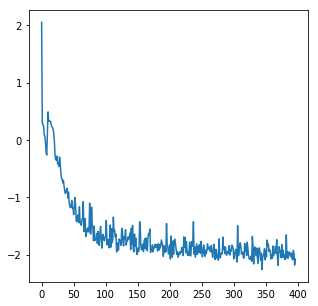

In [3]:
rule = 'contextdelaydm1'
task_set = ['delaydm1','delaydm2']
model_n = 1
fig = plt.figure(figsize=(5, 5))

for r in range(len(task_set)):
    rule = task_set[r]

    dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
    dir_specific_all = 'crystals/softplus/l2w0001'
    m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
    m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

    
    cmap = plt.get_cmap('tab20')
    c_ind = 0
    for m_ind in range(len([m_all, m_single])):
        m = [m_all, m_single][m_ind]
        m_label = rule+[' all tasks', ' single task'][m_ind]
        
        fname = os.path.join(m, 'log.json')

        with open(fname, 'r') as f:
            log_all = json.load(f)
            ax = fig.add_subplot(1,1,1)
            x = np.log(log_all['cost_'+rule])
            plt.plot(x,'-',c = cmap((2*r+m_ind)/20),label = m_label)

    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])

plt.legend()
plt.show()    

In [4]:
task_list = ['delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm']

In [5]:
rules_dict['all']

['fdgo',
 'reactgo',
 'delaygo',
 'fdanti',
 'reactanti',
 'delayanti',
 'dm1',
 'dm2',
 'contextdm1',
 'contextdm2',
 'multidm',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

In [6]:
from tools_lnd import eigenspectrum_axes

def make_eig_plot(ax):
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    
    ax.plot(xs, ys,':k',linewidth = 1)
    ax.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.6,1.3))
    plt.ylim((-.25,.25))
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax)
    ax.set_aspect('equal') 

In [7]:
task_list = ['fdgo',
 'delaygo',
 'fdanti',
 'delayanti',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

stim_list = [0,
 0,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 0,
 180,
 18,
 198]

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/fdgo/1/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz'

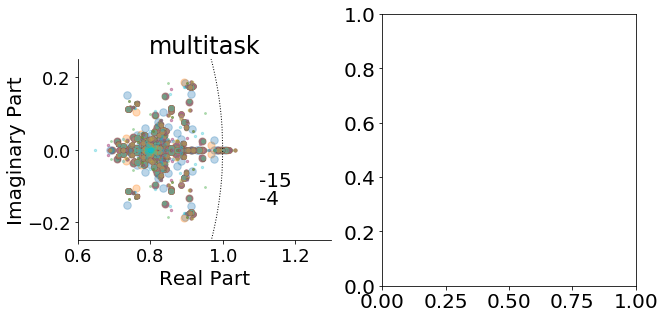

In [8]:
from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
plt.rcParams.update({'font.size': 20})

#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'
for ri in range(len(task_list)):
    rule = task_list[ri]
    ind_stim_loc = stim_list[ri]
    
    dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
    m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
    epoch = 'stim1'
    

    fig = plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1,2,1)
    filename = os.path.join(m_all,fp_file,rule,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
    fp_struct = np.load(filename)
    fp_sort = np.argsort(np.log10(fp_struct['qstar']))
    log10q = np.log10(fp_struct['qstar'])
    
    fp_num = fp_sort[log10q[fp_sort]<-8]
    J_xstar = fp_struct['J_xstar']#[fp_num,:,:]

    for fp_num in range(np.shape(J_xstar)[0]):
        evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
        ax1.plot(evals.real,evals.imag,'.',markersize = -log10q[fp_num],alpha = .3)
        
    plt.text(1.1,-.1,"{:.0f}".format(np.min(log10q)))
    plt.text(1.1,-.15,"{:.0f}".format(np.max(log10q)))
    make_eig_plot(ax1)
    plt.title('multitask')

    ax2 = plt.subplot(1,2,2)
    filename = os.path.join(m_single,fp_file,rule,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
    fp_struct = np.load(filename)
    fp_sort = np.argsort(np.log10(fp_struct['qstar']))
    log10q = np.log10(fp_struct['qstar'])
    
    log10q_keep = fp_sort[log10q[fp_sort]<-8]
    J_xstar = fp_struct['J_xstar']#[fp_num,:,:]

    for fp_num in range(np.shape(J_xstar)[0]):
        evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
        ax2.plot(evals.real,evals.imag,'.',markersize = -log10q[fp_num], alpha = .3)
             
    plt.text(1.1,-.1,"{:.0f}".format(np.min(log10q)))
    plt.text(1.1,-.15,"{:.0f}".format(np.max(log10q)))
    make_eig_plot(ax2)
    plt.title('single '+rule)
    plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/m

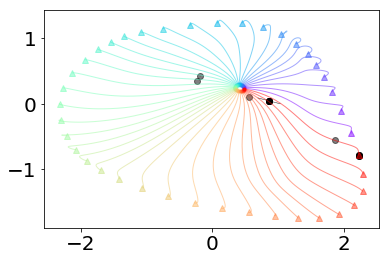

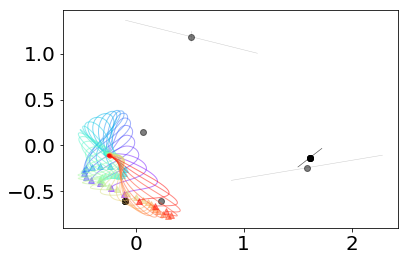

In [41]:
from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
plt.rcParams.update({'font.size': 20})

#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'
    
dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))

r1 = 'fdanti'
r2 = 'fdgo'
epoch = 'stim1'
D_r2 = make_axes(m_all,r1,epoch)
D_r2 = make_axes(m_all,r2,epoch)
ind_stim_loc = 180

m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    
    trial_r1 = generate_trials(r1, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_r1, hparams)
    h_tf_r1, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    trial_r2 = generate_trials(r2, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_r2, hparams)
    h_tf_r2, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
X = np.transpose(h_tf,(1,0,2))

filename = os.path.join(m_all,fp_file,rule,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
fp_struct = np.load(filename)
fp_sort = np.argsort(np.log10(fp_struct['qstar']))
log10q = np.log10(fp_struct['qstar'])

fp_num = fp_sort[log10q[fp_sort]<0]
    
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_num,:,:])

plot_FP(fp_struct['xstar'][fp_num,:], D.T, eig_decomps)
stim_inds = range(trial.epochs['stim1'][0],trial.epochs['stim1'][1])
X_stim = X[range(0,80,2),trial.epochs['stim1'][0]:trial.epochs['stim1'][1],:]
plot_N(X_stim, D.T, range(0,80,2),alpha = 1)
plot_N(X_stim, D.T, range(0,80,2),alpha = .5)
plt.show()

plot_FP(fp_struct['xstar'][fp_num,:], D_r2.T, eig_decomps)
stim_inds = range(trial.epochs['stim1'][0],trial.epochs['stim1'][1])
X_stim = X[range(0,80,2),trial.epochs['stim1'][0]:trial.epochs['stim1'][1],:]
plot_N(X_stim, D_r2.T, range(0,80,2))
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


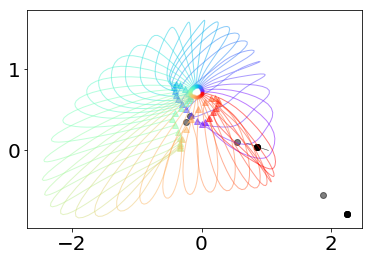

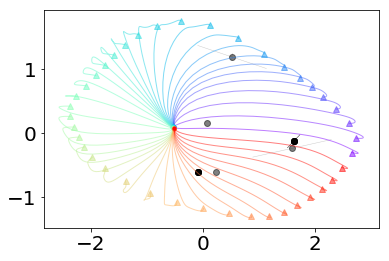

In [40]:
r2 = 'fdgo'
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(r2, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
X = np.transpose(h_tf,(1,0,2))

plot_FP(fp_struct['xstar'][fp_num,:], D.T, eig_decomps)
stim_inds = range(trial.epochs['stim1'][0],trial.epochs['stim1'][1])
X_stim = X[range(0,80,2),trial.epochs['stim1'][0]:trial.epochs['stim1'][1],:]
plot_N(X_stim, D.T, range(0,80,2))
plt.show()

plot_FP(fp_struct['xstar'][fp_num,:], D_r2.T, eig_decomps)
stim_inds = range(trial.epochs['stim1'][0],trial.epochs['stim1'][1])
X_stim = X[range(0,80,2),trial.epochs['stim1'][0]:trial.epochs['stim1'][1],:]
plot_N(X_stim, D_r2.T, range(0,80,2))
plt.show()

In [9]:
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt


In [10]:
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt


In [11]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

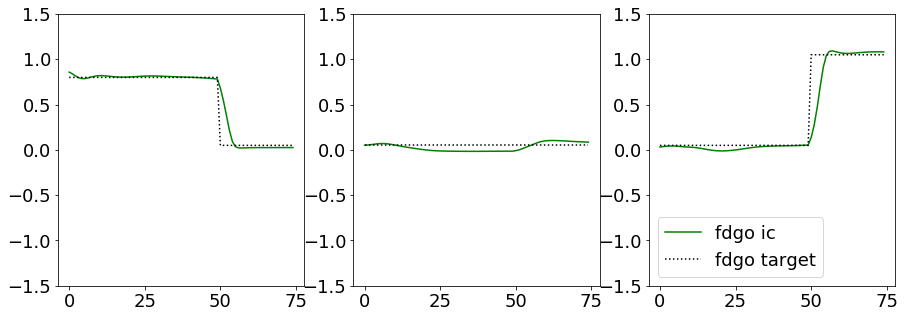

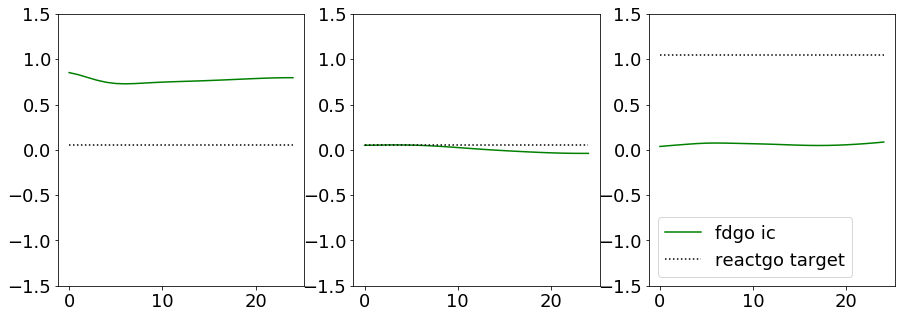

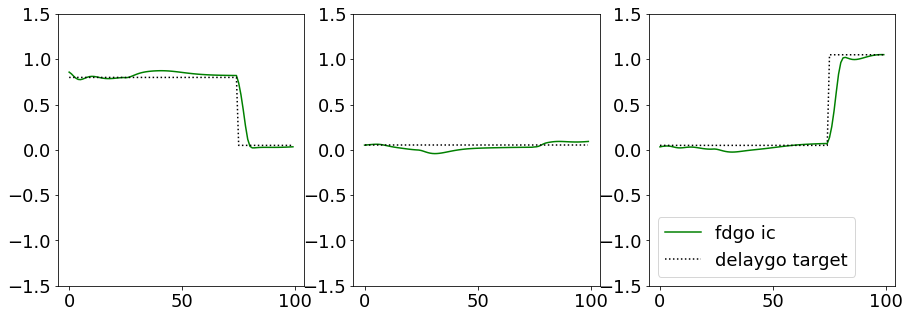

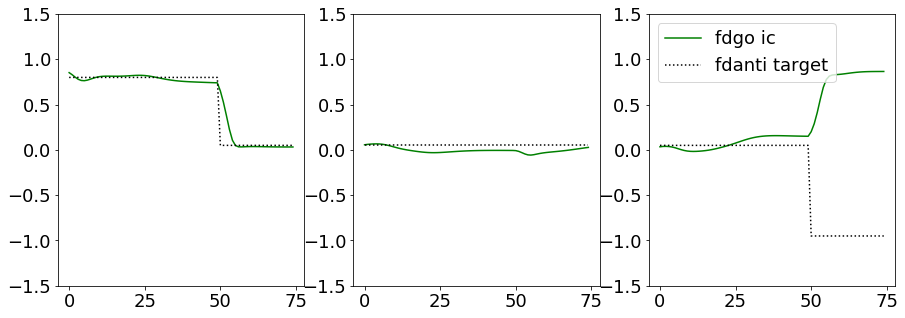

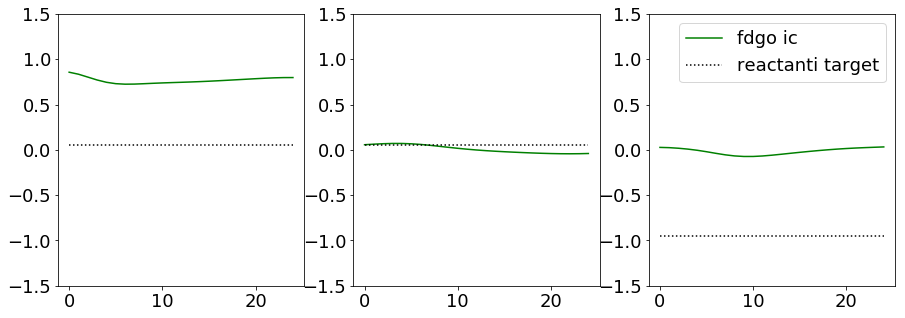

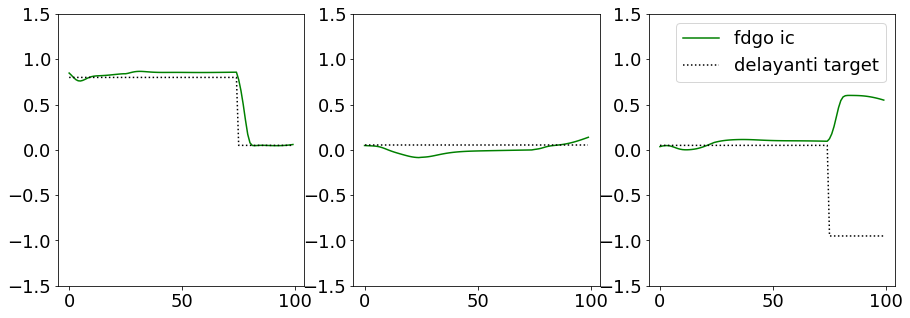

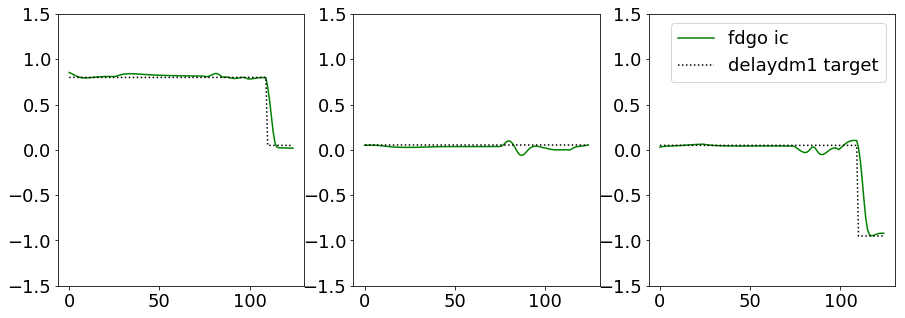

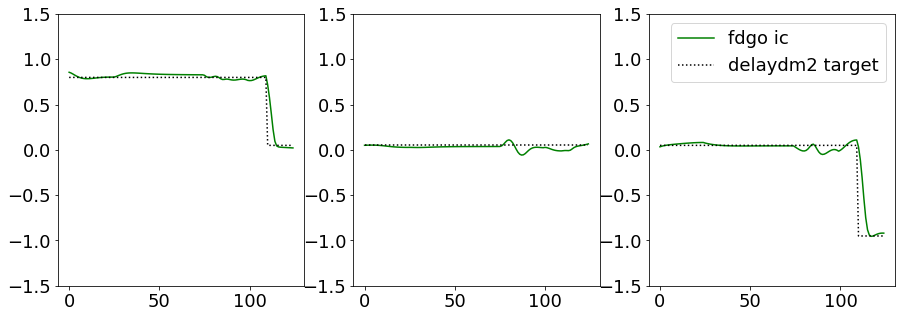

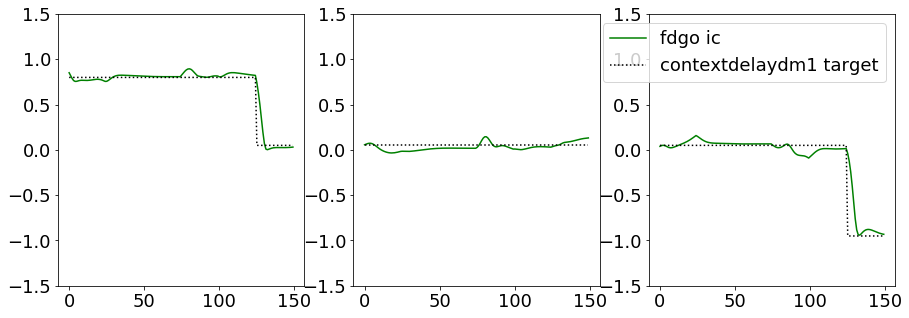

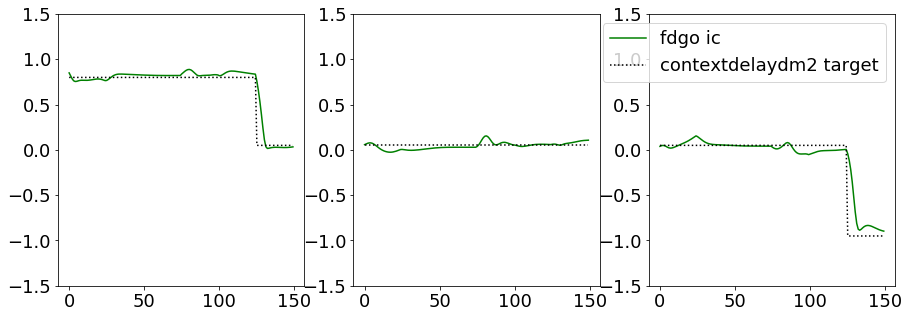

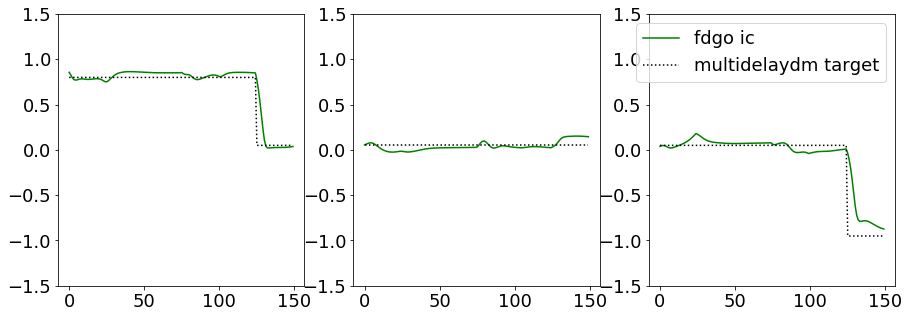

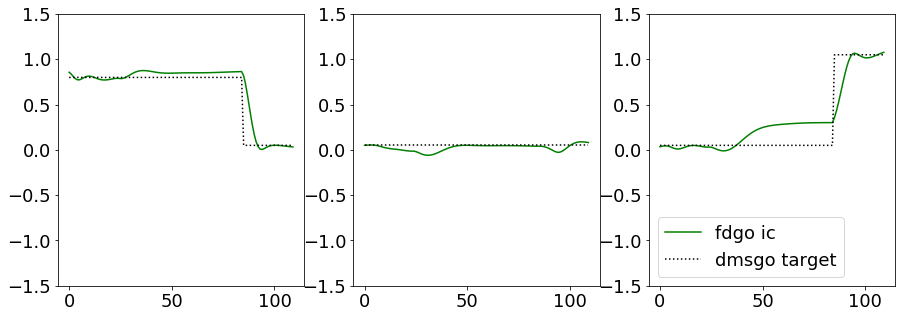

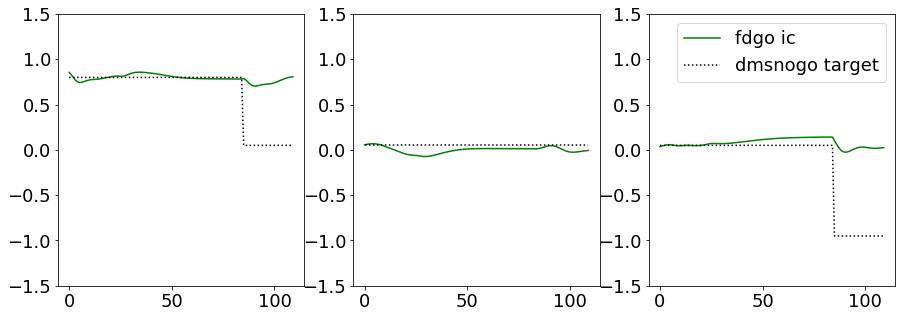

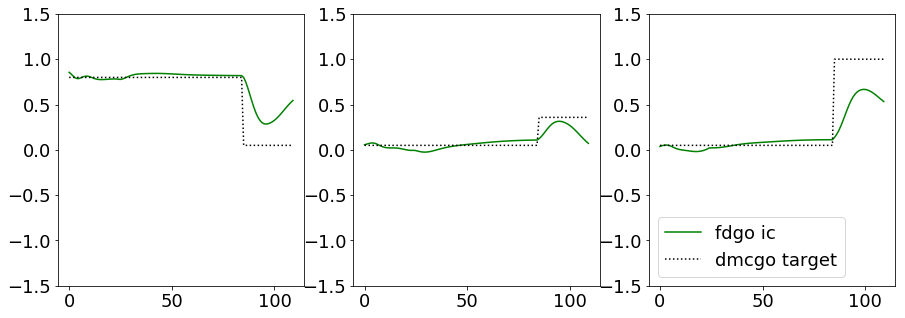

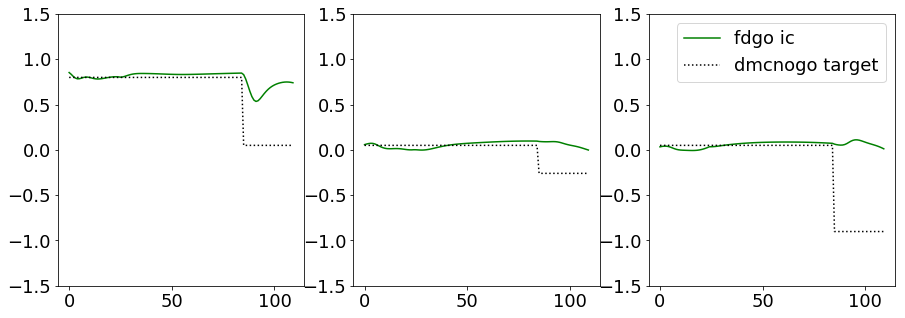

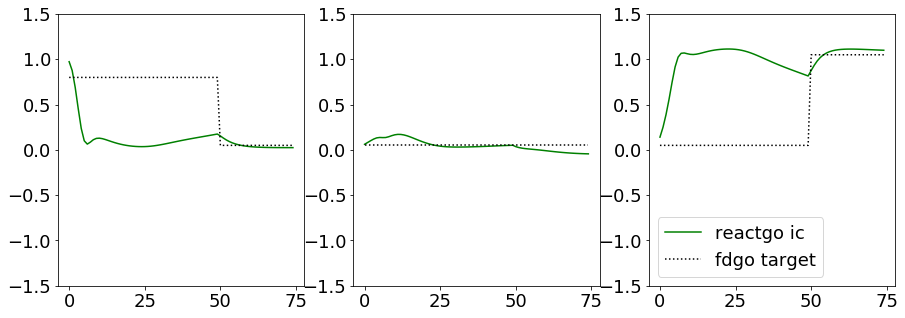

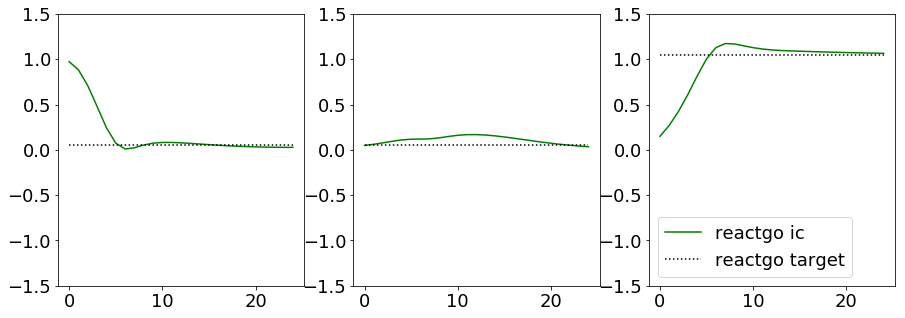

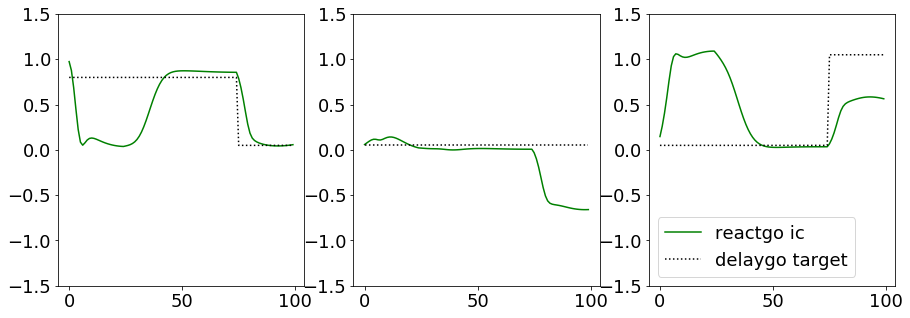

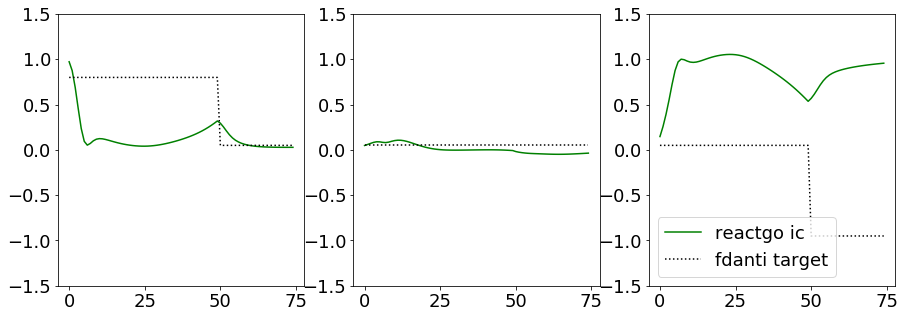

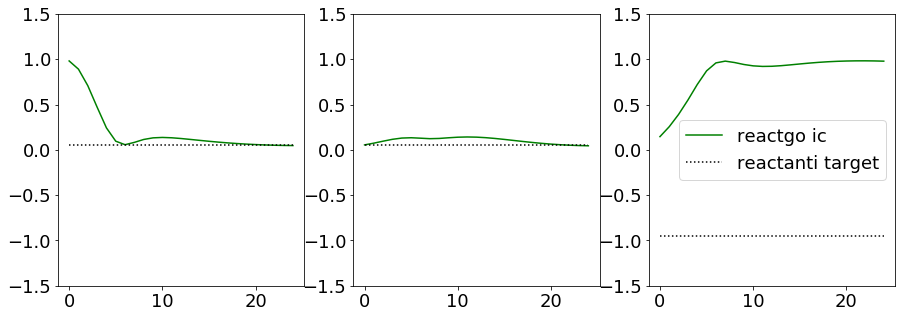

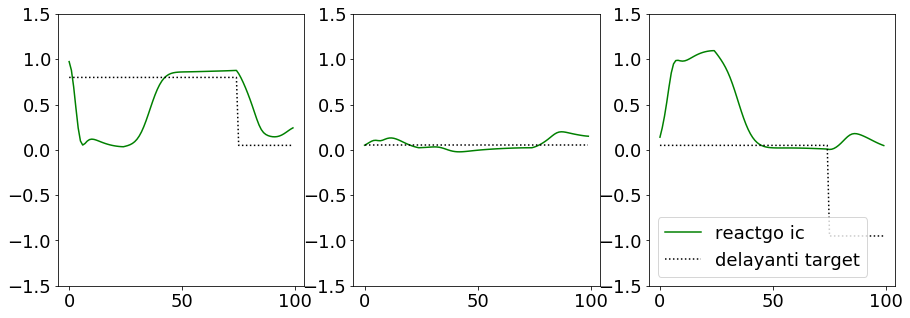

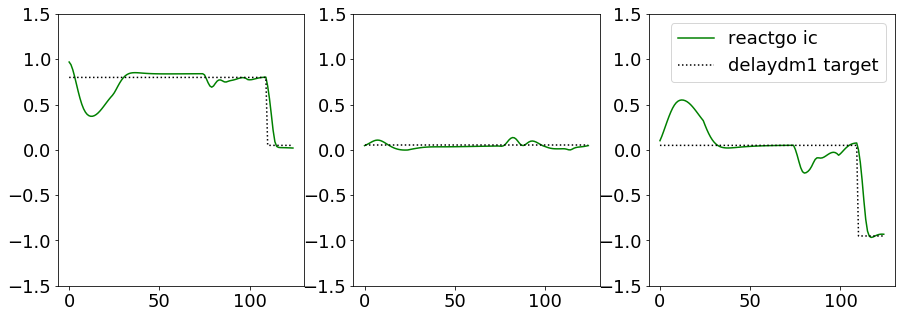

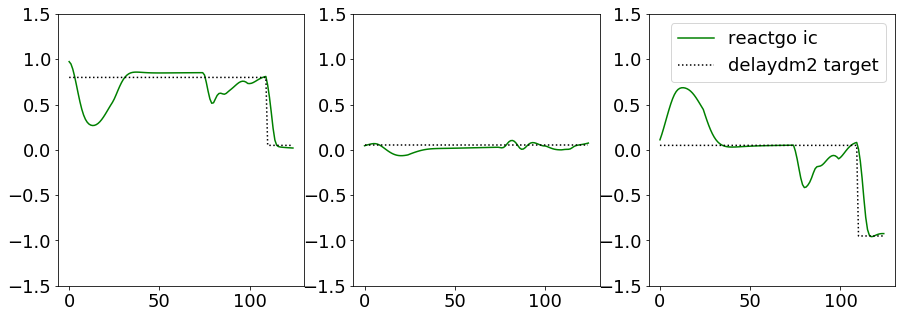

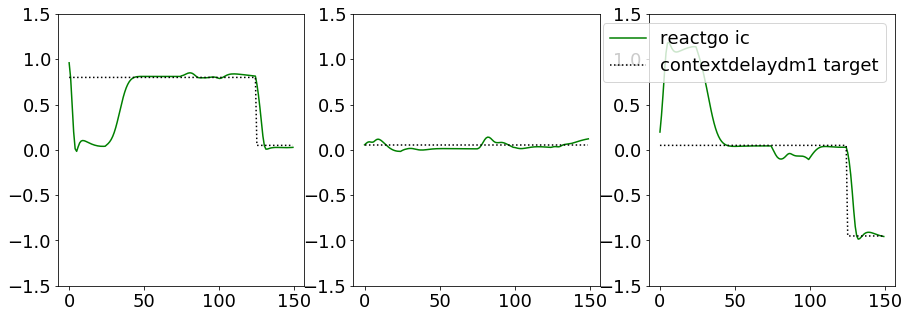

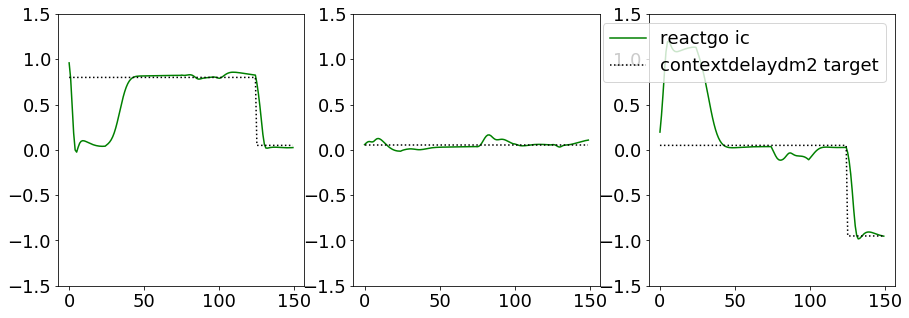

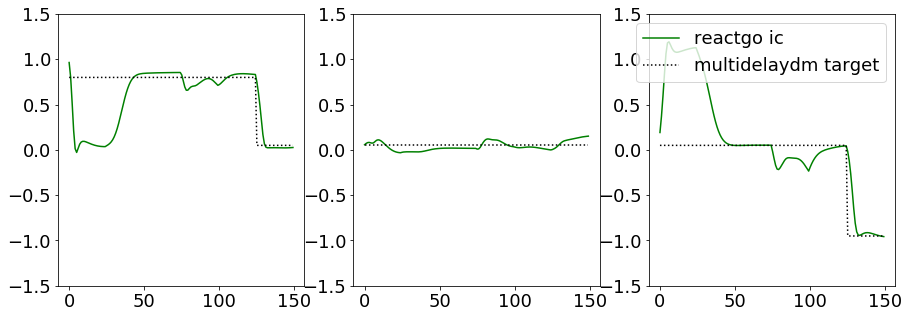

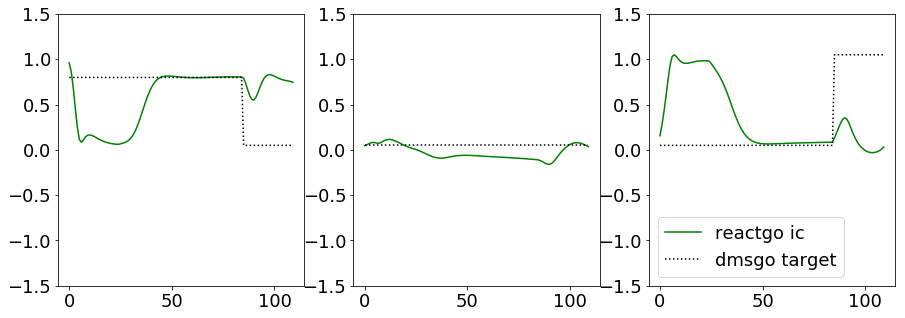

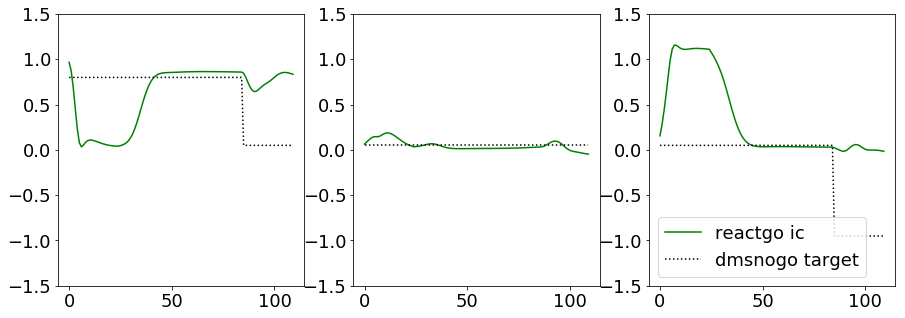

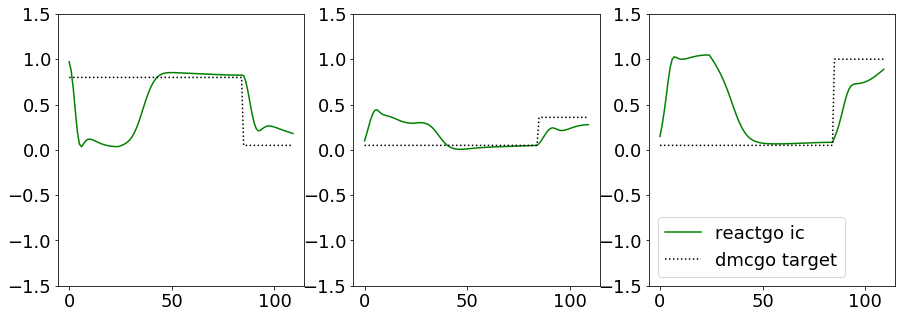

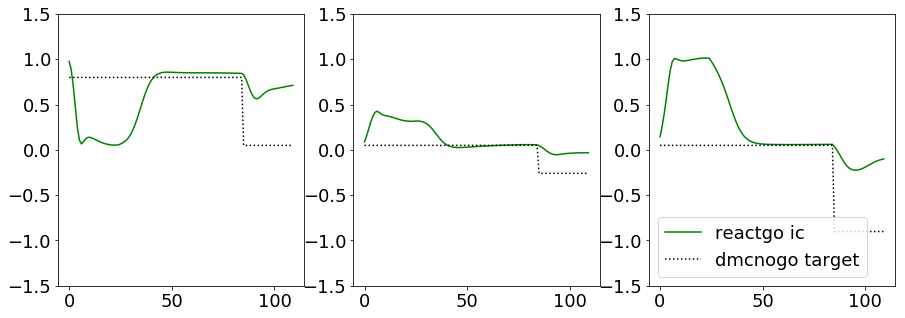

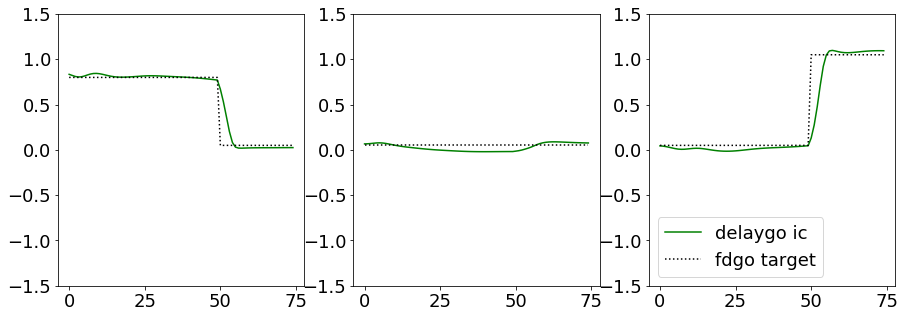

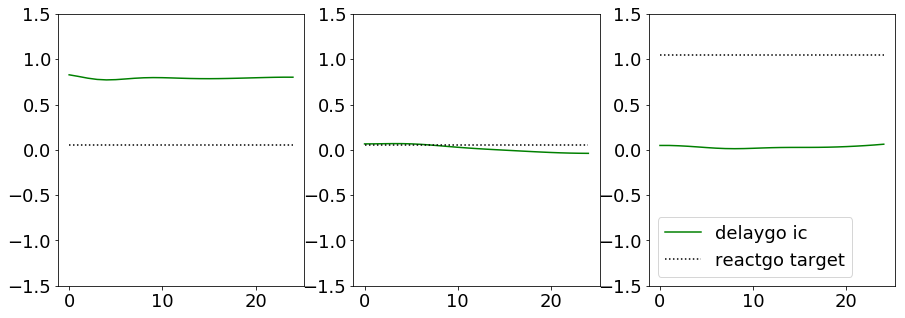

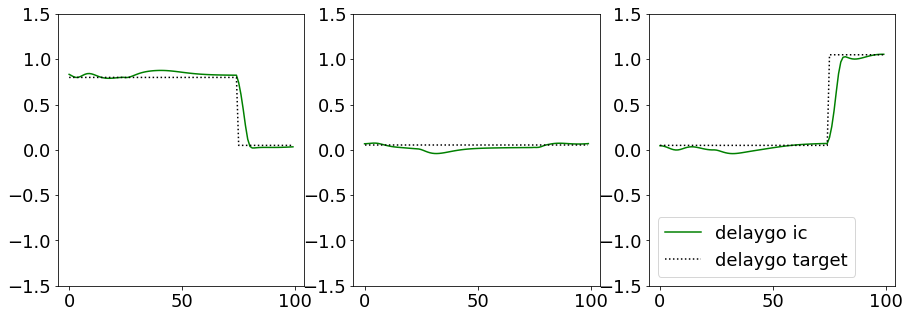

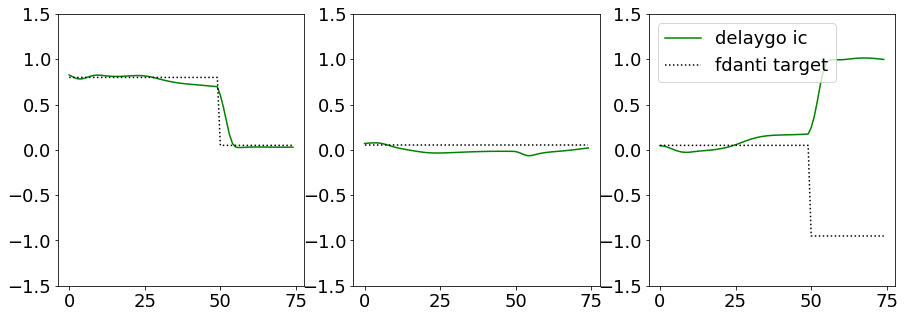

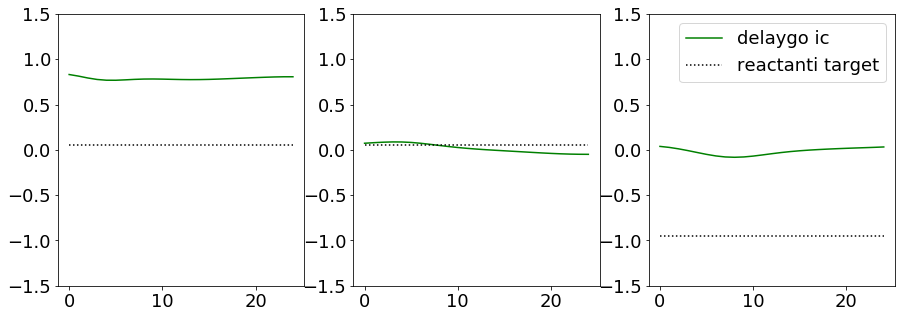

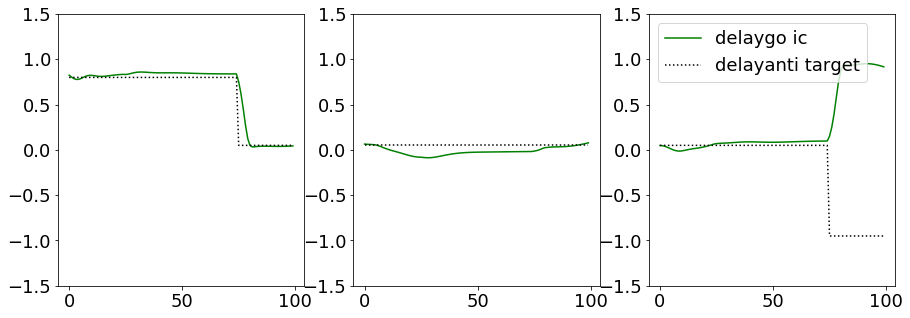

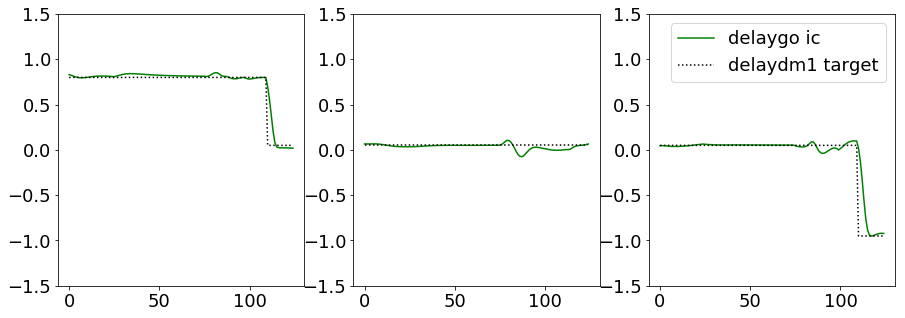

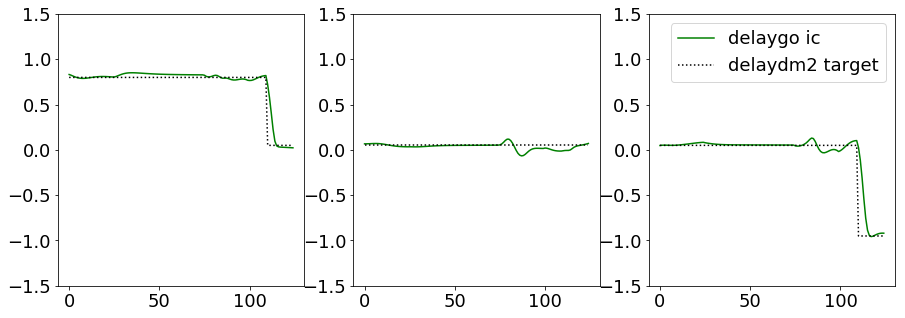

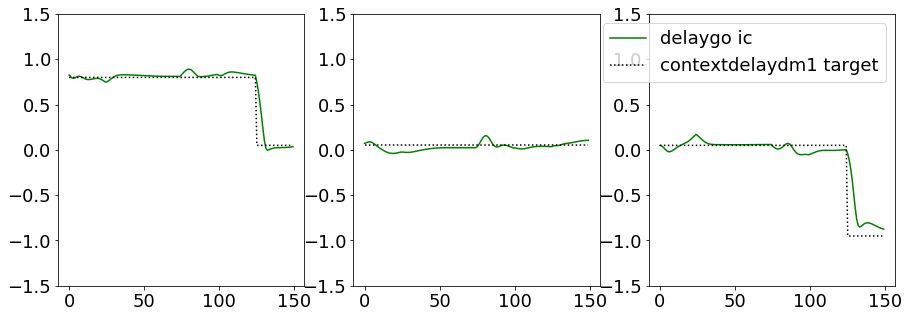

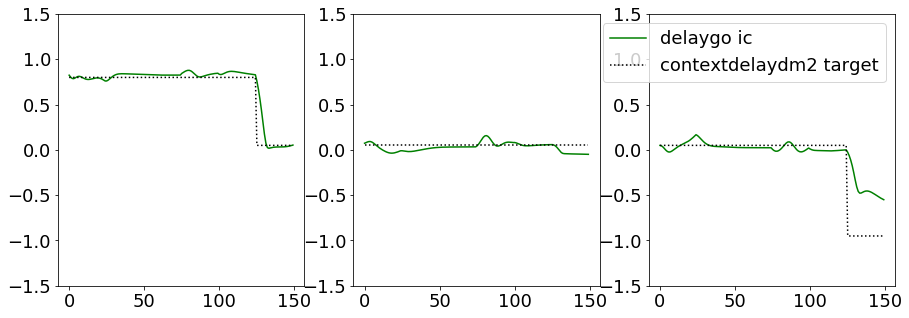

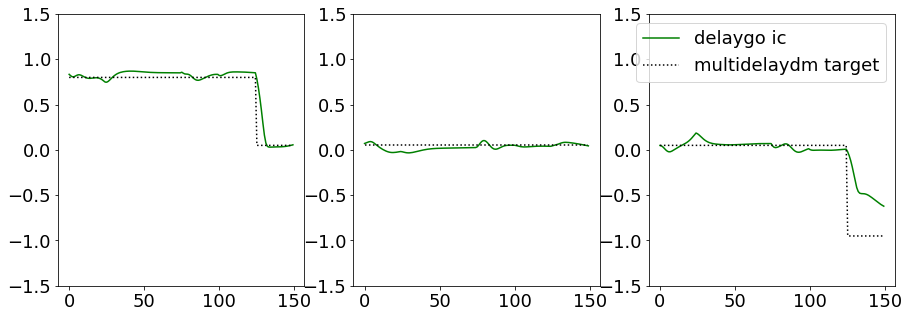

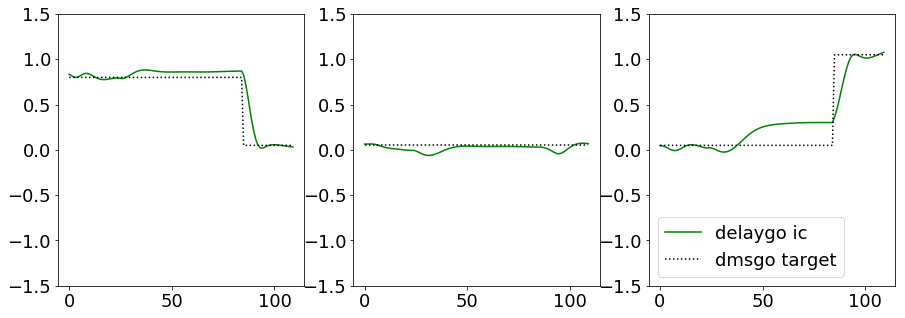

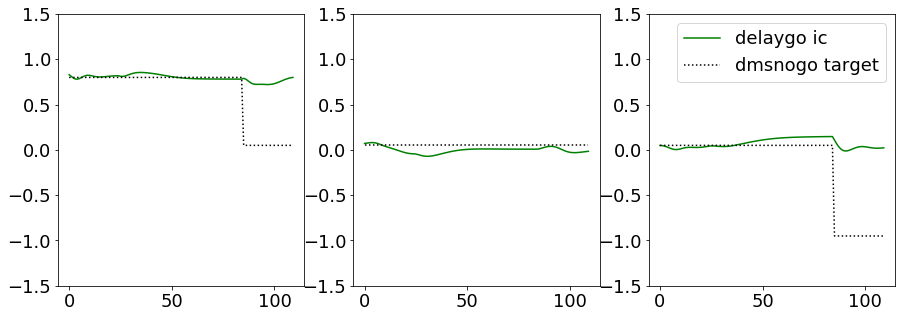

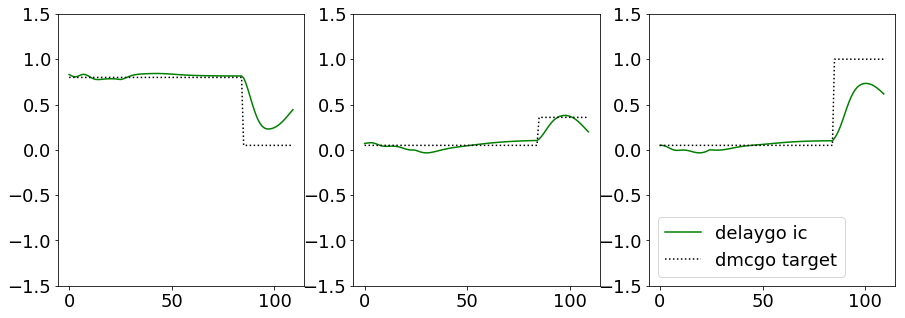

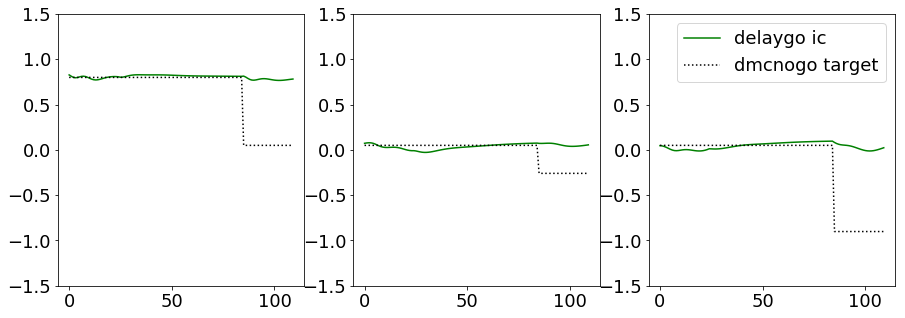

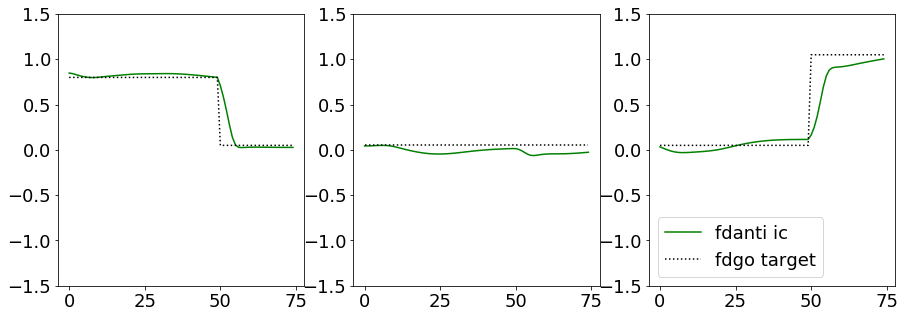

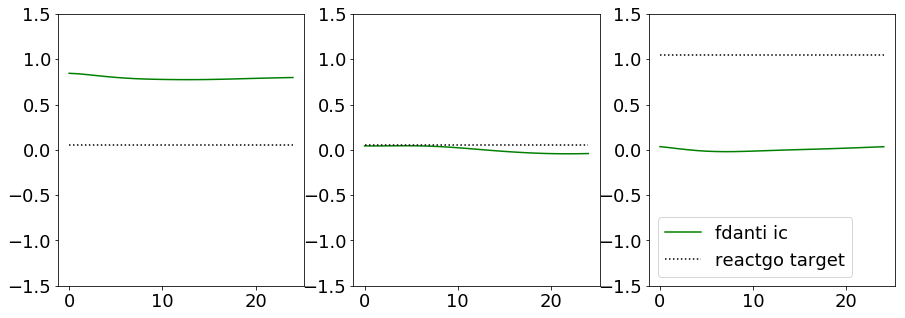

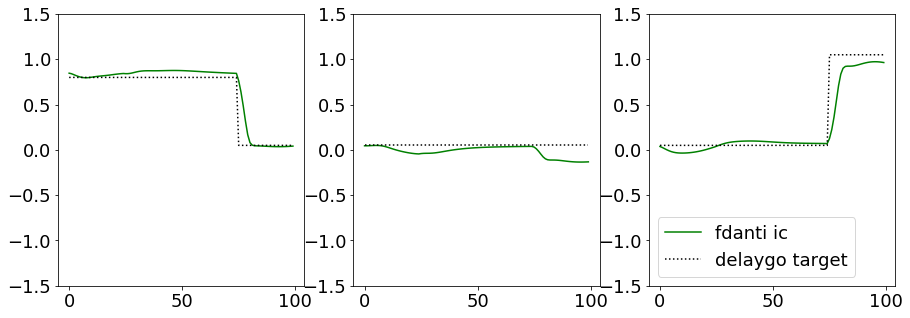

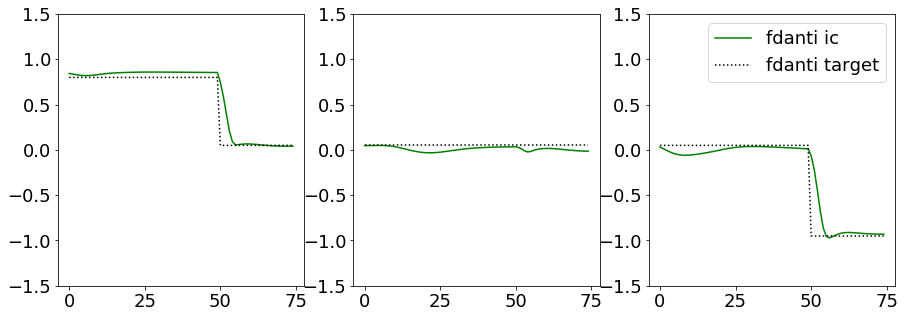

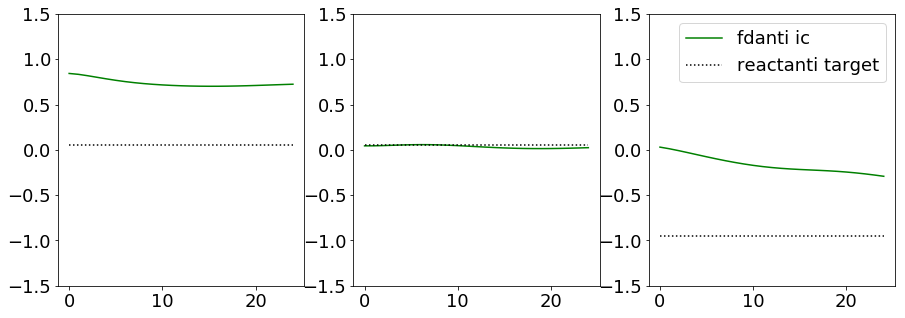

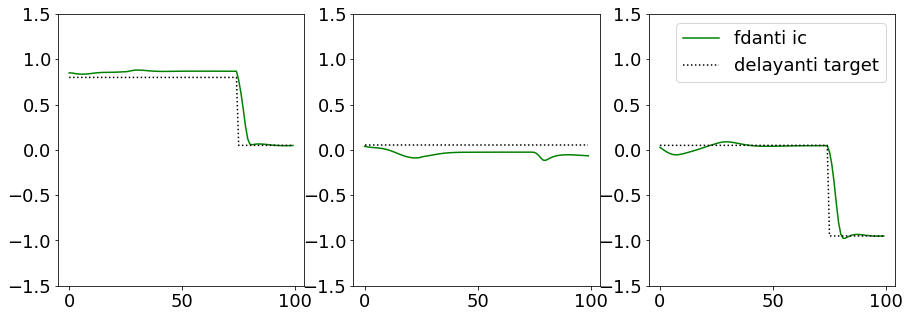

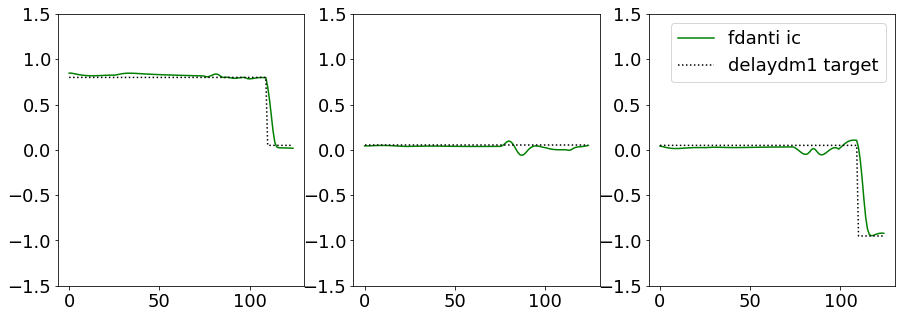

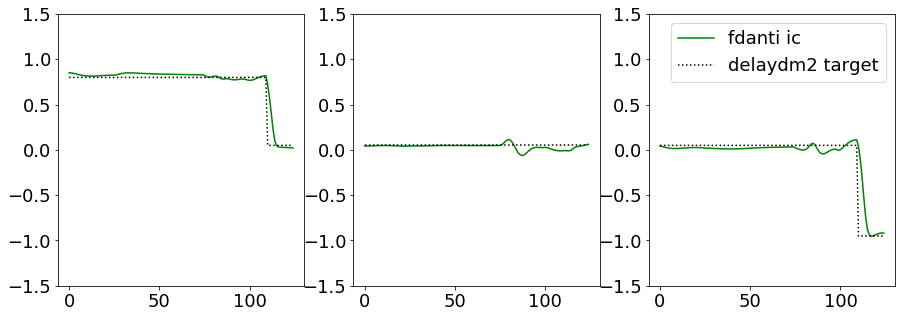

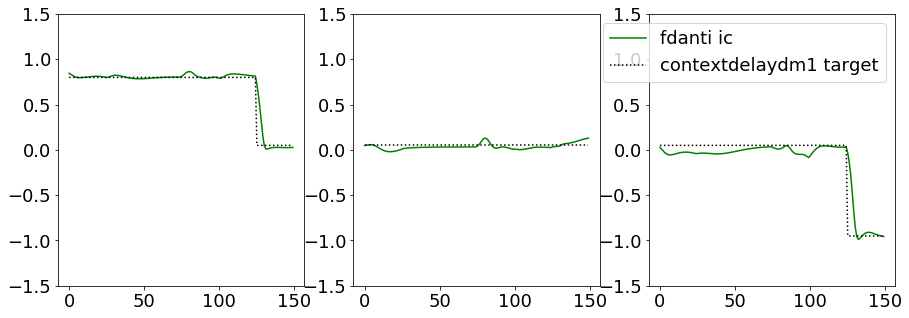

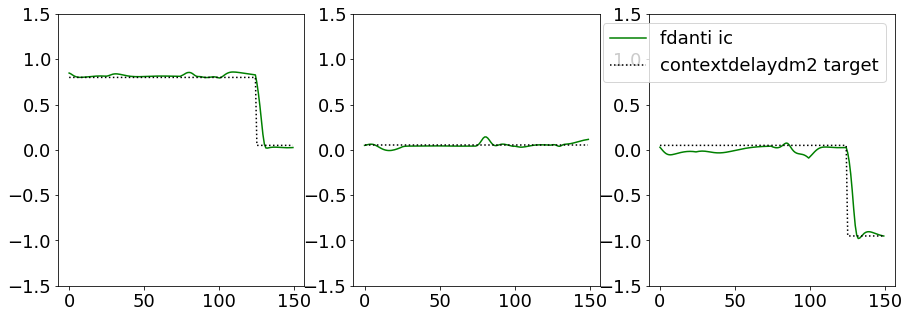

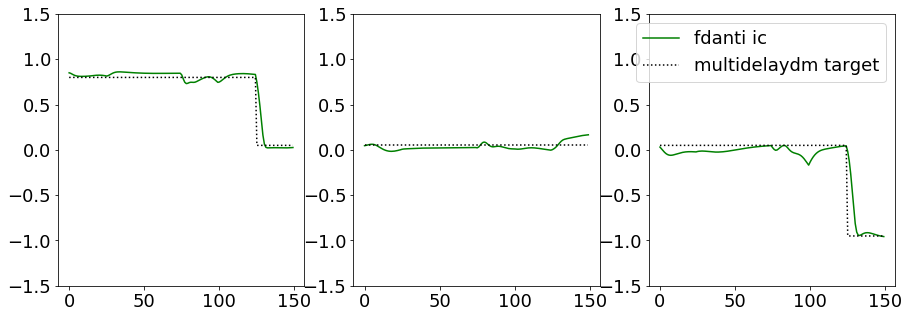

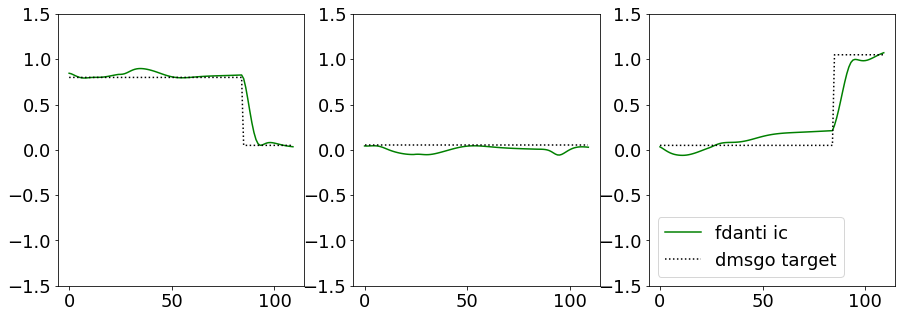

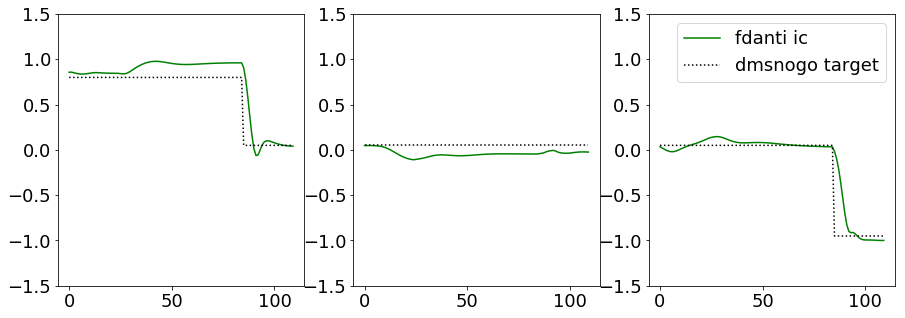

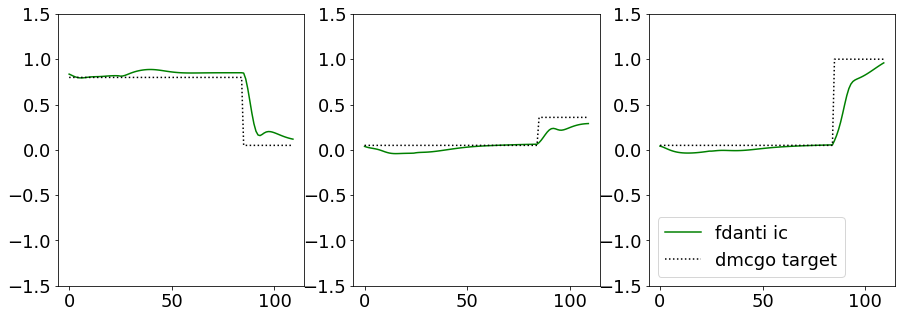

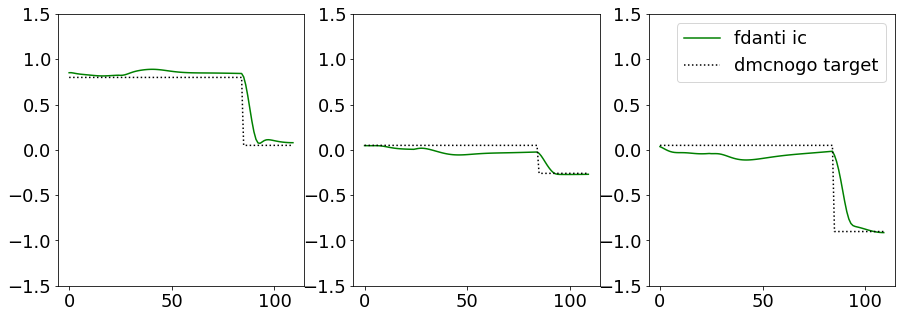

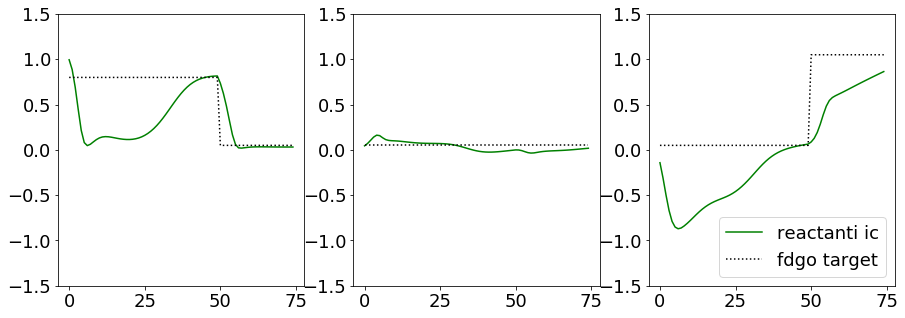

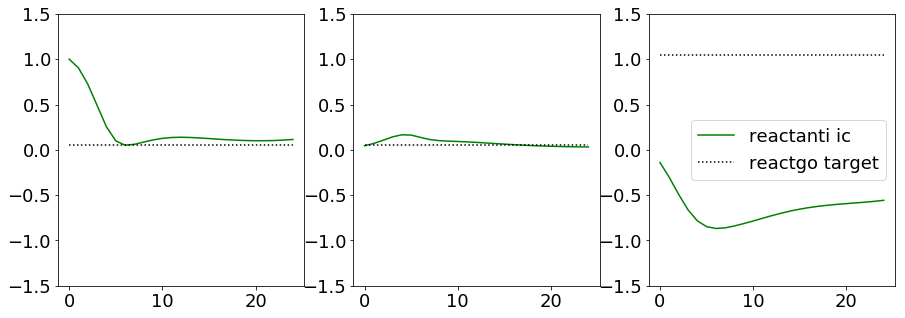

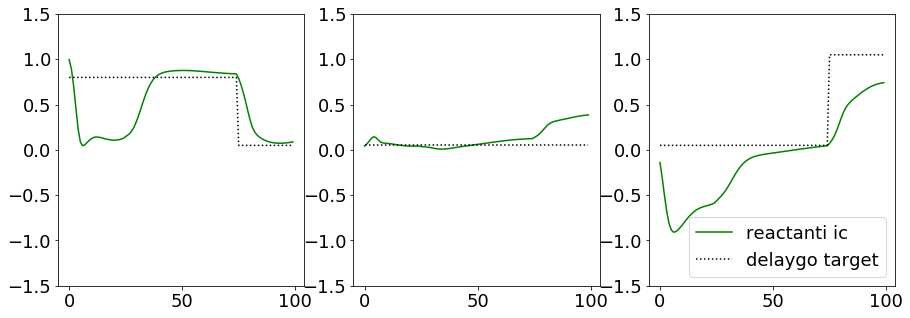

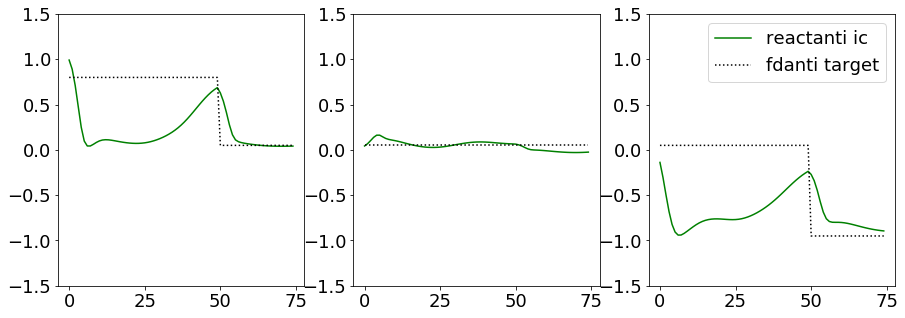

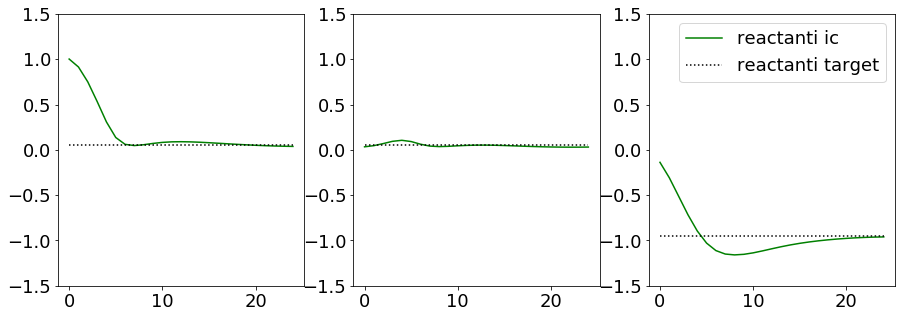

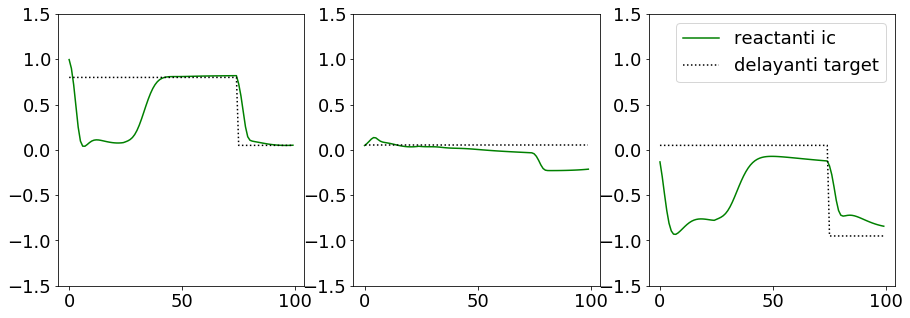

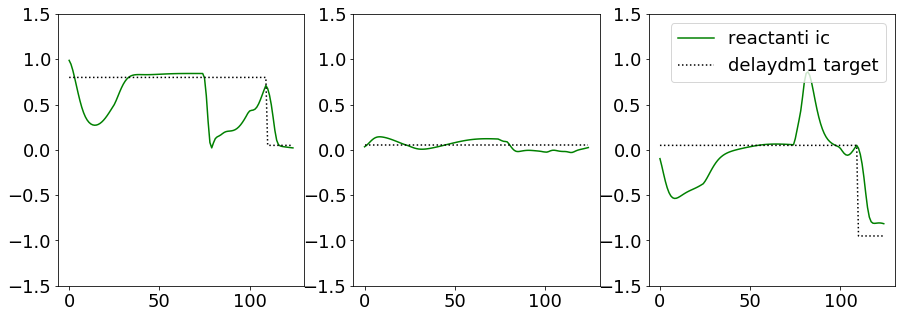

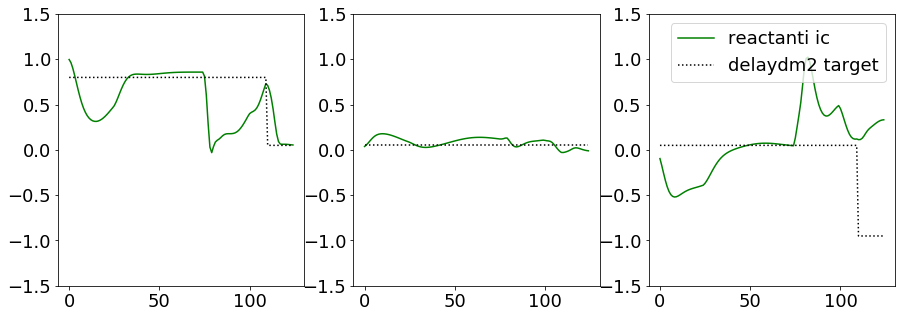

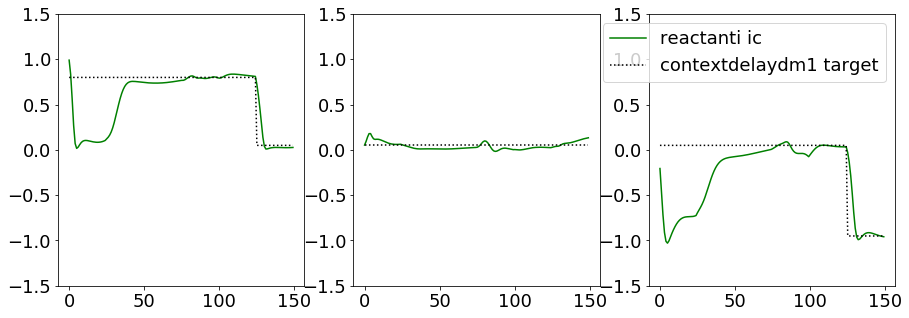

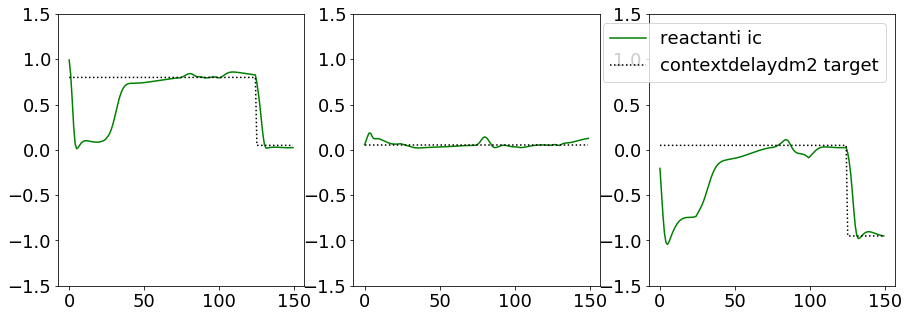

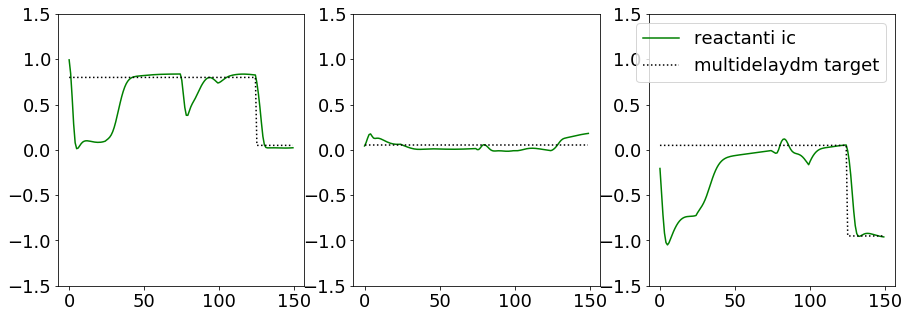

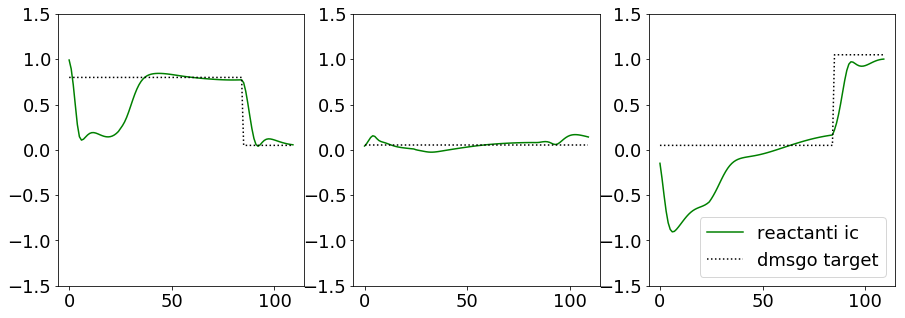

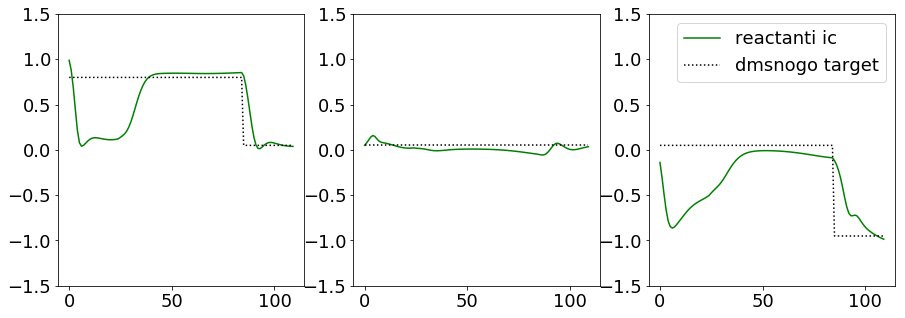

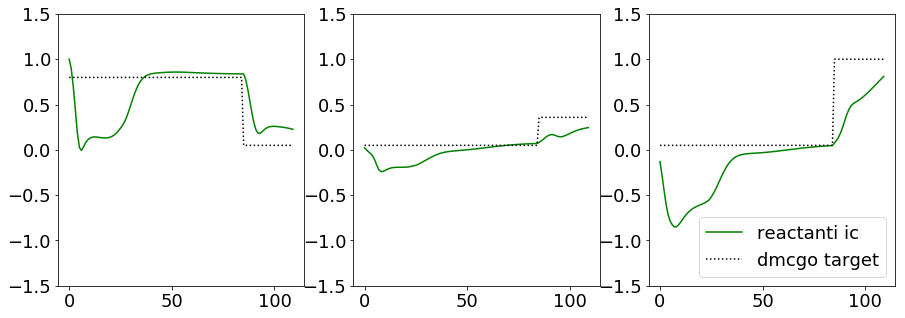

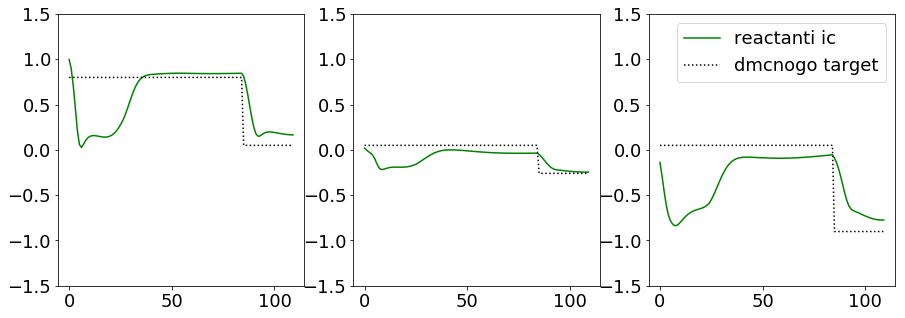

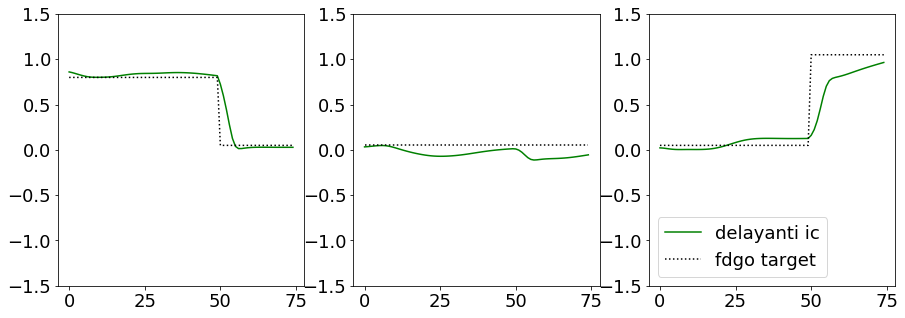

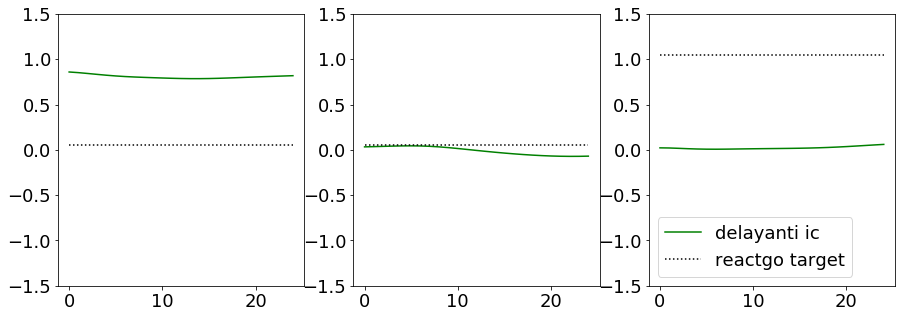

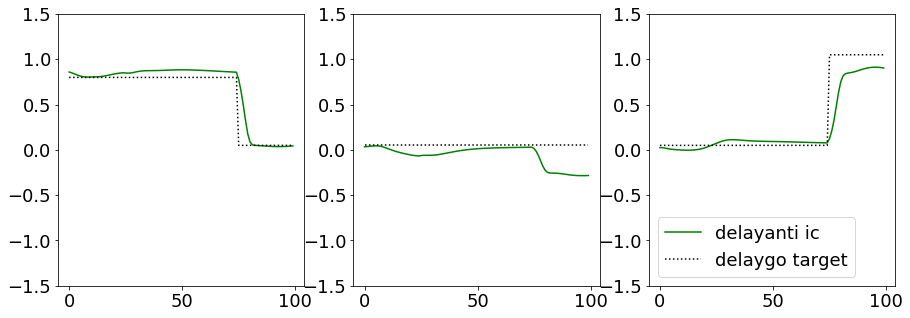

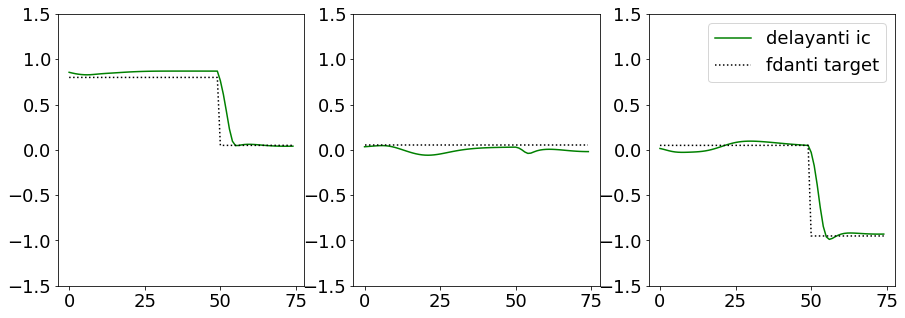

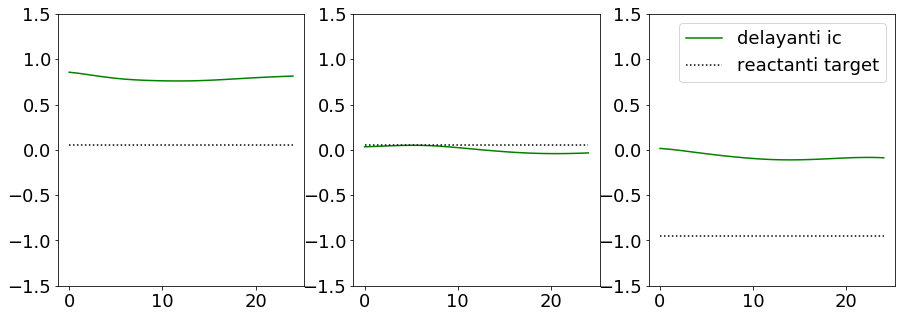

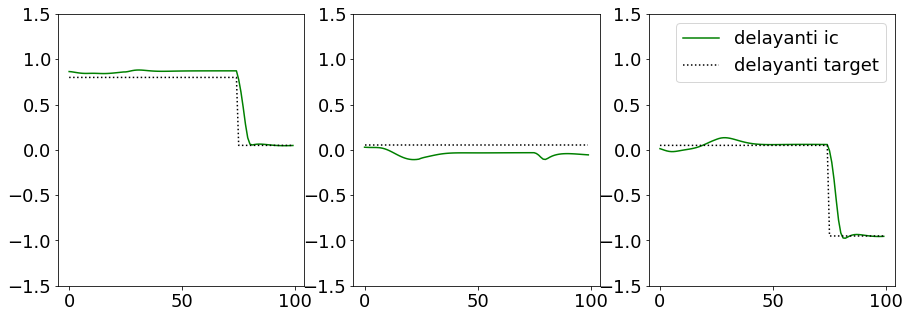

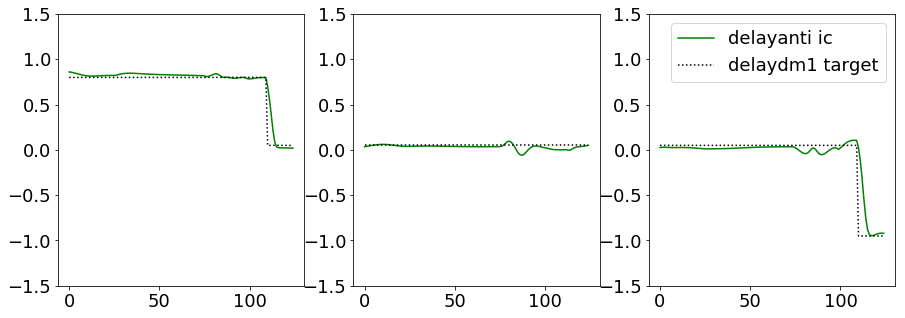

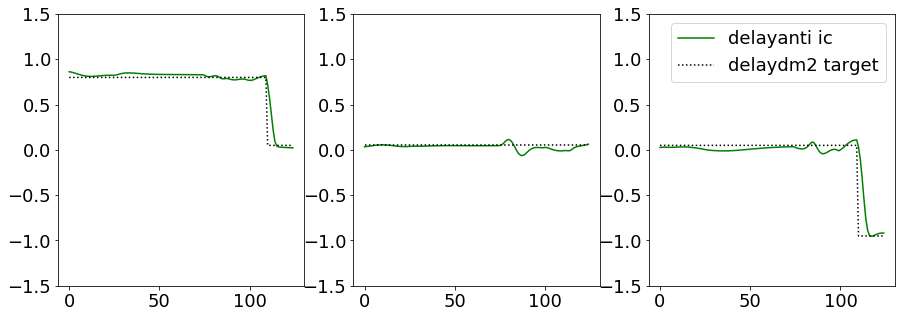

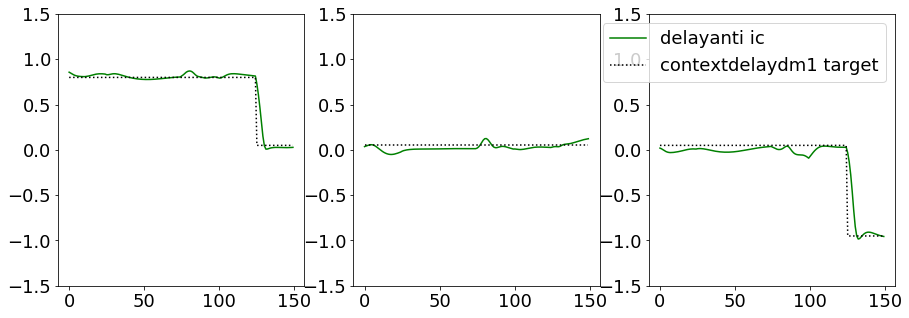

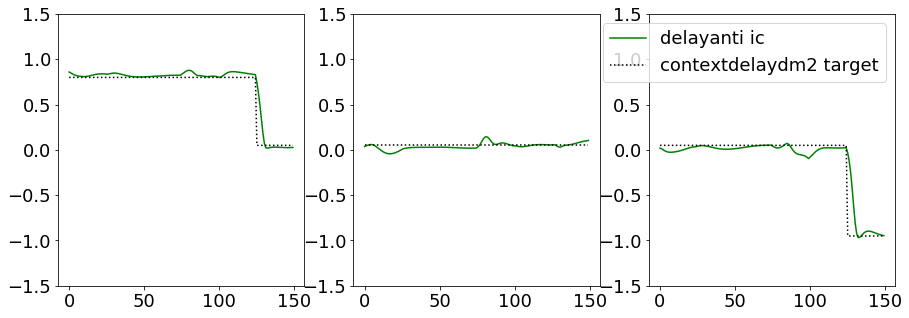

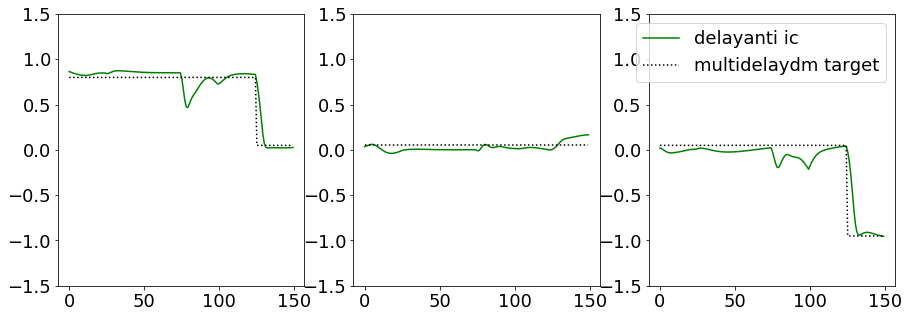

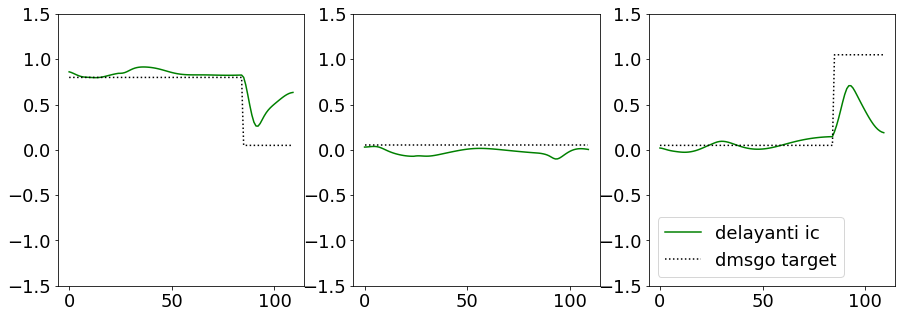

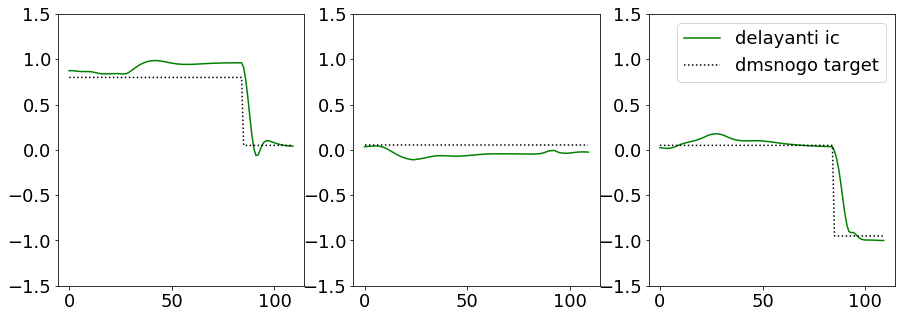

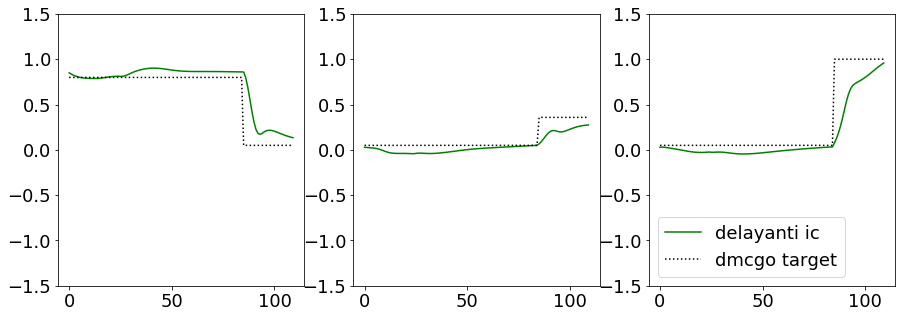

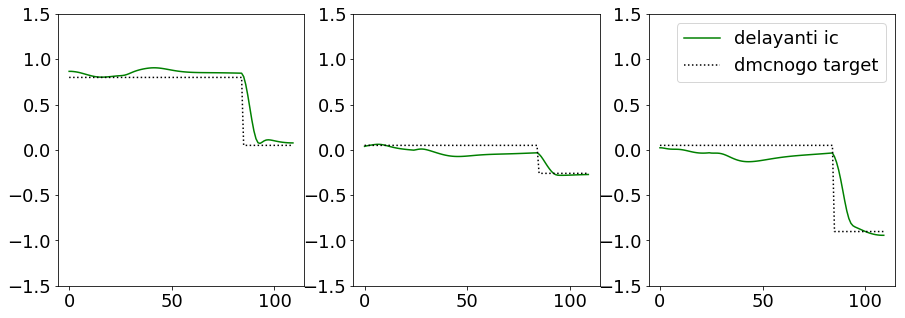

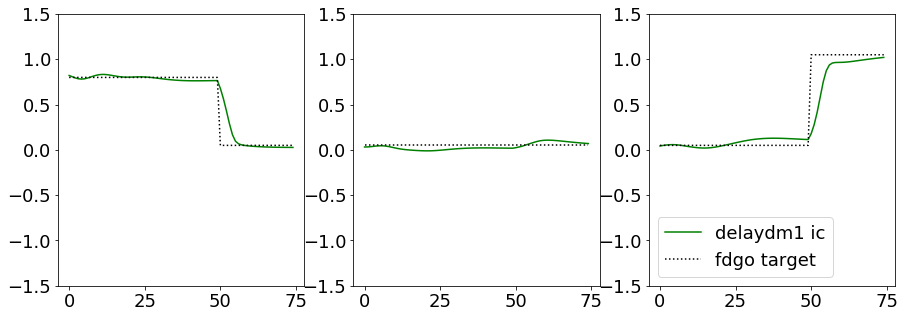

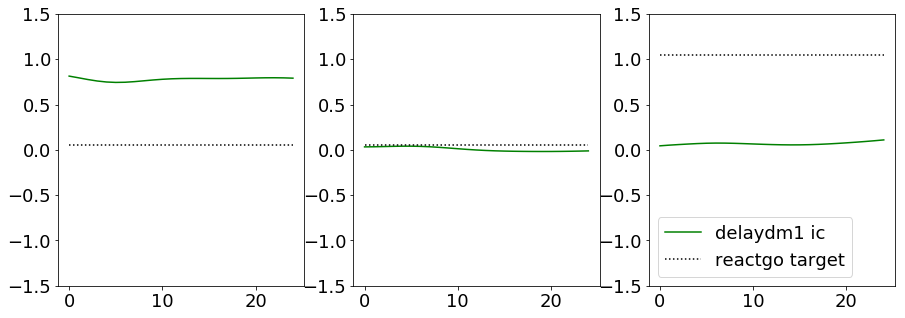

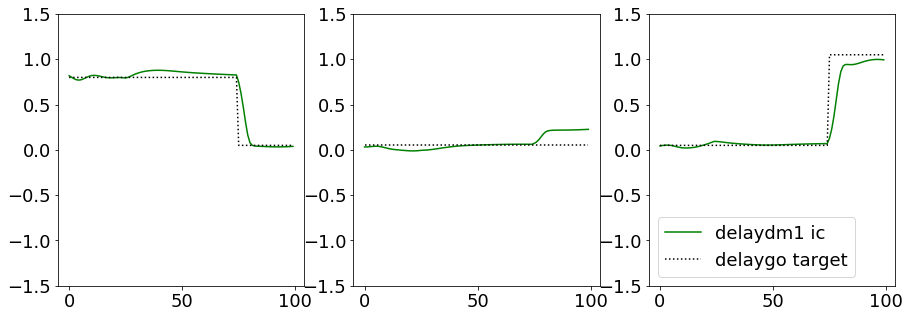

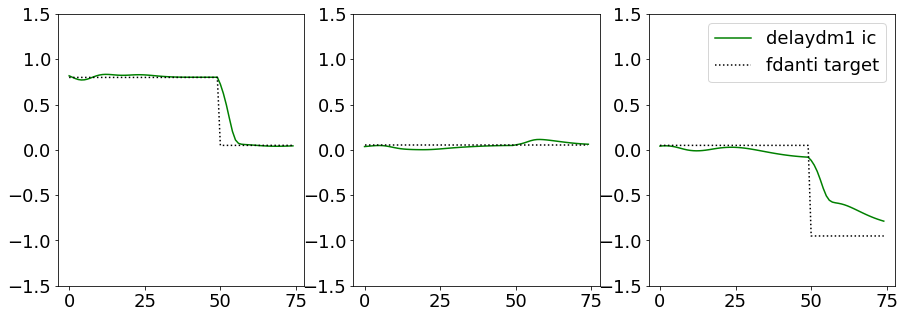

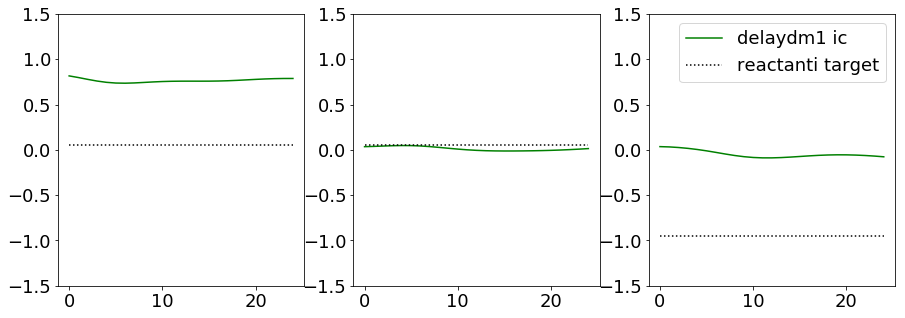

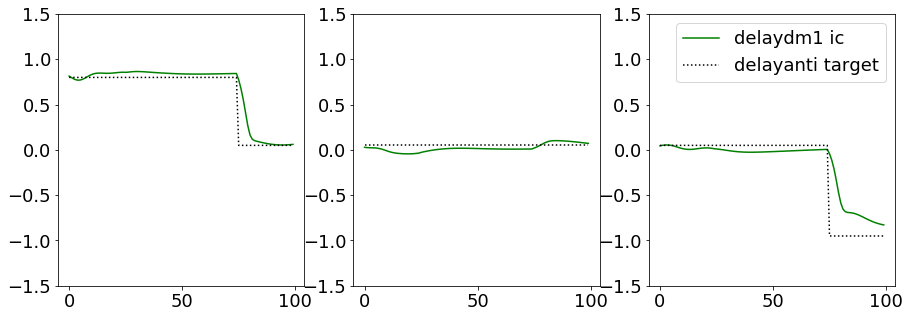

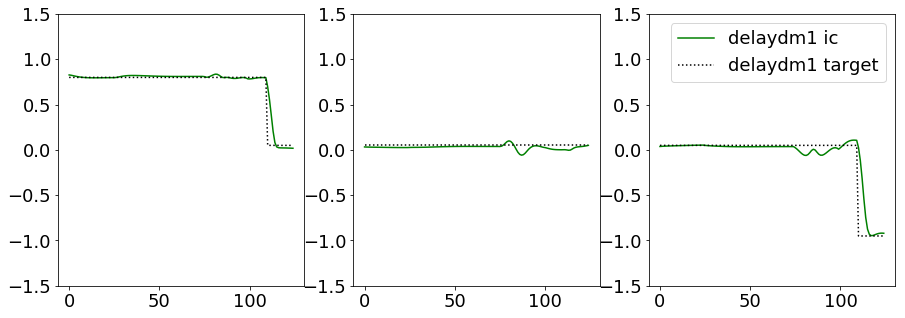

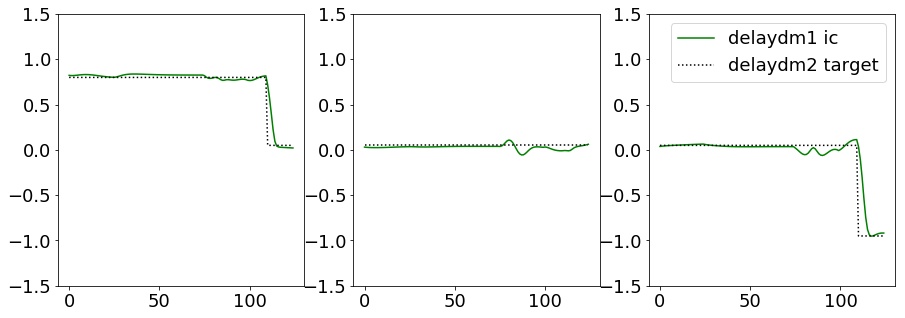

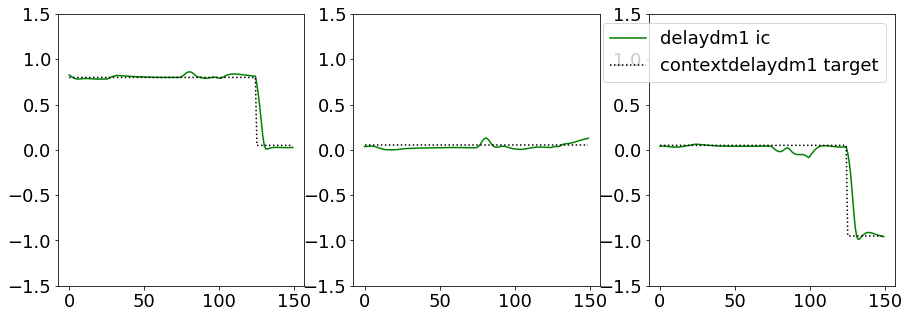

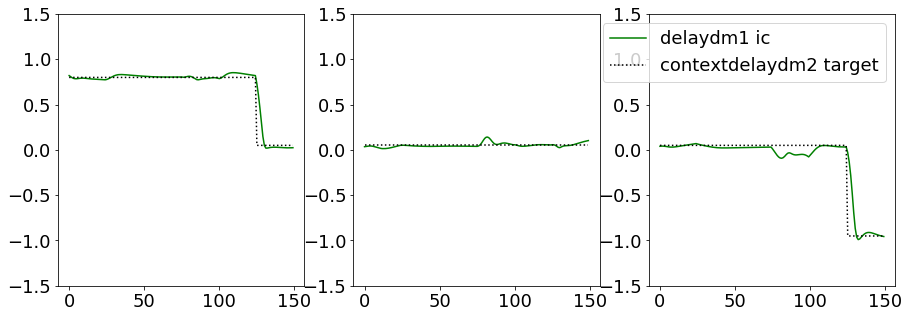

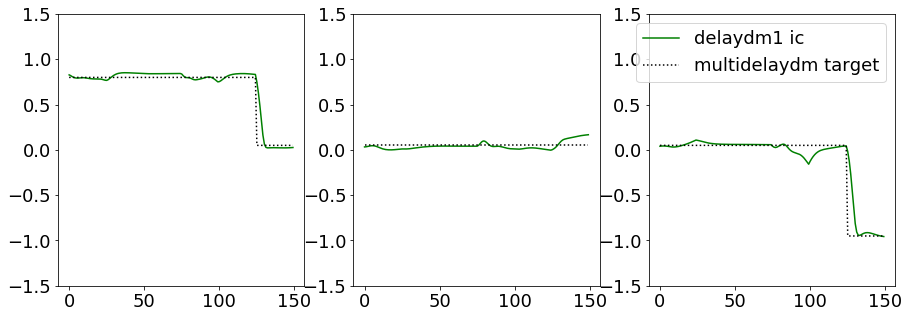

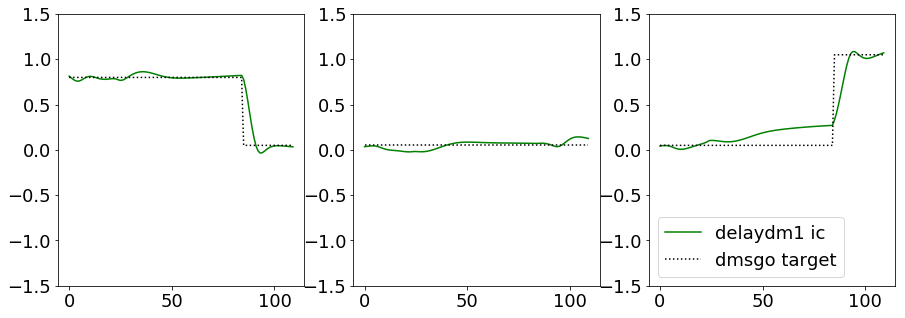

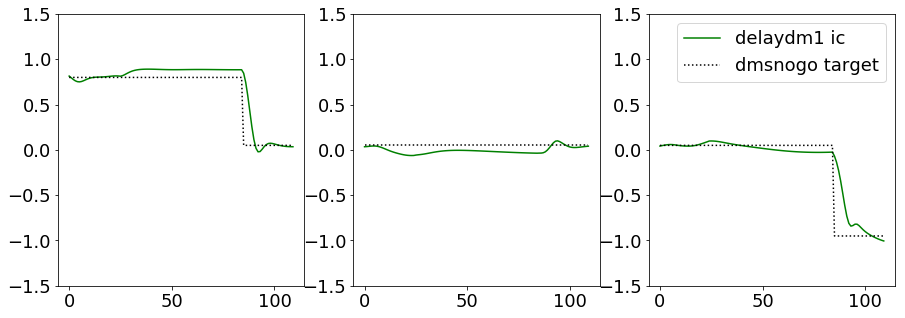

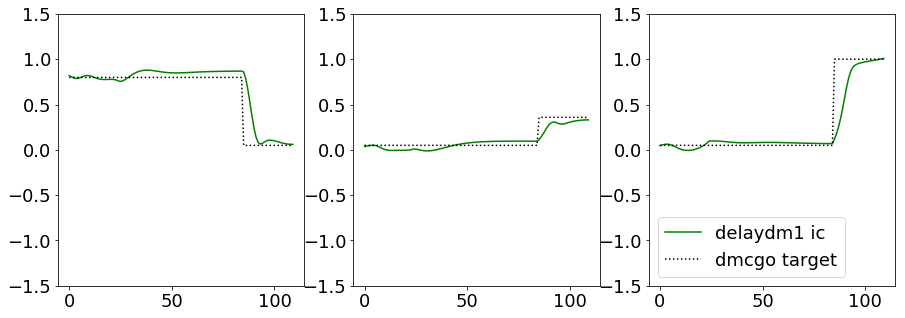

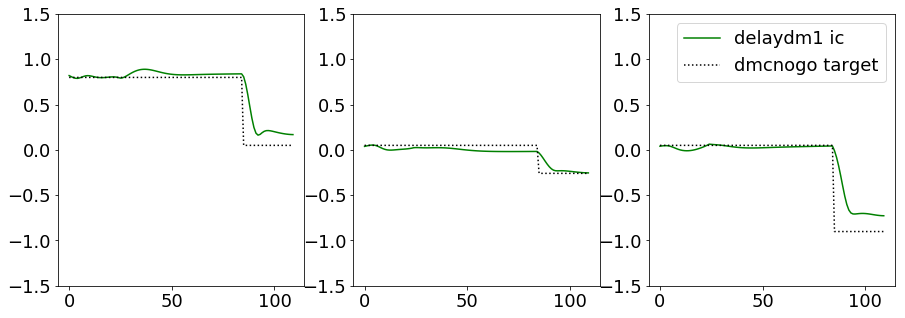

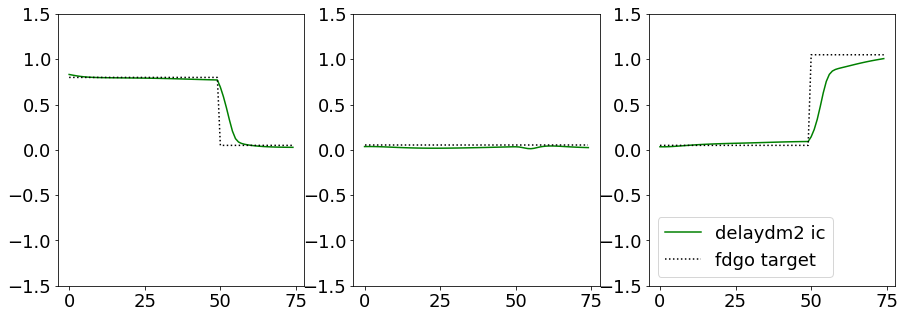

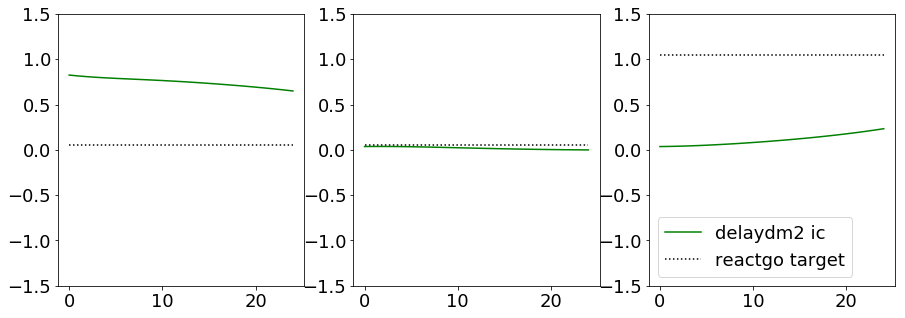

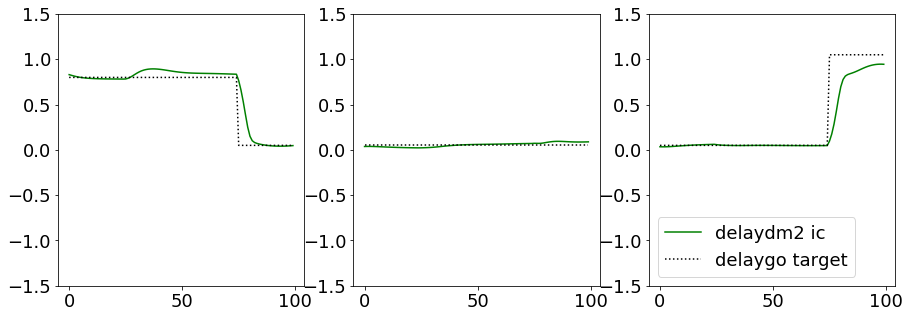

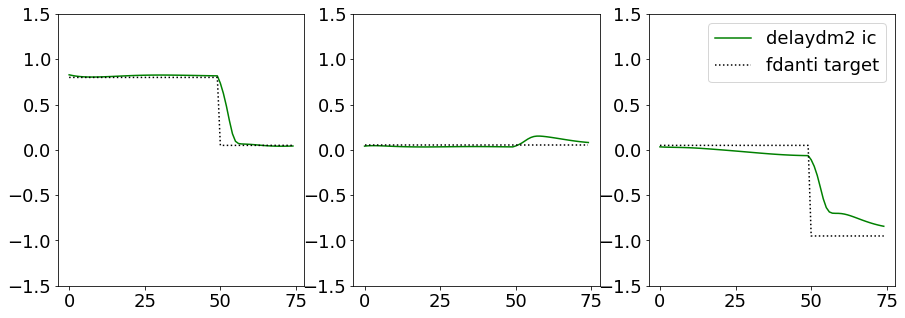

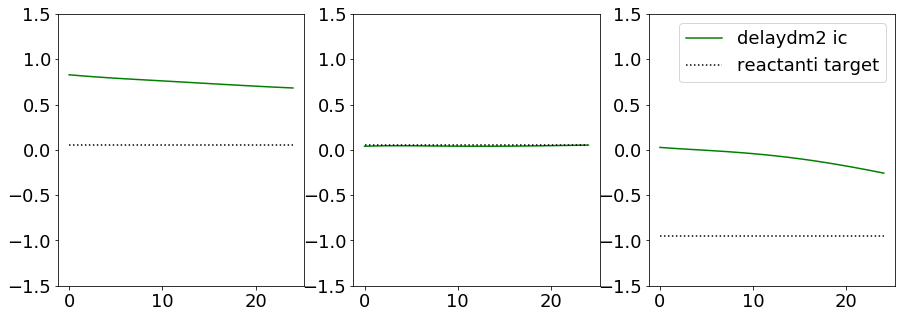

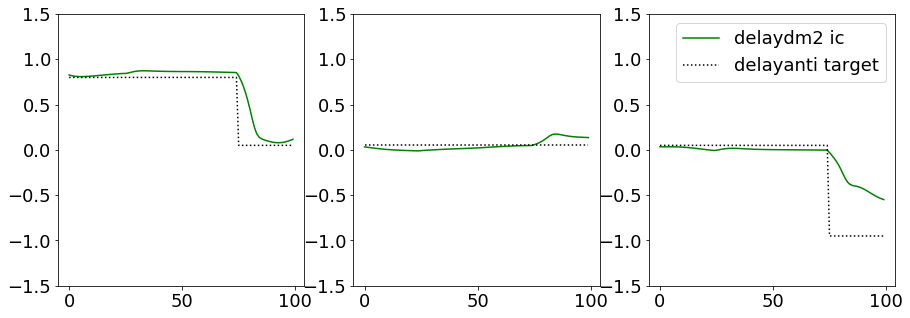

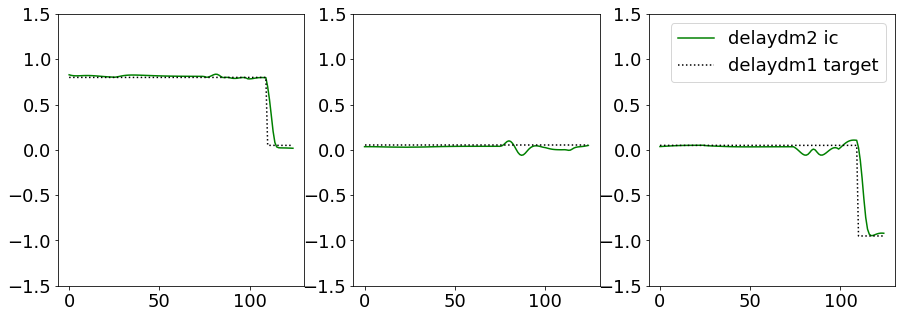

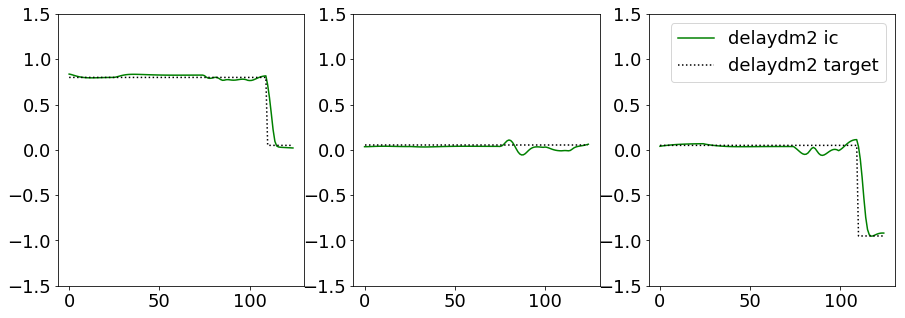

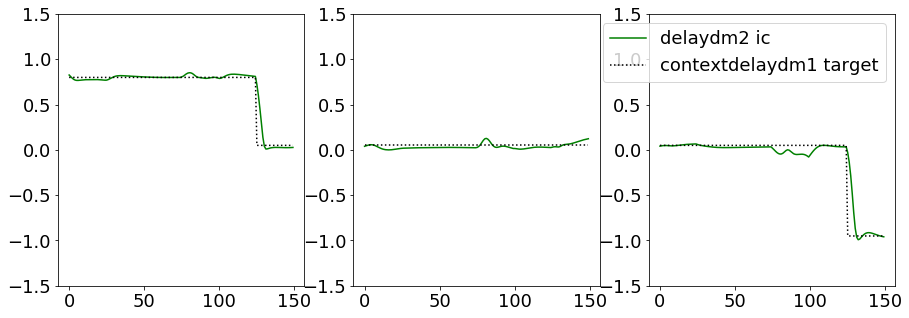

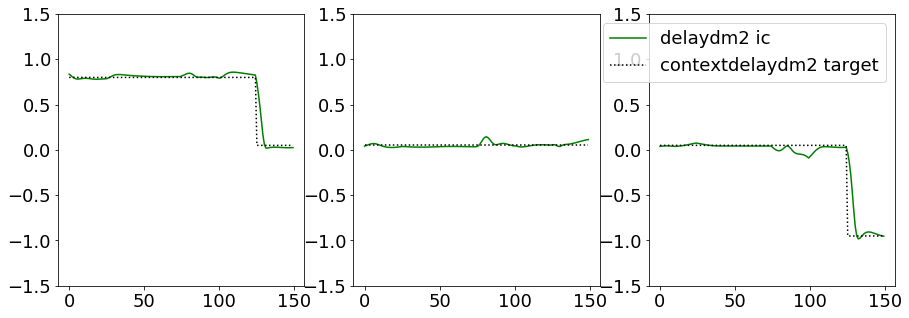

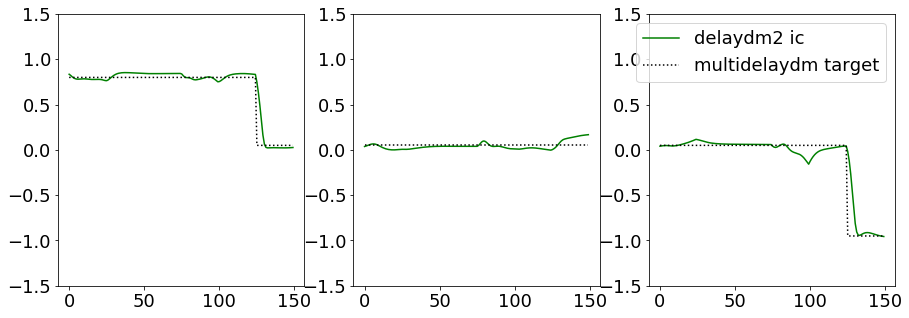

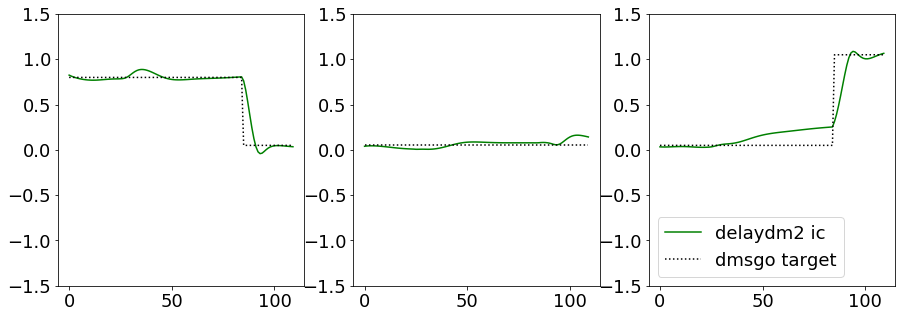

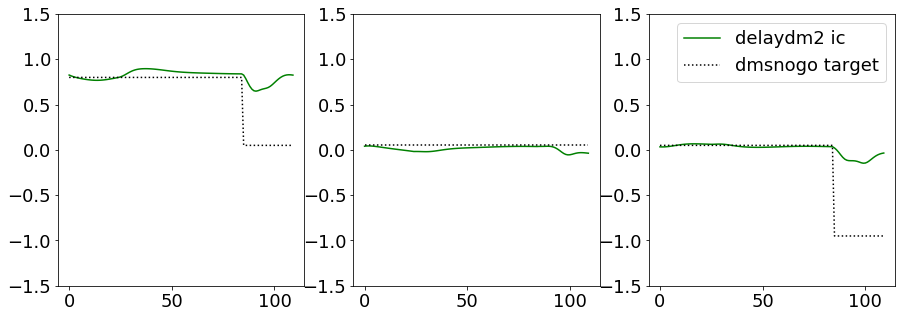

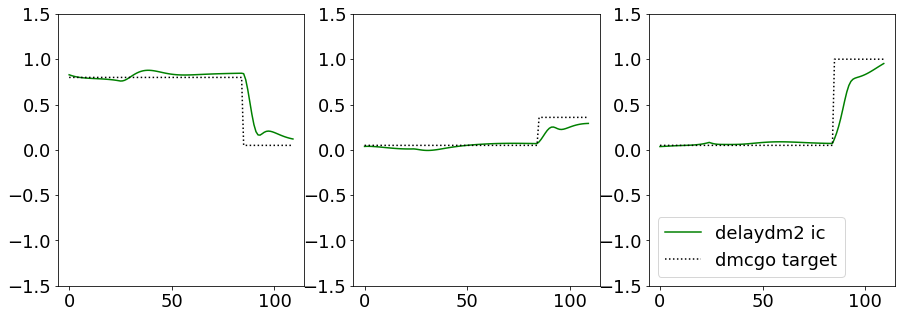

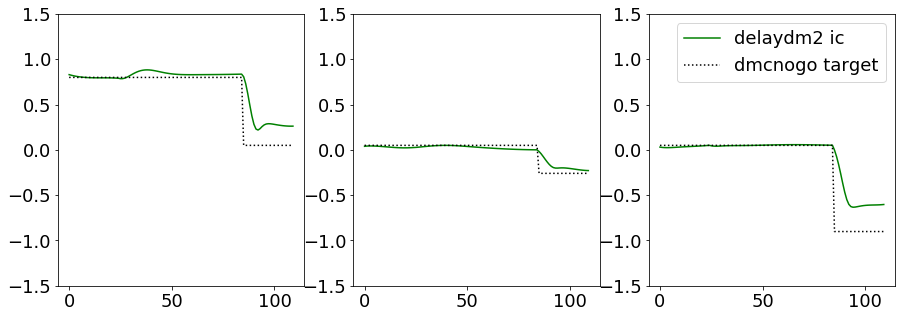

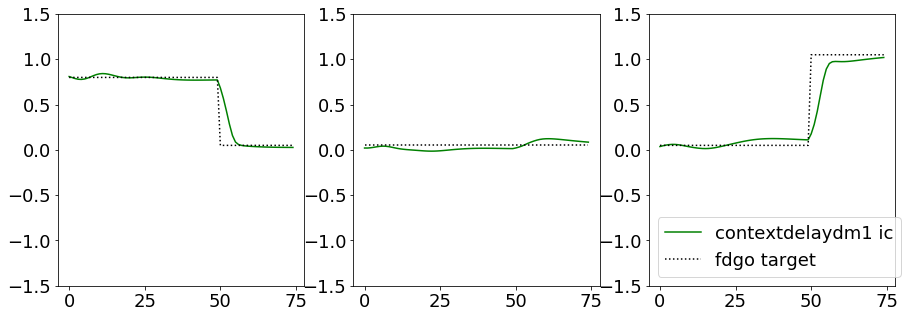

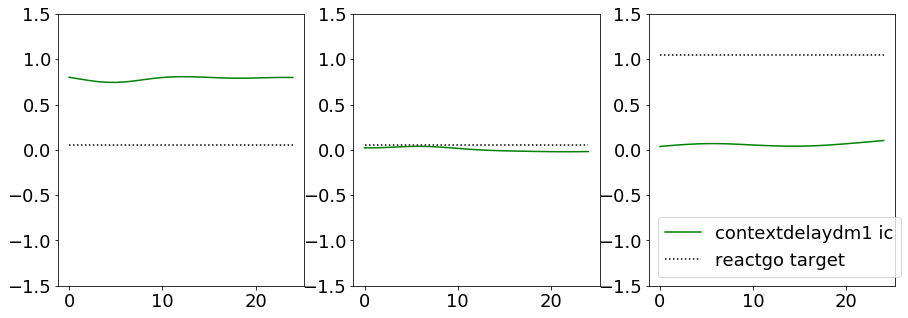

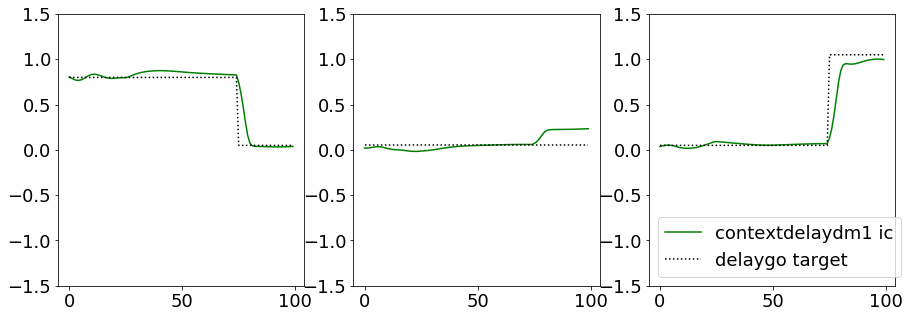

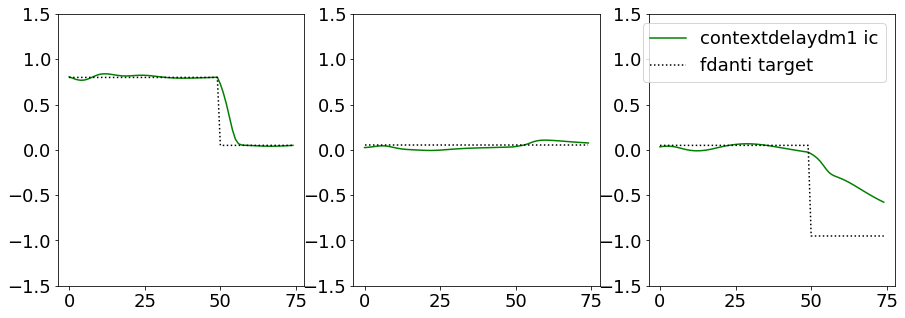

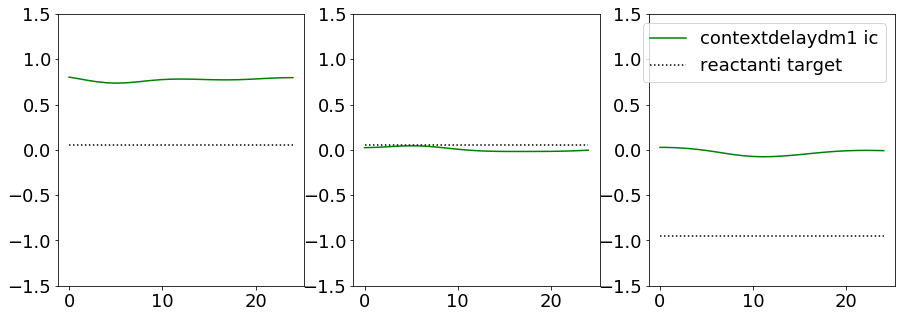

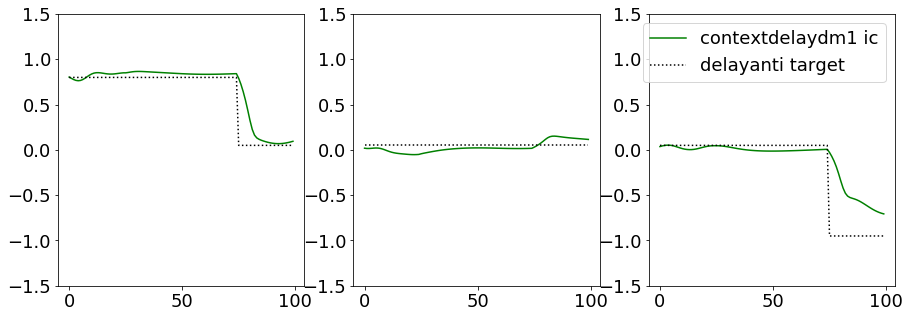

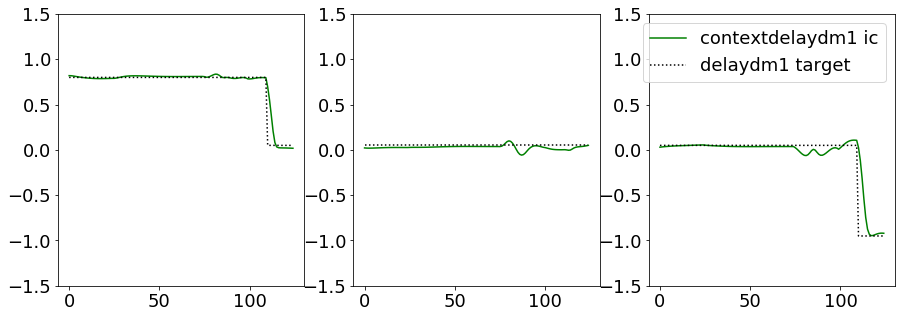

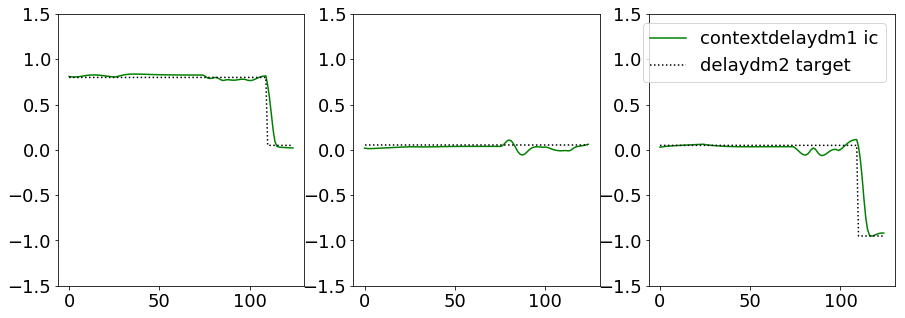

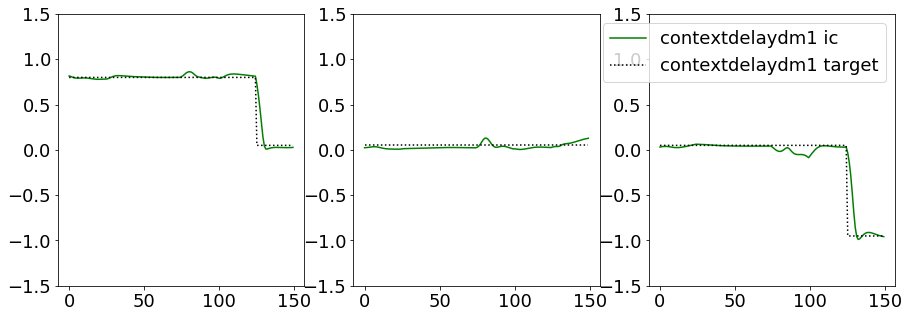

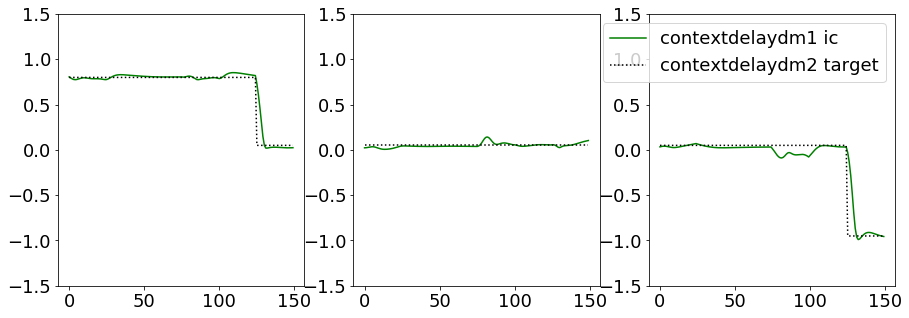

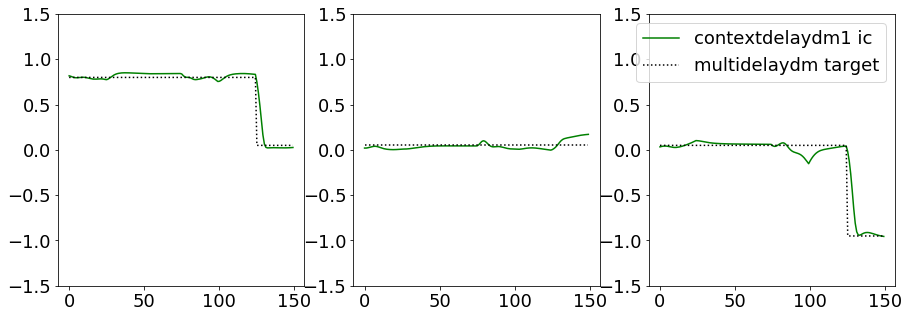

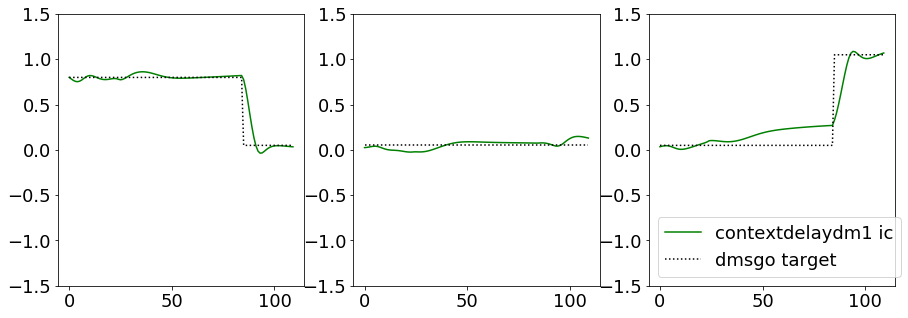

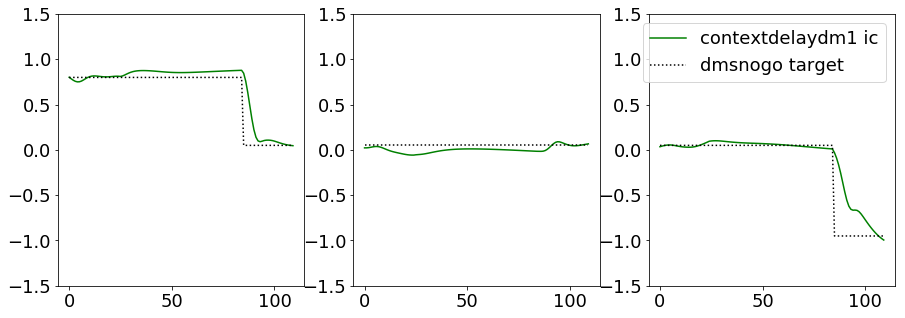

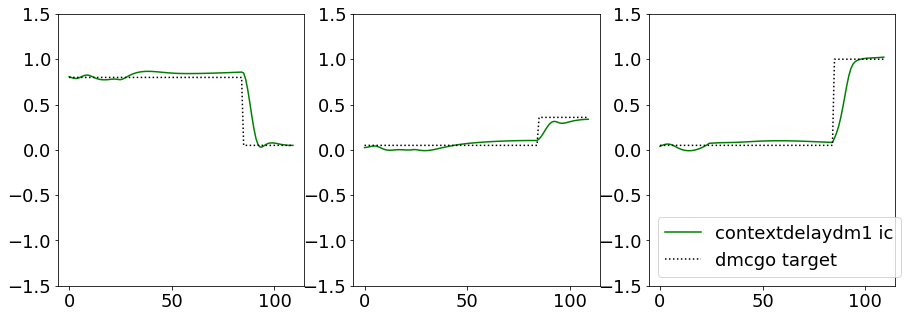

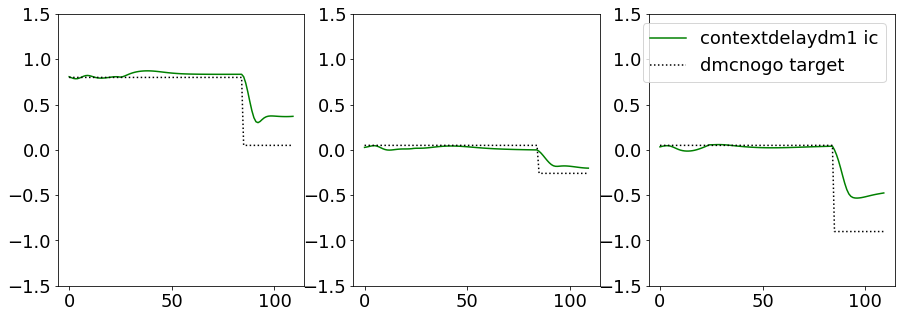

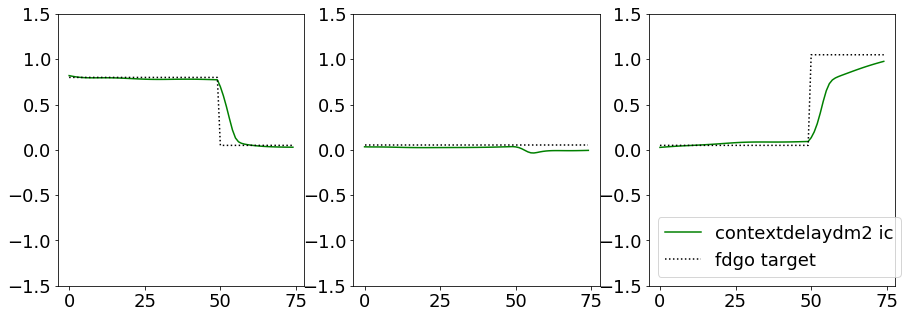

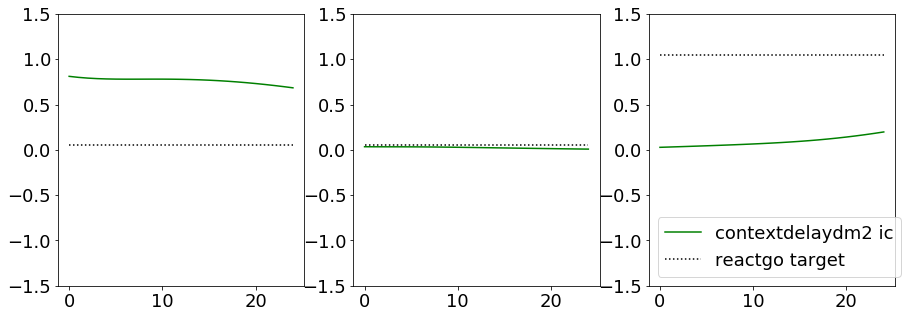

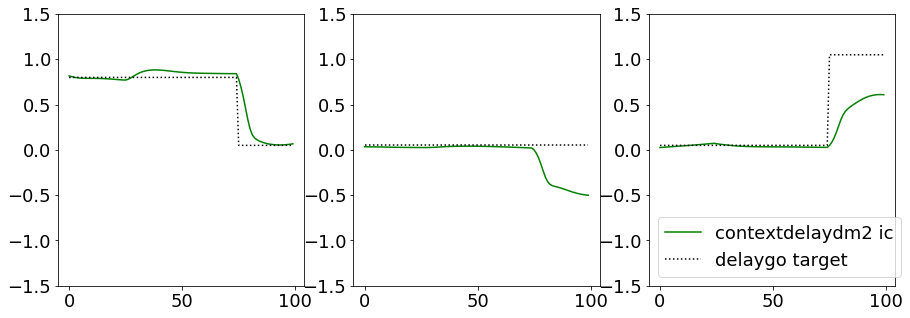

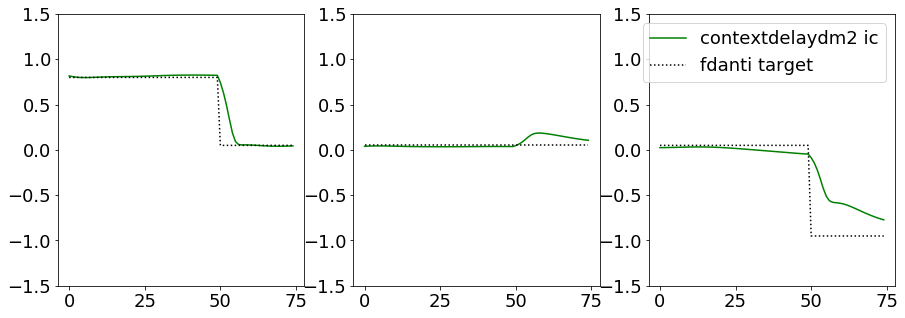

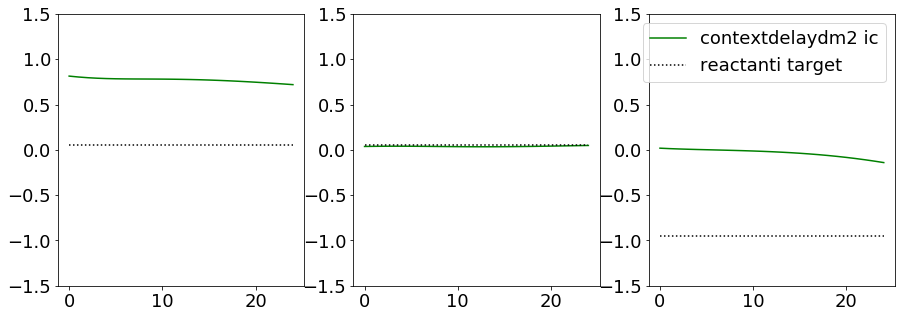

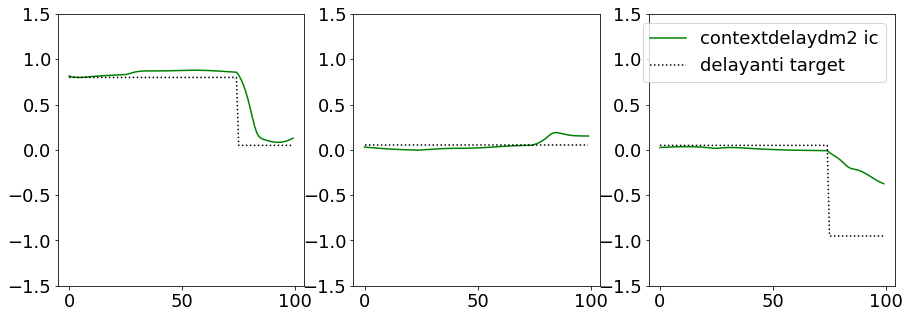

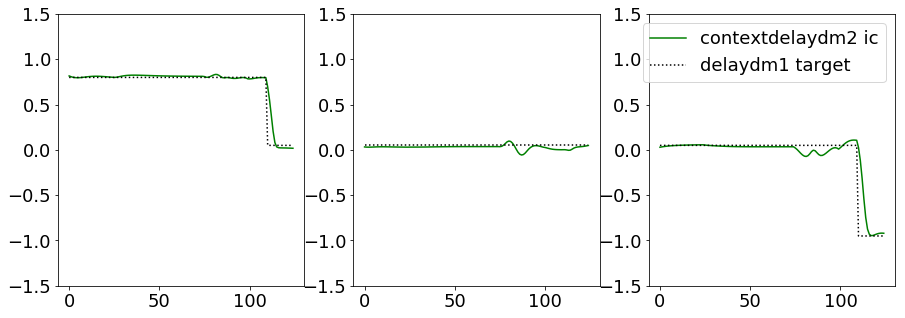

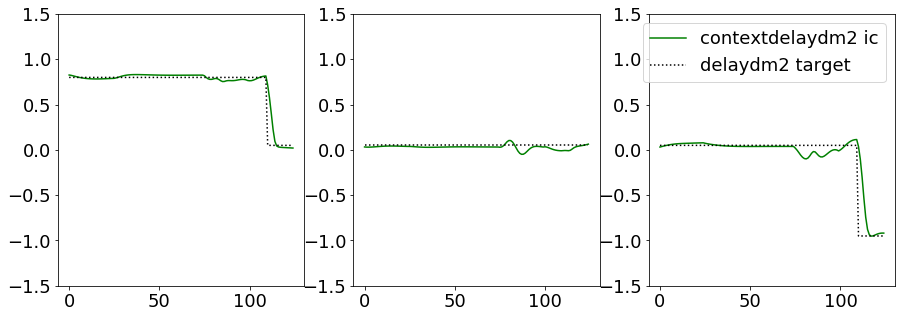

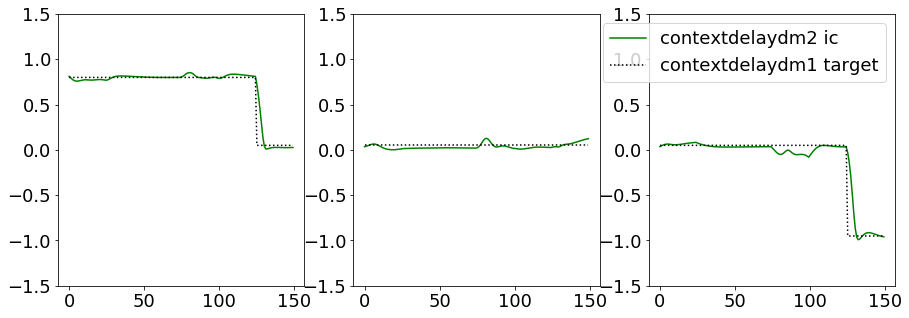

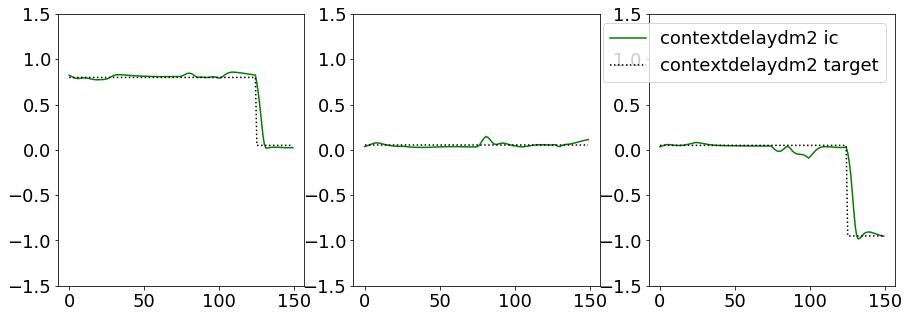

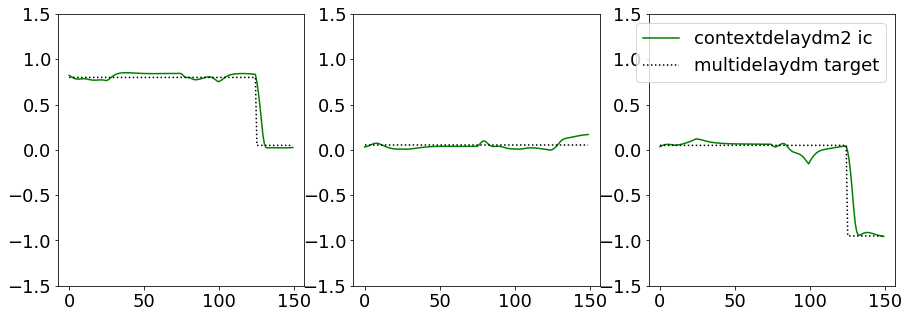

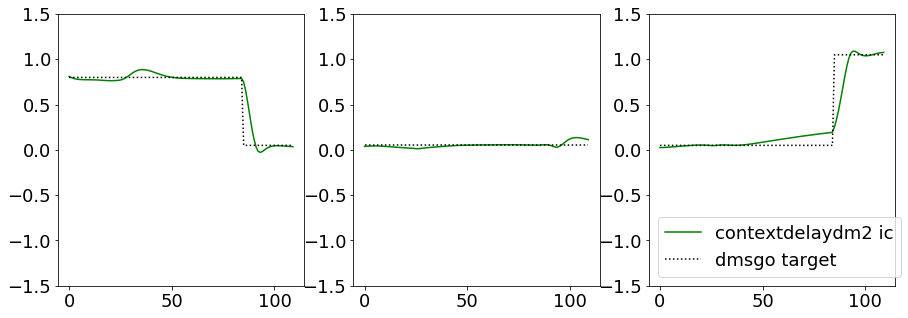

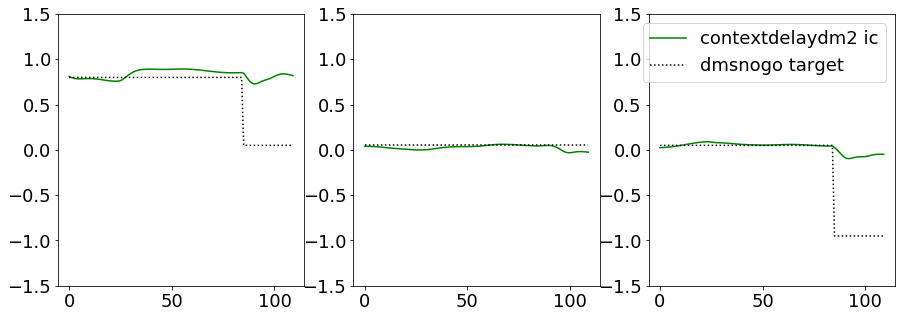

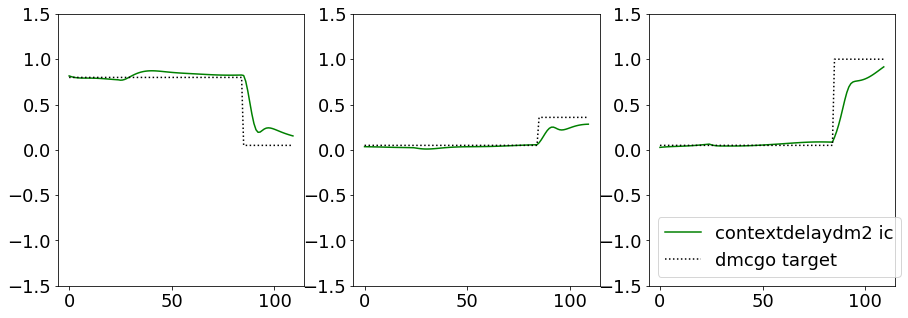

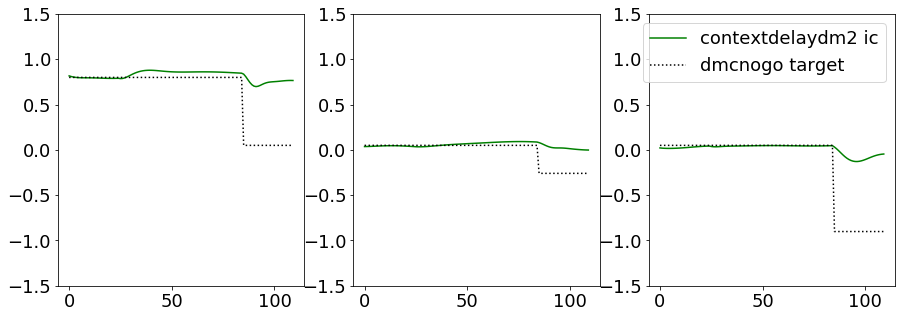

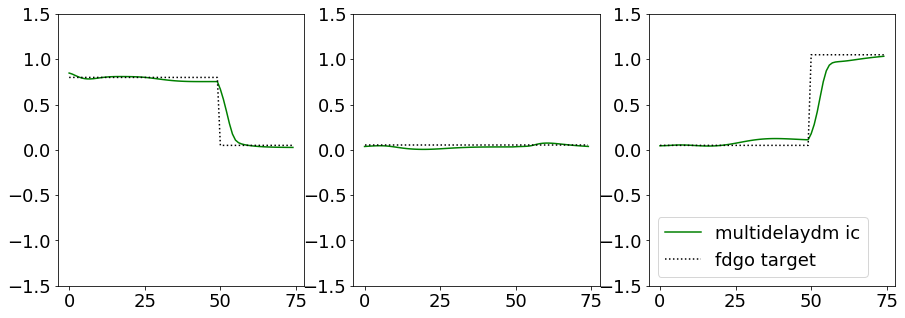

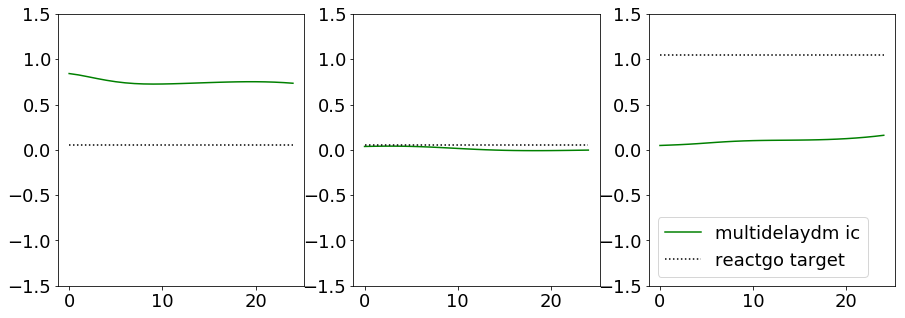

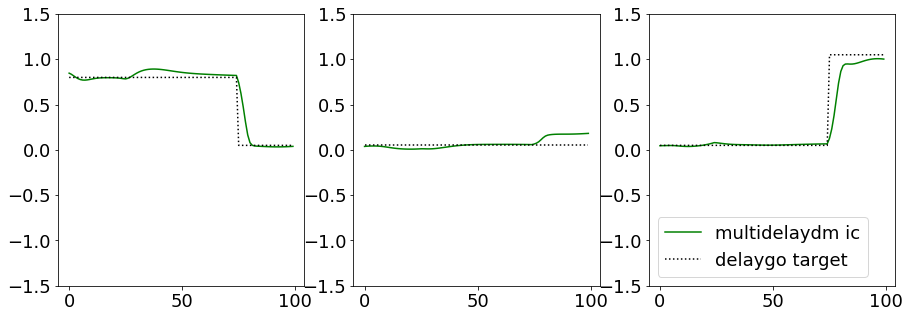

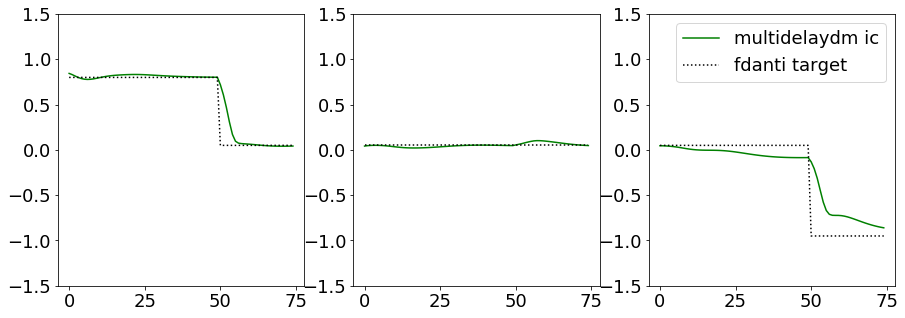

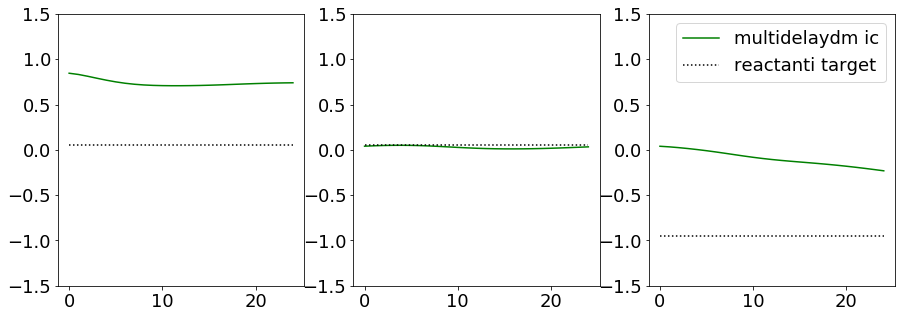

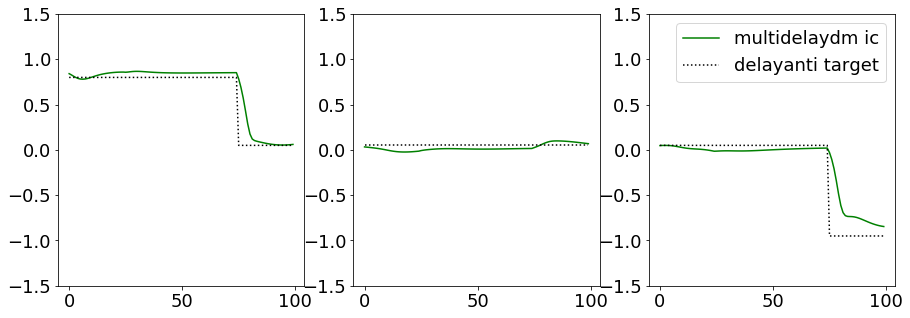

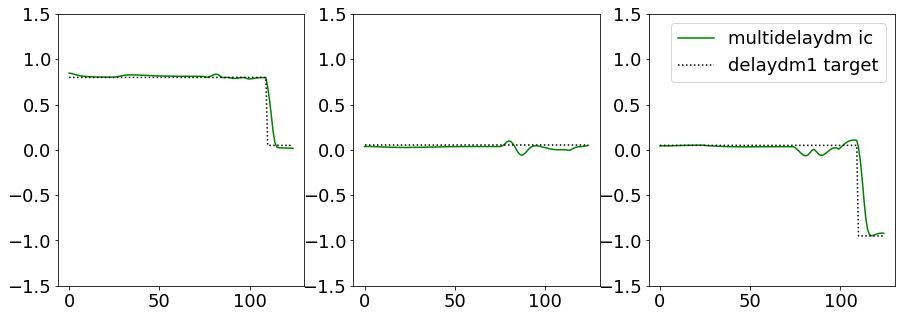

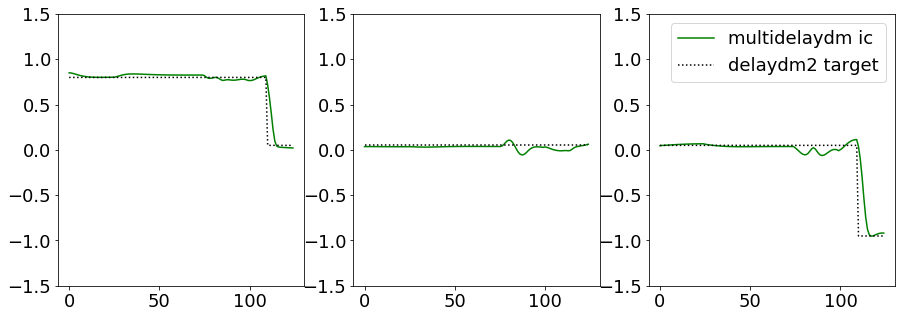

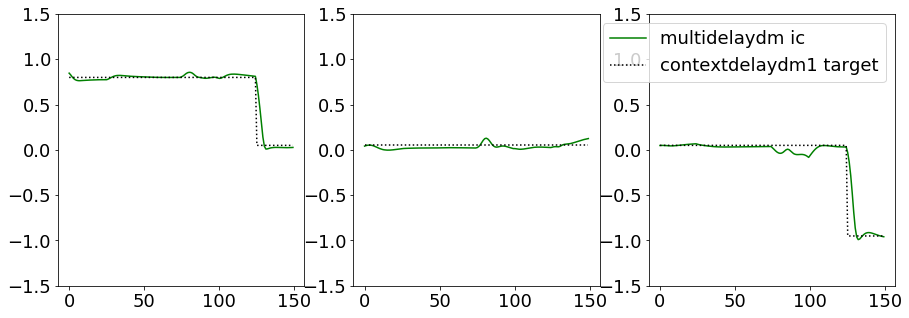

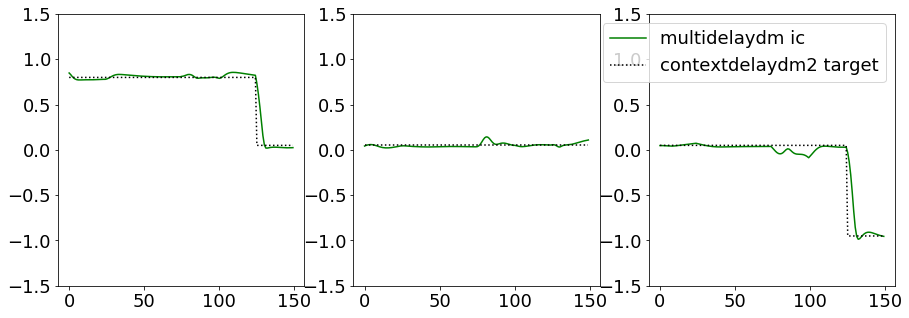

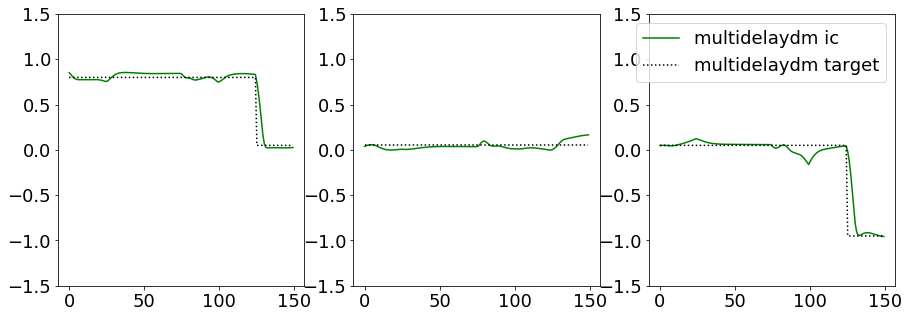

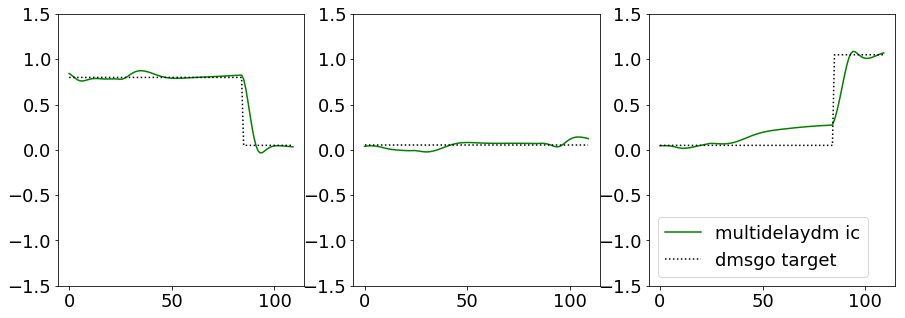

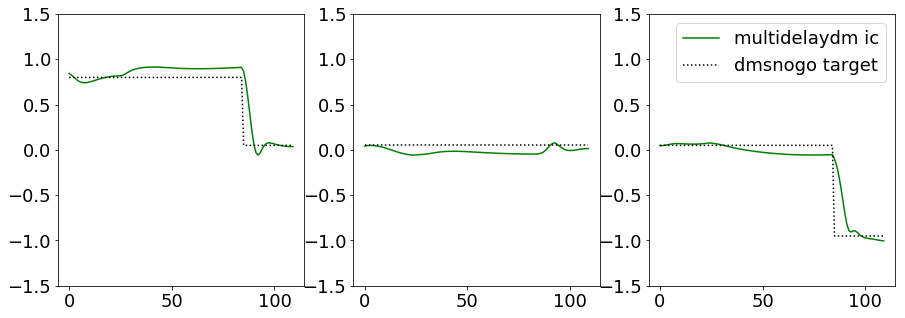

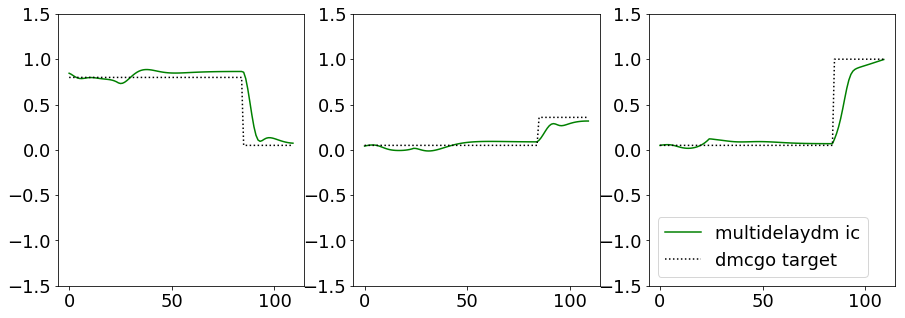

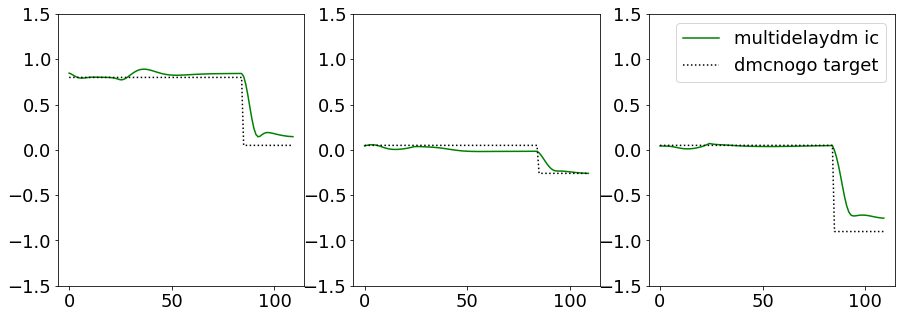

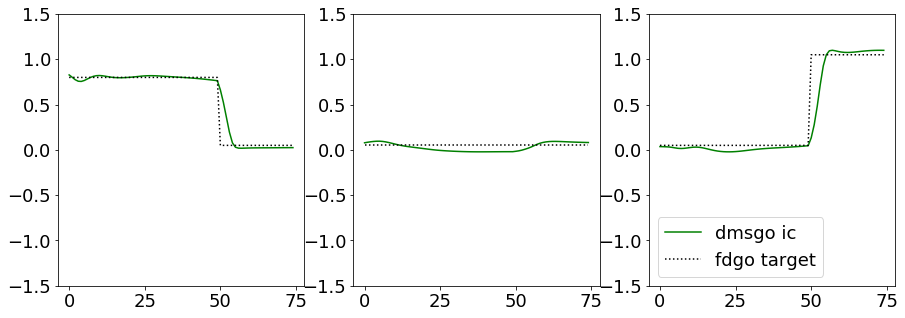

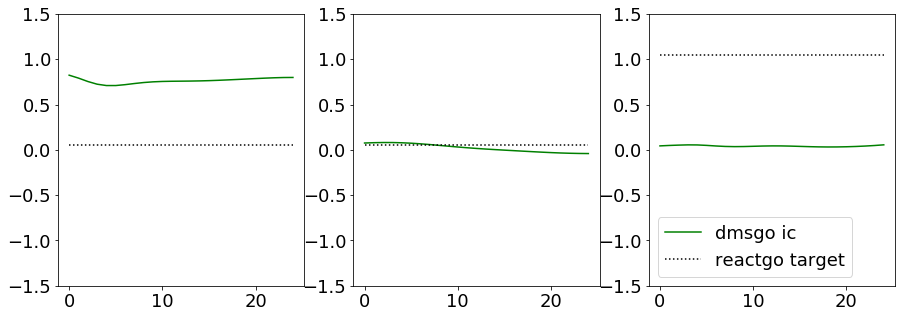

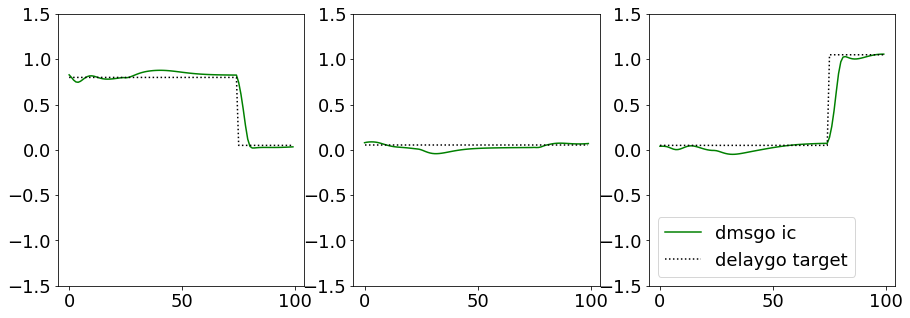

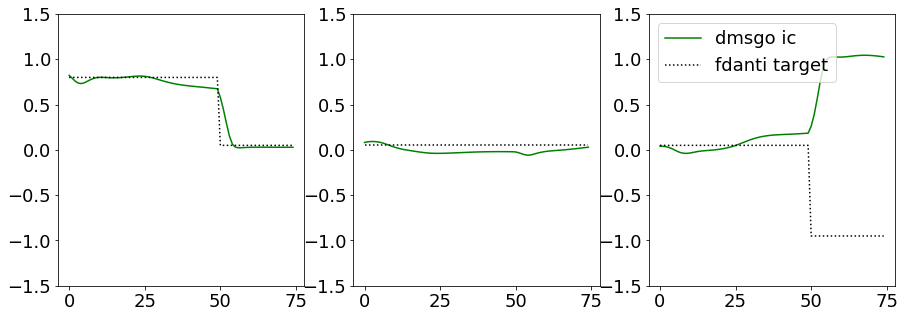

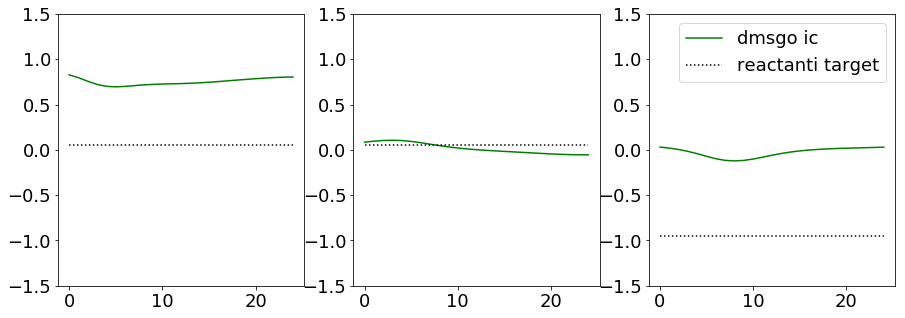

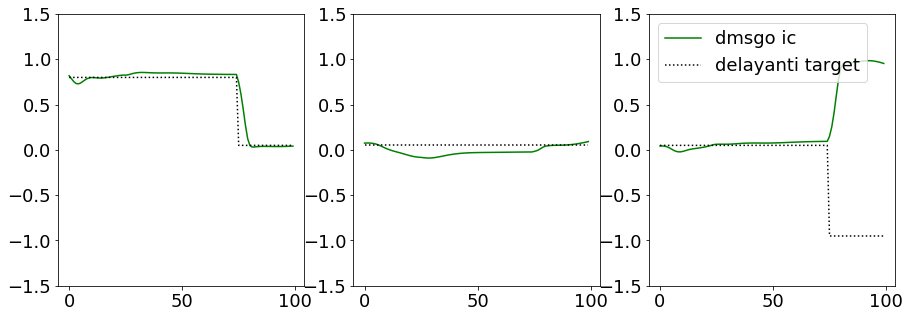

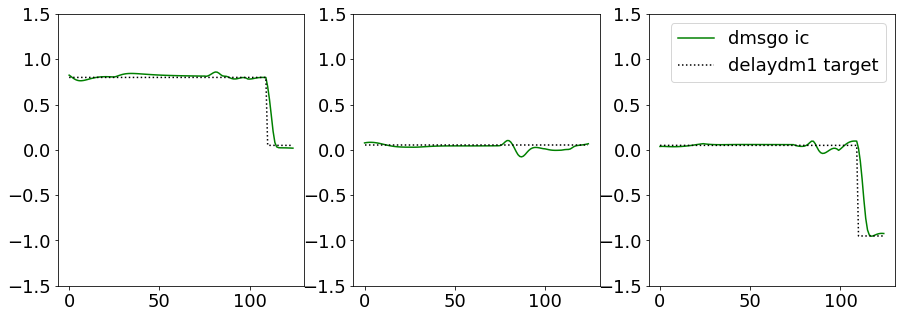

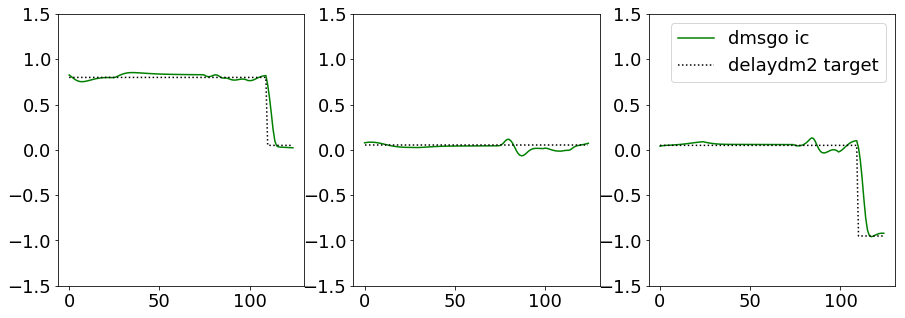

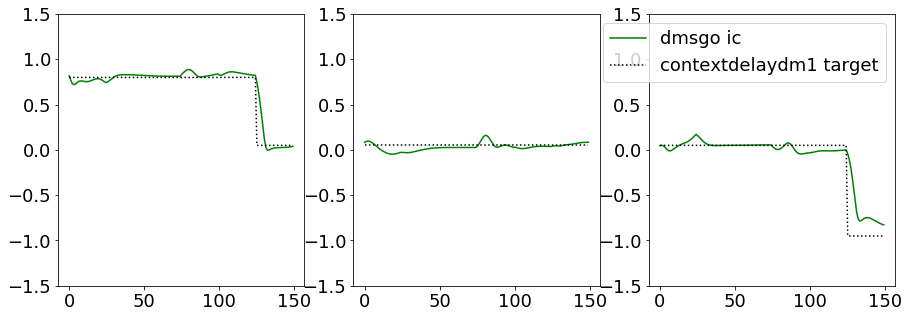

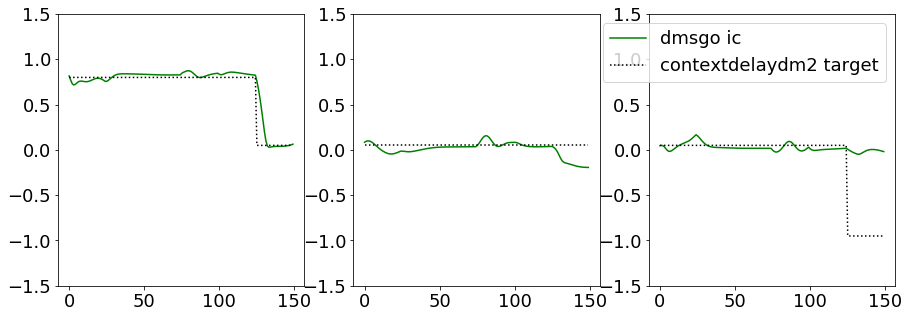

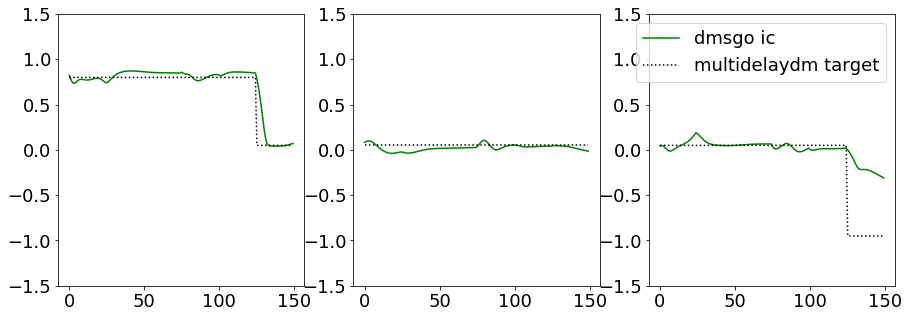

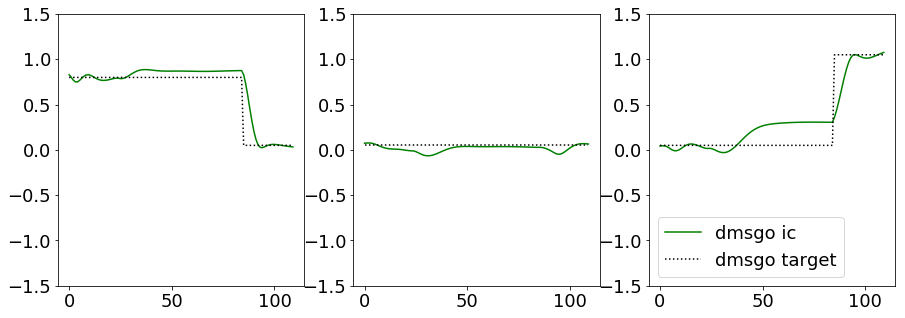

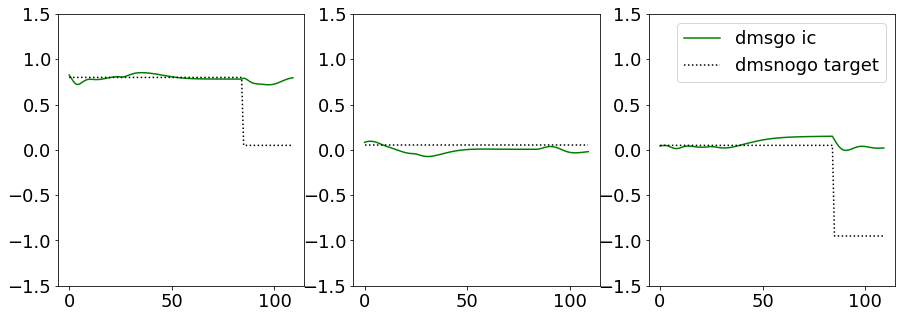

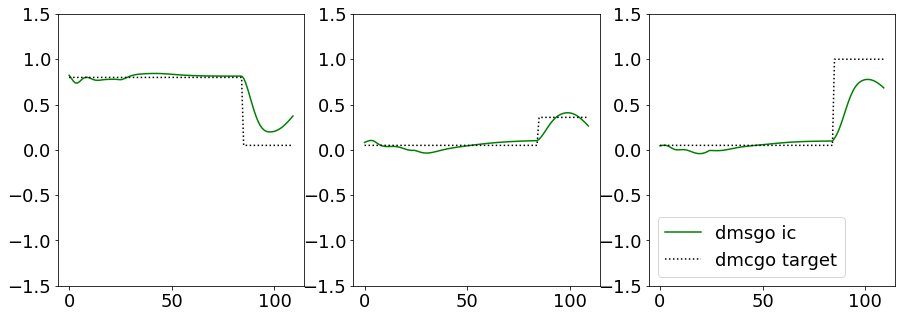

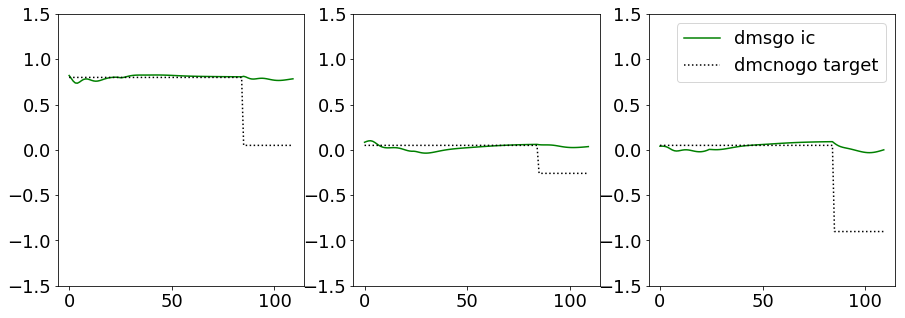

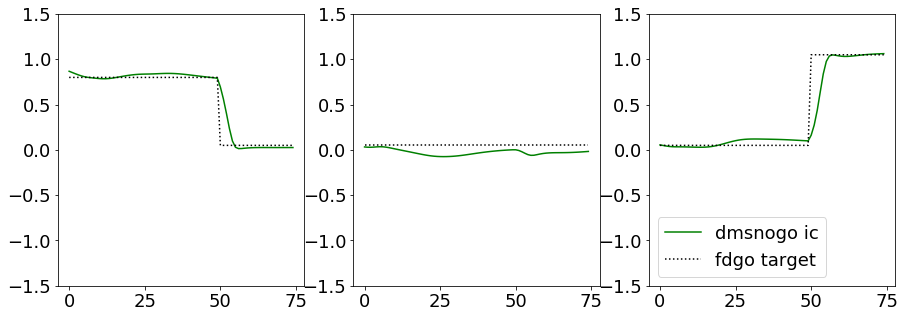

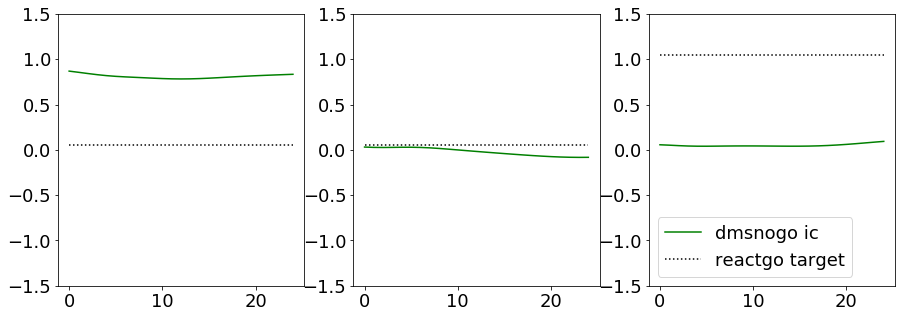

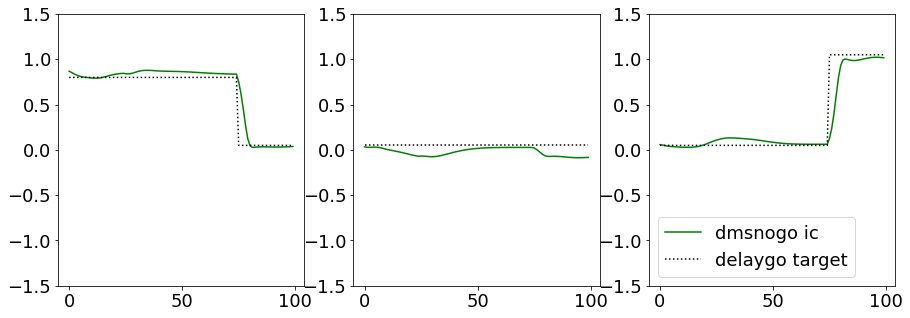

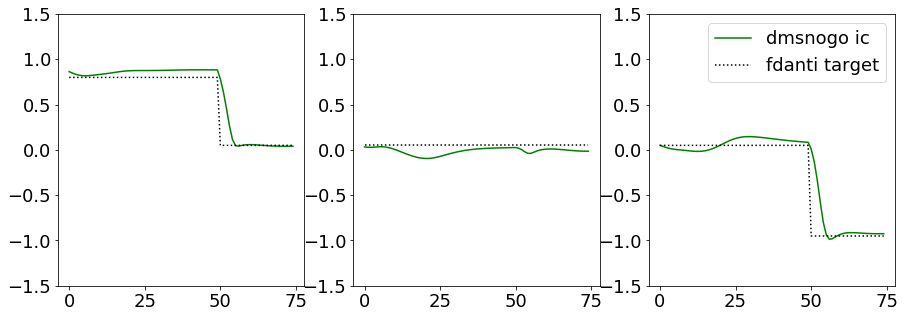

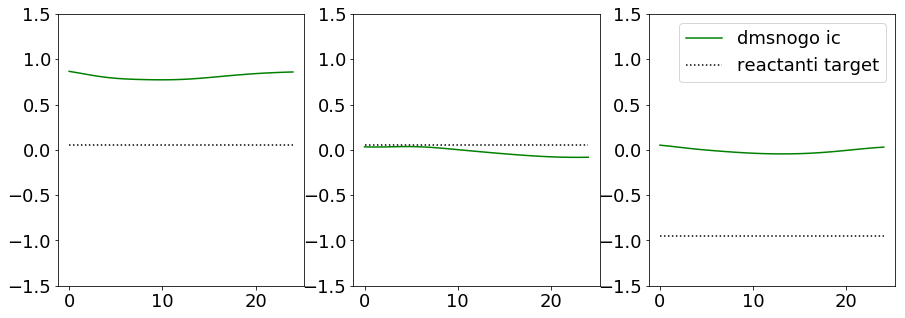

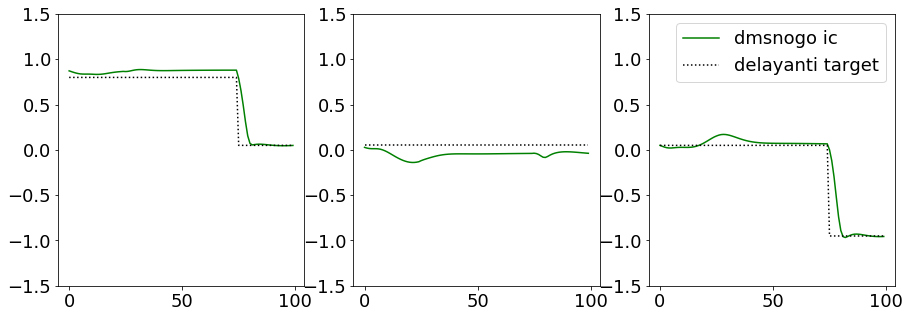

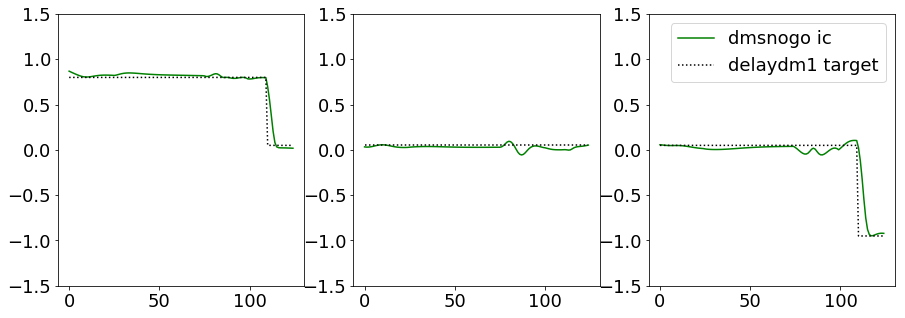

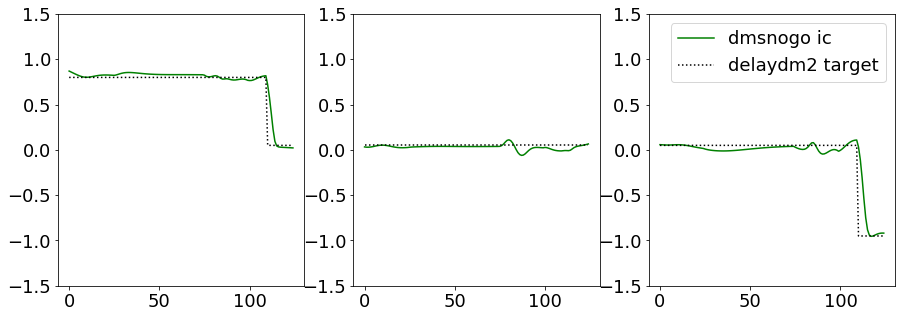

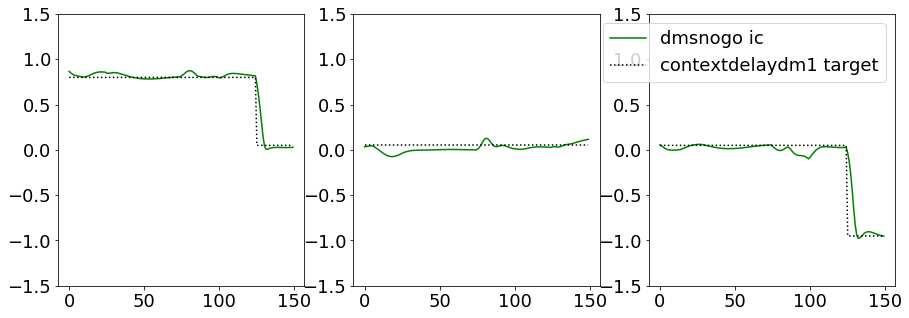

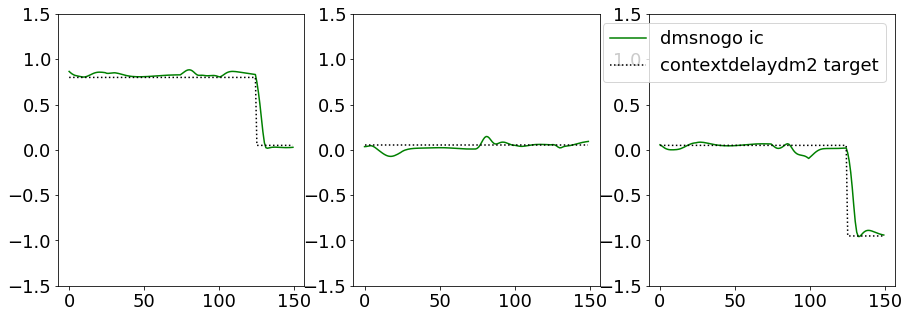

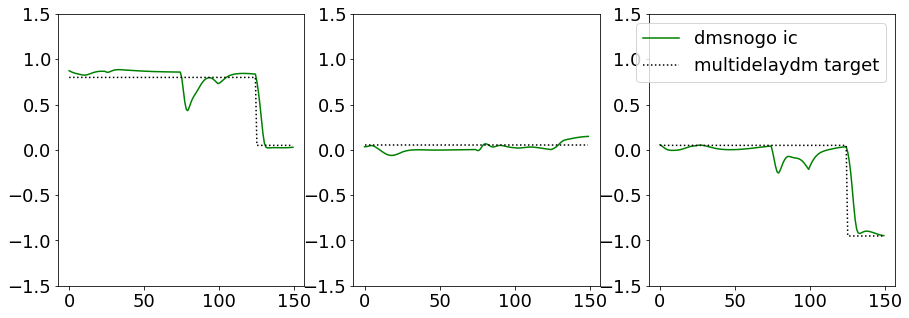

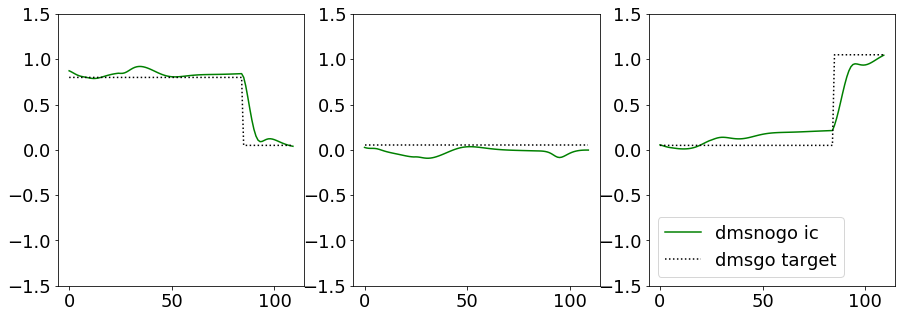

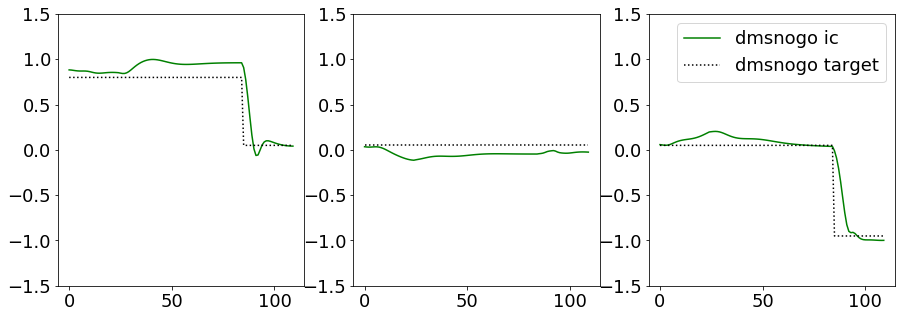

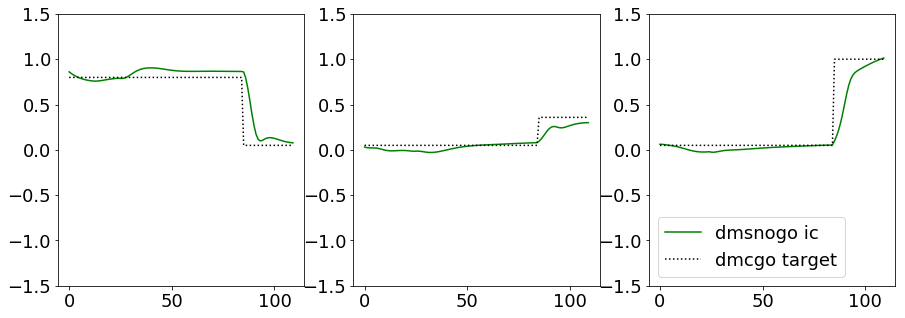

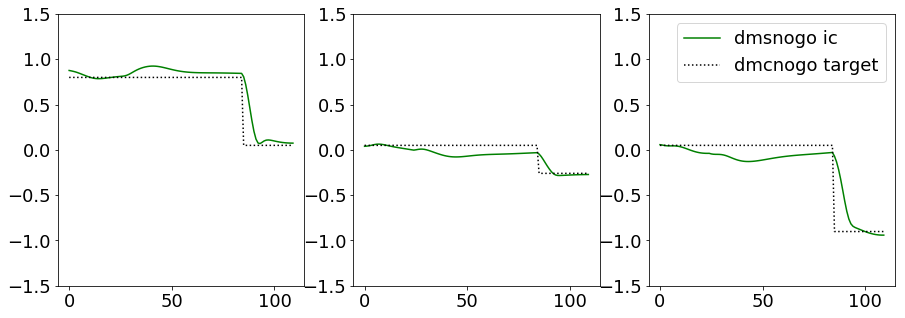

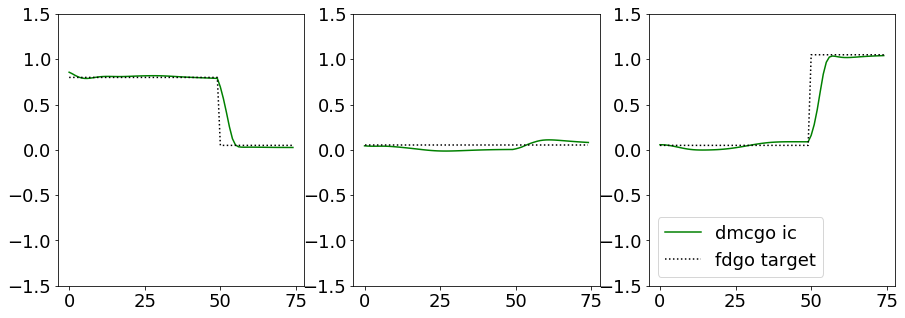

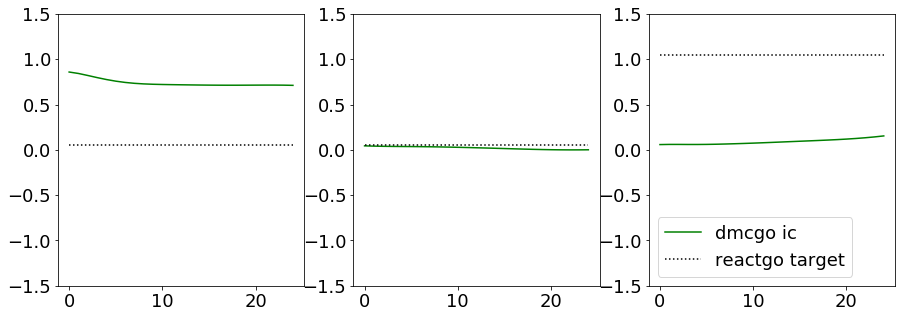

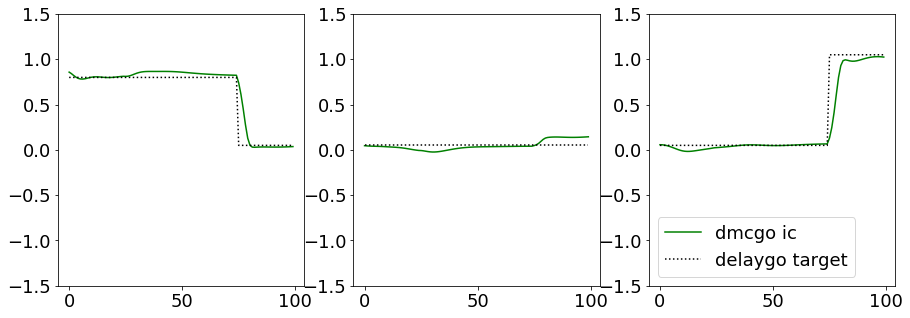

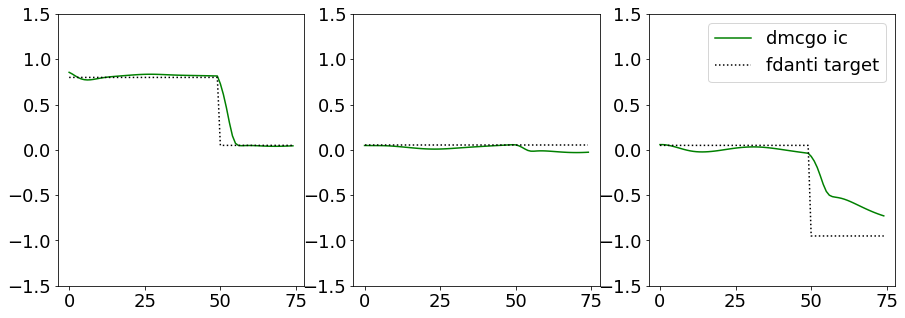

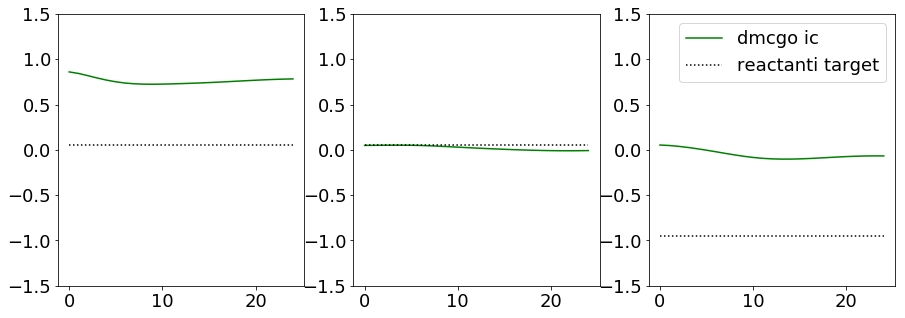

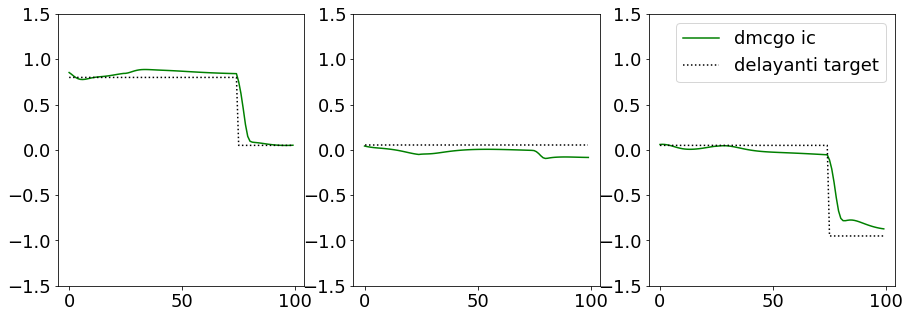

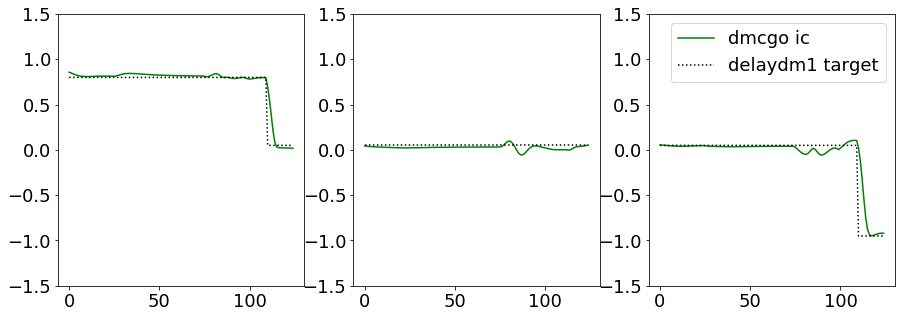

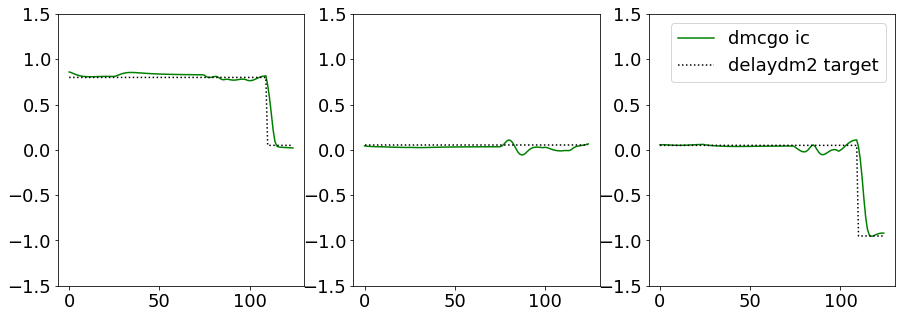

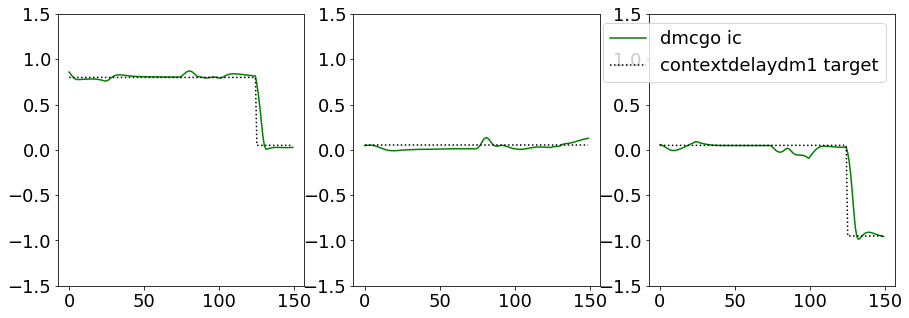

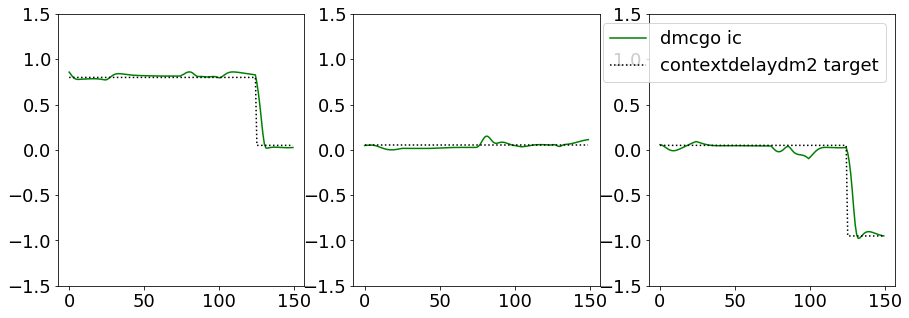

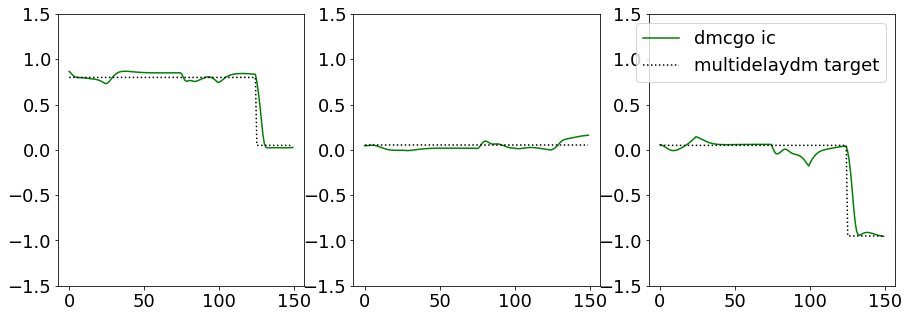

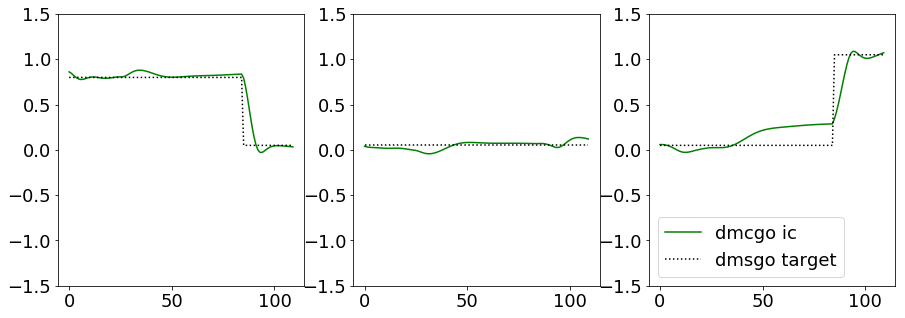

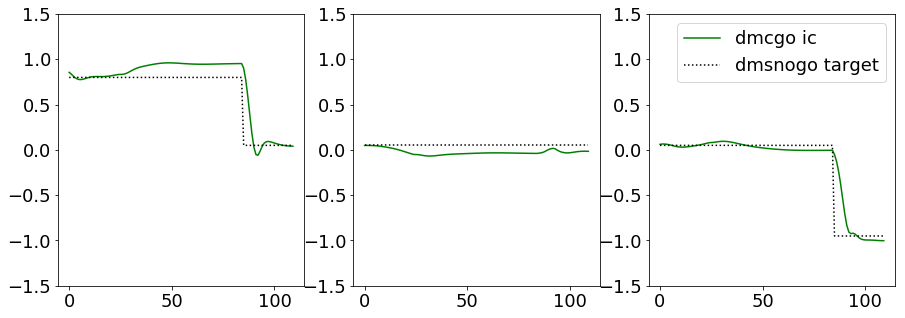

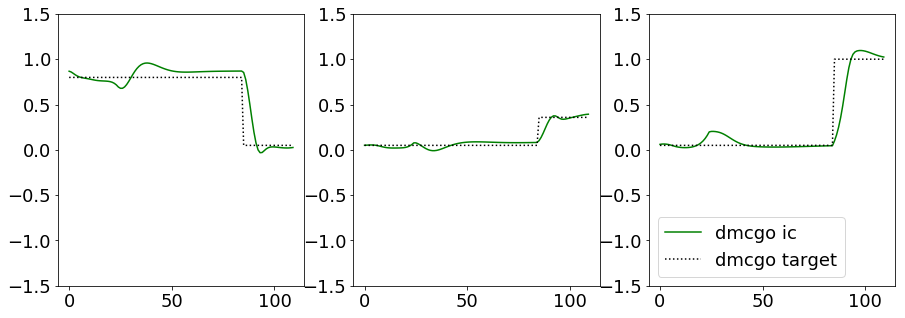

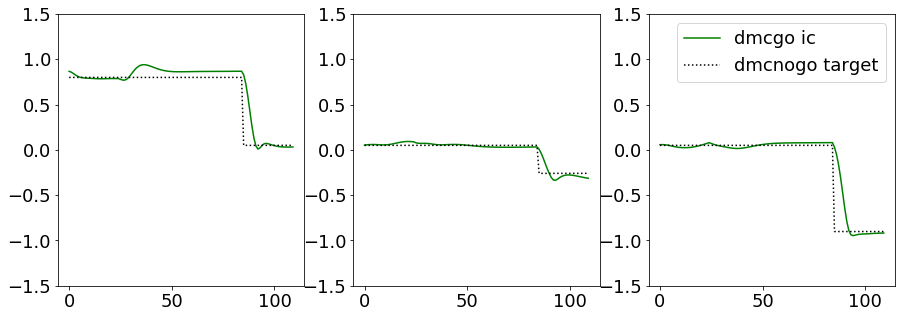

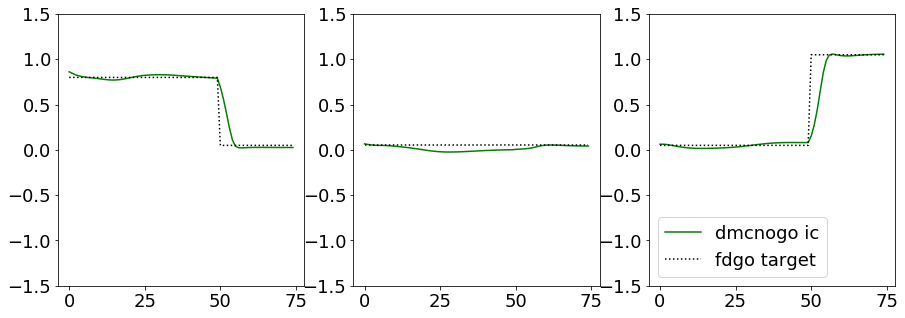

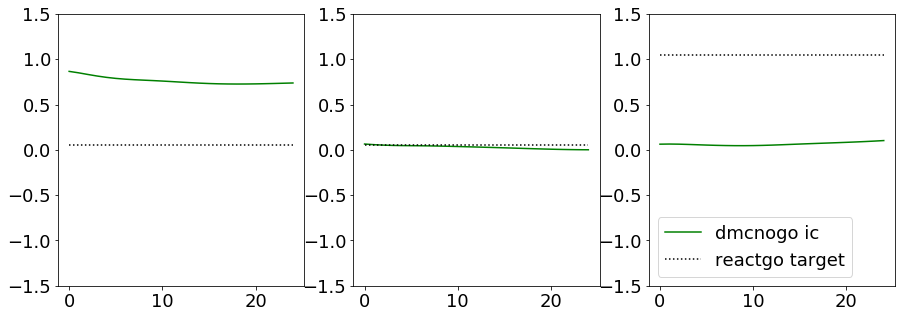

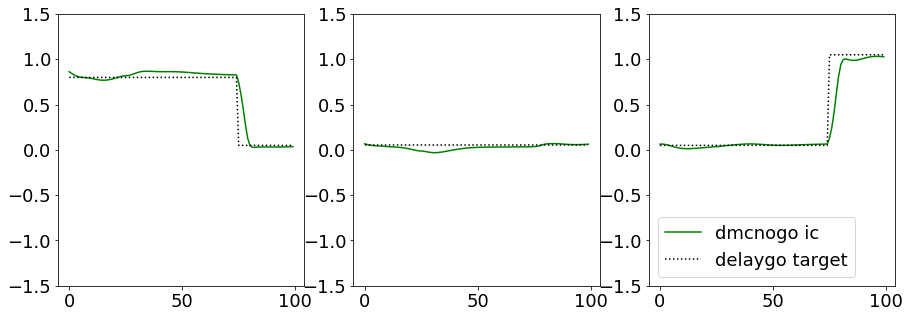

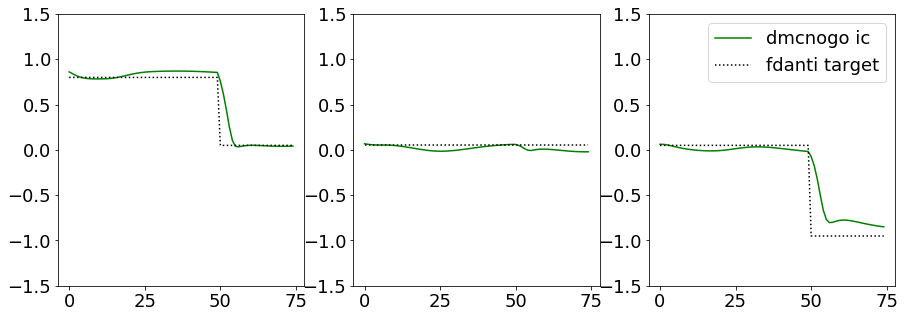

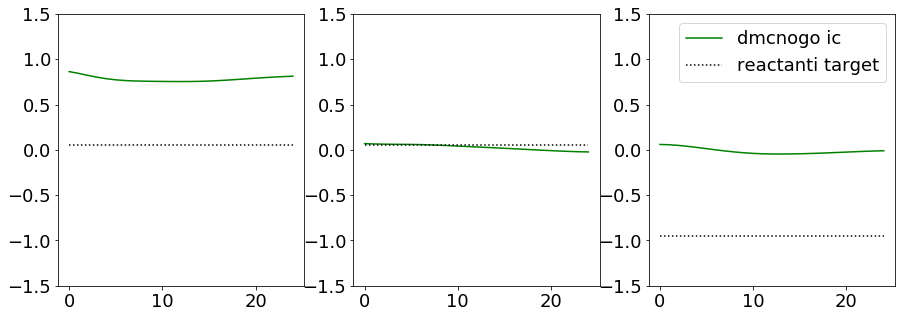

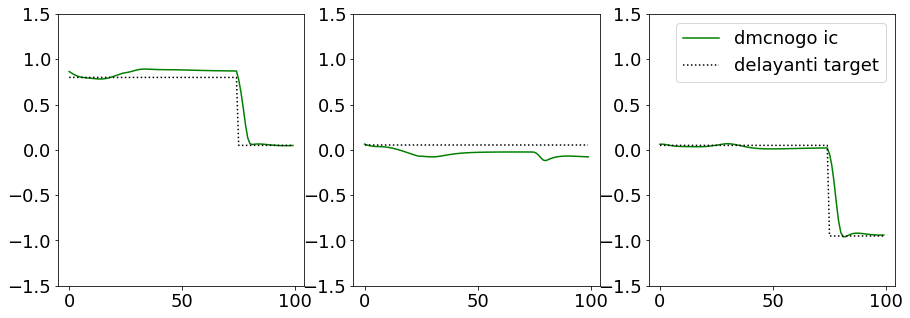

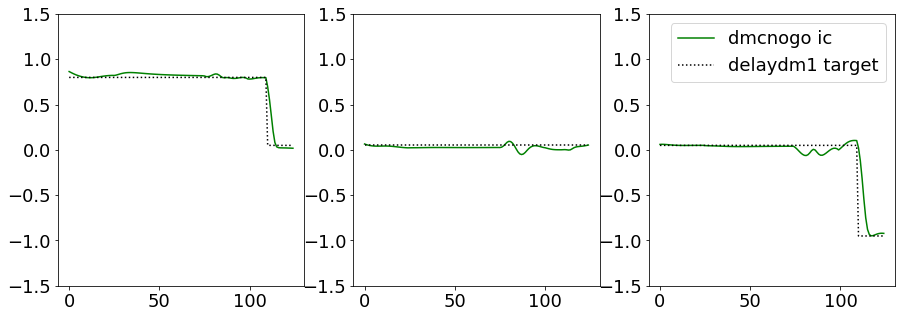

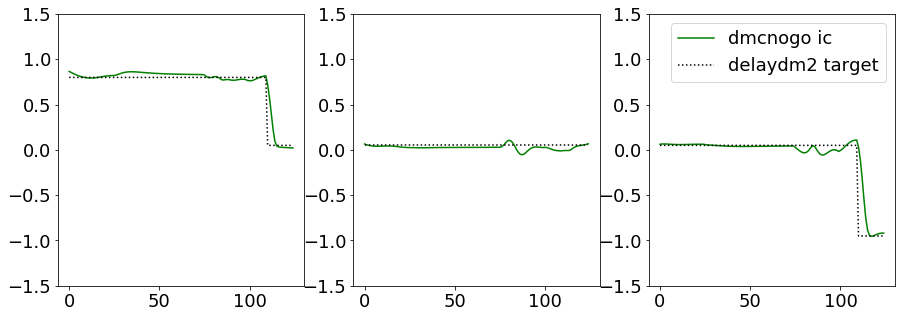

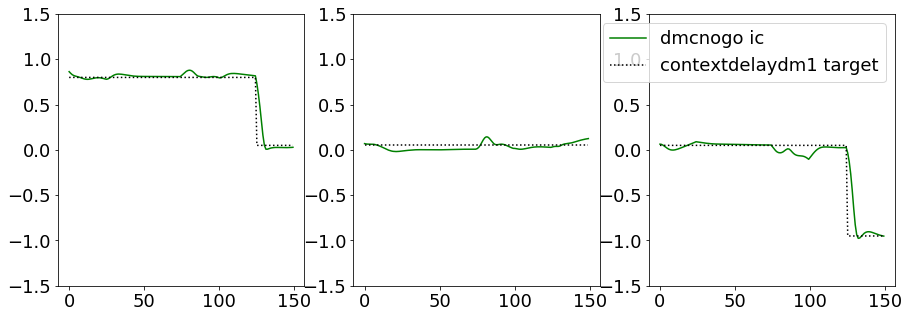

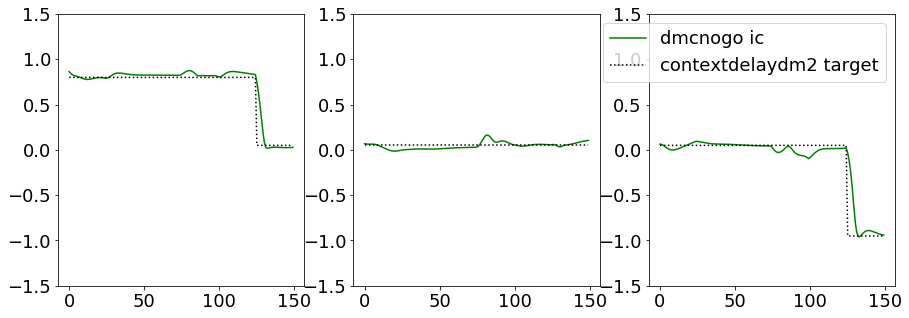

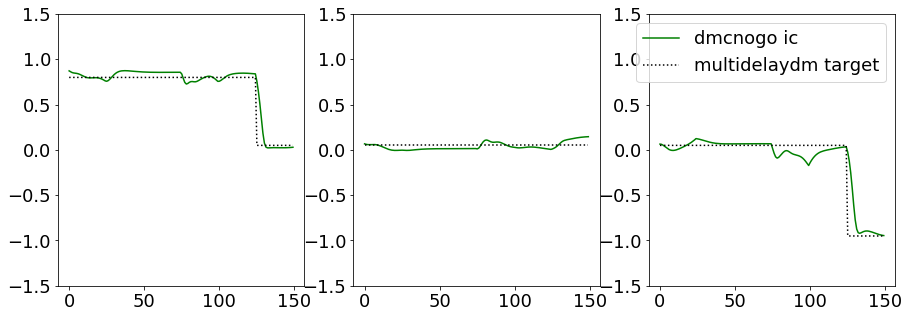

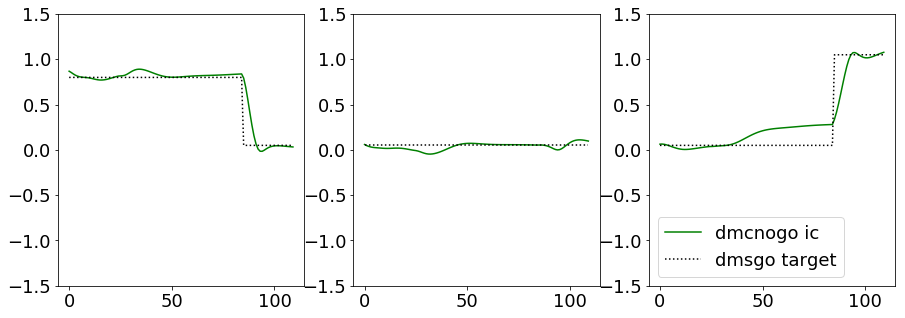

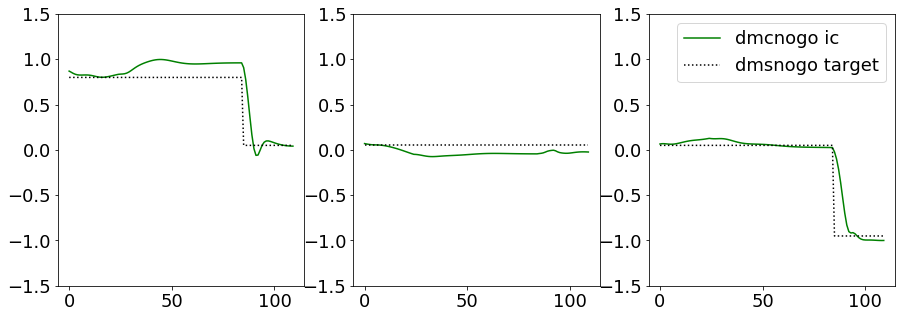

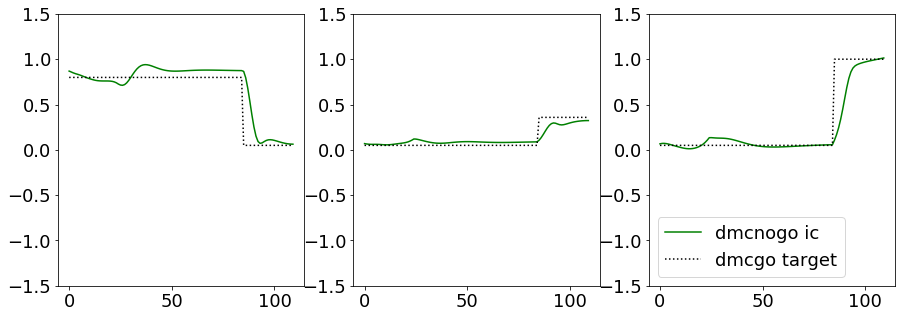

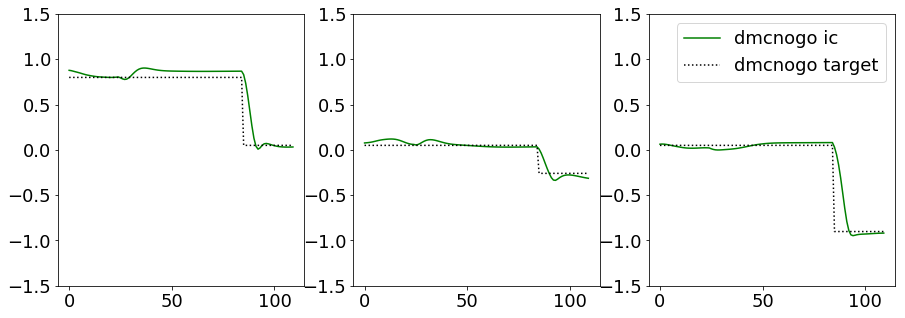

In [12]:
plt.rcParams.update({'font.size': 18})

for rule_ic in task_list:
    t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
    b = 0 #trial number for now
    h0 = h_all[rule_ic][t_ind,b,:]

    for rule_in in task_list:
        t_start = trial_all[rule_in].epochs['fix1'][1]
        t_end = len(trial_all[rule_in].x)
        n_steps = t_end - t_start

        h_t = np.empty((n_steps,n_rnn))
        y_hat = np.empty((n_steps,n_output))
        x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
        h = h0
        for ti in range(t_end-t_start):
            h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
            h_t[ti,:] = h
            y_hat[ti,:] = out_affine(params, h_t[ti,:])

        fig = plt.figure(figsize=(15, 5))
        for out_ind in range(n_output):
            plt.subplot(1,3,out_ind+1)
            plt.plot(y_hat[:,out_ind],'g',label = rule_ic + ' ic')
            plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':k',label = rule_in + ' target')
            plt.ylim((-1.5,1.5))

        plt.legend()    
        plt.show()

In [86]:
h_t = h_all['fdanti'][:,b,:]
n_steps = len(h_t)
y_hat = np.empty((n_steps,n_output))

for ti in range(n_steps):
    y_hat[ti,:] = out_affine(params, h_tf[ti,:])

fig = plt.figure(figsize=(15, 5))
for out_ind in range(n_output):
    plt.subplot(1,3,out_ind+1)
    plt.plot(y_hat[:,out_ind],'k')
    plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':g')
plt.show()

ValueError: shapes (3,256) and (80,256) not aligned: 256 (dim 1) != 80 (dim 0)

In [76]:
h_t = h_all['fdanti'][:,b,:]
n_steps = len(h_t)

In [79]:
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule_in, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [80]:
np.shape(y_hat_tf)

(100, 80, 3)

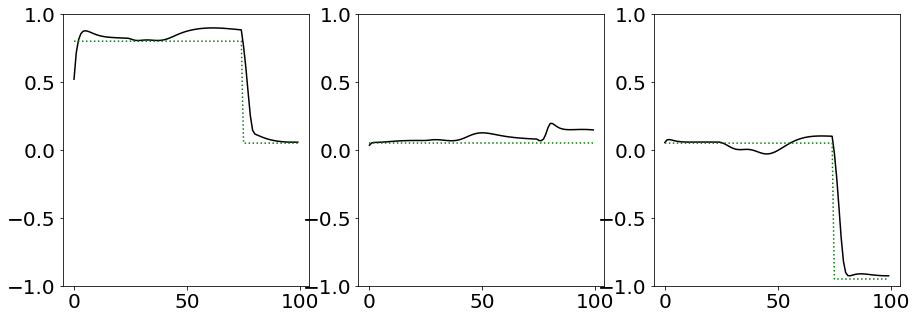

In [85]:
fig = plt.figure(figsize=(15, 5))
for out_ind in range(n_output):
    plt.subplot(1,3,out_ind+1)
    plt.plot(y_hat_tf[:,b,out_ind],'k')
    plt.plot(trial.y[:,b,out_ind],':g')
    
    plt.ylim((-1,1))
plt.show()